In [2]:
### Pull single combination
#import pygmt
import pandas as pd
import numpy as np

#INPUTS--------------

max_freq = 20 #Hz, 6,8,10,14,20
window_length = 1.5 #SECONDS, 0.5,1.5,1,2,3,4
array = '2A' #'POM', '3A', "2A"
array1 = '2a' #'pom', '3a'
analysis = 'lts' #fk, lts
timing = 'half' #quarter, half, start
model = 'japan_1d' #iasp91, japan1d, pavdut, ak135
#mod = 'iasp91'

strike = '249'
dip = '20'

path = '/Users/cadequigley/Downloads/completed_runs_v2/array_analysis/05s_window/window_freq_analysis/'
#PULLING DATA
if analysis == 'lts':
    if timing =='start':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_epic_start.csv')
    elif timing == 'quarter':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_epic_start.csv')
    else:
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_epic_start.csv')
        
else:
    if timing =='start':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_pick_start.csv')
    elif timing == 'quarter':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_pick_start.csv')
    else:
        df1 = pd.read_csv(analysis+'_all_events_'+array+'_half_before_pick_start.csv')
        
###############################################################
df2 = pd.DataFrame(df1[(df1['window_length'] == window_length)])
dfbaz = pd.DataFrame(df2[(df2['freq_max'] == max_freq)])

#df = pd.read_csv('~/Downloads/Research/2014-15_eqs.txt', delimiter = '|')
df1 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
#df2 = pd.read_csv("/Users/cadequigley/Downloads/Research/ls_time_plots/spatial_example_baz_errors.csv")
#snell = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/'+array+'_3Dsnell_dip_'+dip+'_strike_'+strike+'.csv')
japan = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/'+model+'_values_9c_arrays.csv')
comb = pd.merge(dfbaz, df1, on='event_id', how='inner')
comb = pd.merge(comb, japan, on = 'event_id', how = 'inner')


### Basemap

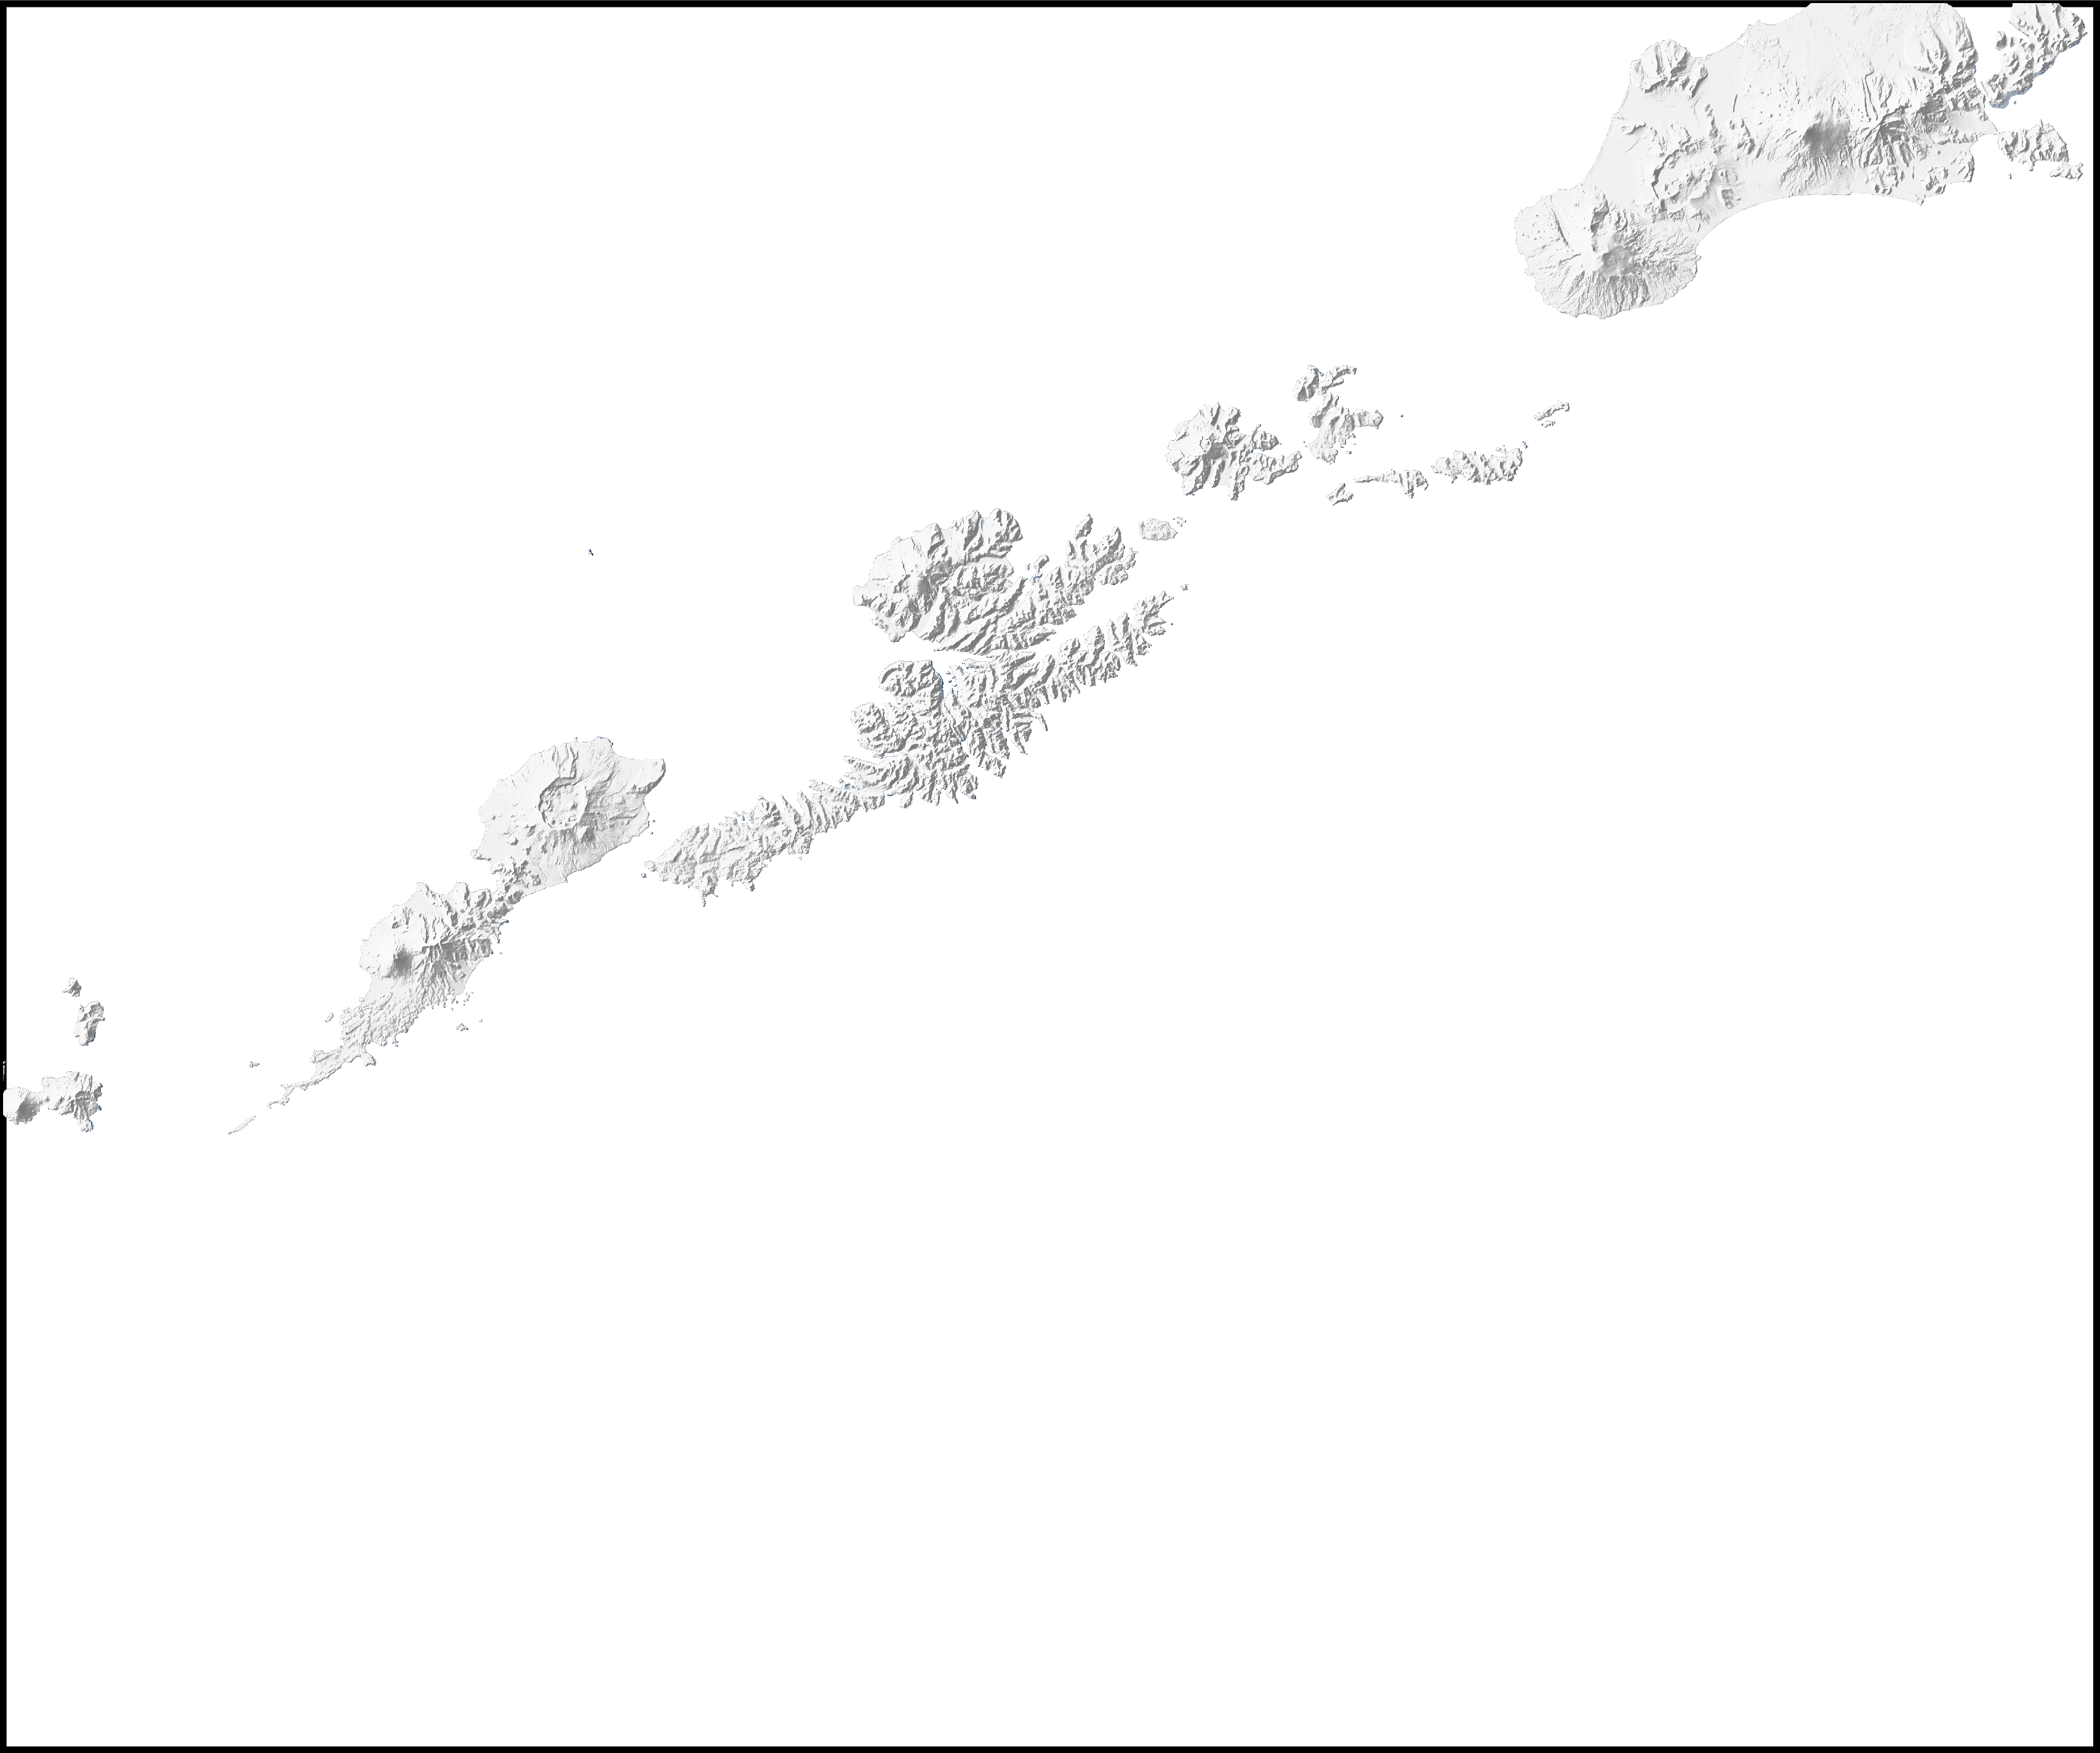

In [47]:
import pygmt
import pandas as pd
import numpy as np

df = pd.read_csv('~/Downloads/Research/2014-15_eqs.txt', delimiter = '|')
df1 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
CPT_Option = '/Users/cadequigley/Downloads/Research/AEC_BaseMap.cpt'

#pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain", MAP_FRAME_AXES='lrbt') # Highlevel formatting (no ticks, no labels)

pygmt.config(FORMAT_GEO_MAP="ddd.x") # Highlevel formatting (no ticks, no labels)
#Define projection and grid map resolution (for BOTH maps)
#region = [148, 252, 40, 83]     #lat/lon curved DEM, needs to be oversized
#region_rect = "178/45/248/67r"  #rectangular designation for plotted mat
region=[-180,-160,48,60]
#region=[-170,-163,51,55.5]
#region_rect = "-171/51/-163/55r"  #rectangular designation for plotted mat
region_rect = "-170/51.5/-163/55r"
#projection = 'S210/90/8i'
projection = "M4i"
projection="M0/0/12c"
#projection = 'M210/90/8i'

run_topo = True
##---Begin basemap w/ only AK topography---##

if run_topo == True:
    # Load topography
    load_grid = pygmt.datasets.load_earth_relief(resolution='03s', region=region, registration=None, data_source='igpp', use_srtm=False) #15s
    
    #pyGMT basemap with topography figure
    fig = pygmt.Figure()
    pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_TYPE="plain", MAP_FRAME_AXES='lrbt', MAP_FRAME_PEN='1p') #Formatting
    #pygmt.config(FORMAT_GEO_MAP="ddd.x",  MAP_FRAME_PEN='1p') #Formatting
    
    #Add topography basemap (DEM)
    fig.basemap(frame=True, region=region_rect, projection=projection)
    
    #Define outline and color pallete of basemap
    fig.coast(dcw="US.AK+c" )#, shorelines=True, water='#C6E2EE', borders="1/1p,black") #frame=[fig_title]
    dgrid = pygmt.grdgradient(grid=load_grid, radiance=[270,30])
    pygmt.makecpt(cmap=CPT_Option)  #, series=[-1.5, 0.3, 0.01])
    #fig.grdimage(grid=load_grid, shading='+a300+nt0.8', cmap=True)
    #pygmt.makecpt(cmap="gray", series=[-3500, 4000, 10])
    #pygmt.makecpt(cmap="brocO", series=[-4000, 4000, 10])
    fig.grdimage(grid=load_grid, shading='+a300+nt0.8', cmap=True)
    #fig.grdimage(grid=load_grid, shading='+a300+nt0.8', cmap='oleron')
    pygmt.makecpt(cmap='hot', series = [0,220])
    #fig.plot(x=df1['eq_longitude'], y=df1['eq_latitude'], size=0.2*(1.8**df1['eq_magnitude']),
         #style="cc", pen='0.05p,#3e000d',cmap=True, fill = df1['eq_depth(km)'])
    #fig.basemap(frame = 'a')
    fig.savefig('/Users/cadequigley/Downloads/Research/paper_figures/unalaska_basemap_mercator.png', transparent=True, dpi=720)
    fig.show(dpi=720)
    #fig.savefig('/Users/cadequigley/Downloads/alaska_test_map3.png', transparent=True, dpi=720)
    #fig.savefig(os.path.join(basepath, 'outfiles', 'AK_topo.png'), transparent=True, dpi=720)

### Baz map

In [127]:
def transform_degrees(degree):
    # Shift from north (0) to east (90)
    transformed_degree = (degree - 90) % 360
    return transformed_degree
baz_real_pygmt = 360 - transform_degrees(comb['fwd_azimuth_2a'].to_numpy())
vector_direction = []
error = comb['baz_error'].to_numpy()
for i in range(len(baz_real_pygmt)):
    temp = error[i]
    tempbaz = baz_real_pygmt[i]
    if temp > 0:
        wa = 90+tempbaz
    else:
        wa = tempbaz-90
    vector_direction.append(wa)


vector_direction = np.array(vector_direction)

new_vec = []
for j in range(len(vector_direction)):
    if vector_direction[j] < 0:
        wa = vector_direction[j]+360
    else:
        wa = vector_direction[j]
    new_vec.append(wa)
new_vec = np.array(new_vec)     
#print(vector_direction)
#print(new_vec)
        
    
#transform to pygmt coordinate system
#baz_array_pygmt = 360 - transform_degrees(df2['fwd_azimuth_2a'].to_numpy()-6.805) #transform to pygmt coordinate system
length = 6 #vector length

df6 = pd.DataFrame(error, columns = ['baz_error'])
df6['vec_direction'] = new_vec
df6['lat'] = comb['eq_latitude'].to_numpy()
df6['lon'] = comb['eq_longitude'].to_numpy()
pos_error = pd.DataFrame(df6[df6['baz_error']>= 0])
neg_error = pd.DataFrame(df6[df6['baz_error']<= 0])


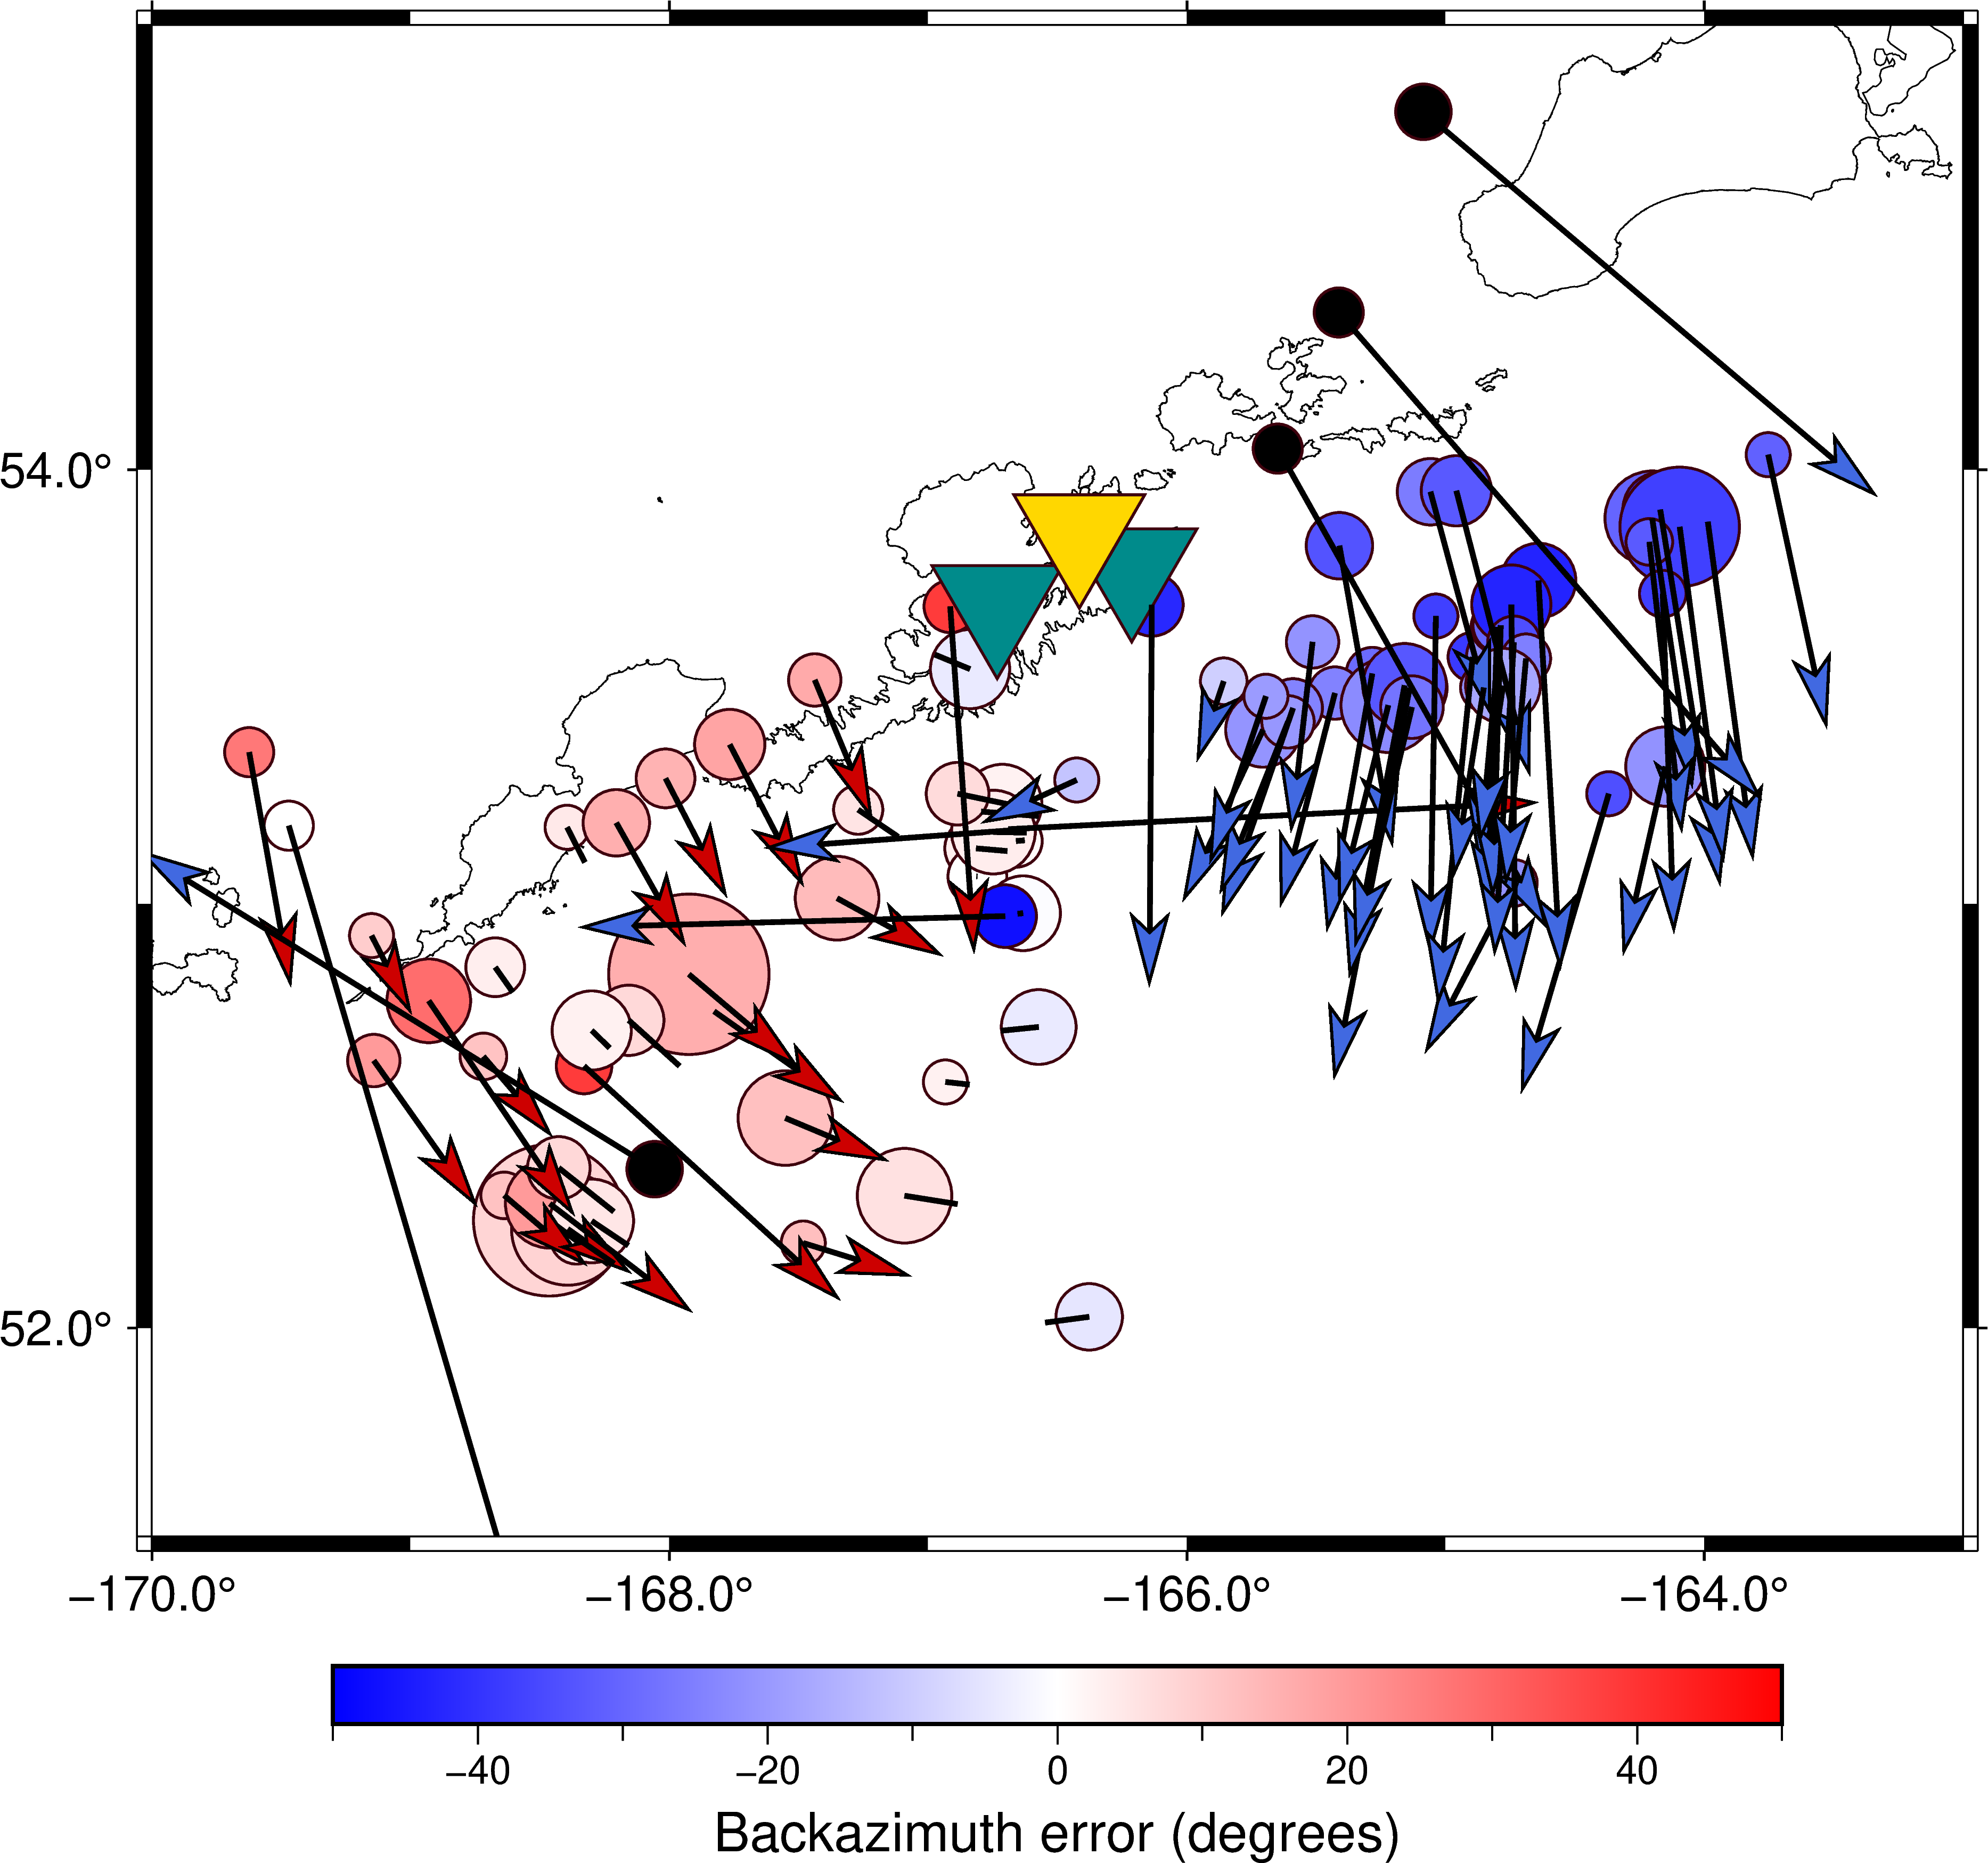

In [128]:
##---Begin basemap w/ AK eqs, stations, and boxes---##
fig = pygmt.Figure()
array_lat_2a = 53.6949 #Lat for sta 2A04
array_lon_2a = -166.7333 #Lon for sta 2A04
array_lat_3a = 53.779 #Lat for sta 2A04
array_lon_3a = -166.2131 #Lon for sta 2A04
array_lat_pom = 53.8566 #Lat for sta 2A04
array_lon_pom = -166.4161 #Lon for sta 2A04
array_lats = [53.6949, 53.779, 53.8566]
array_lons = [-166.7333,-166.2131,-166.4161]
sizes = [200,200,200]
region=[-180,-160,48,60]
#region=[-170,-163,51,55.5]
region_rect = "-170/51.5/-163/55r"  #rectangular designation for plotted mat
#projection = 'S210/90/8i'
projection = "M4i"
projection="M0/0/12c"


pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_PEN='1p')
fig.basemap(frame=True, region=region_rect, projection=projection)
fig.coast(dcw="US.AK+p0.25p")


pygmt.makecpt(cmap='polar', series = [-50,50])
fig.plot(x=comb['eq_longitude'], y=comb['eq_latitude'], size=0.05*(1.8**comb['eq_magnitude']),
         style="cc", pen='0.5p,#3e000d',cmap=True, fill = comb['baz_error'])

fig.plot(x = array_lons,
         y = array_lats,
         style = "i1c",pen = '0.5p,#3e000d', size = sizes, fill = 'cyan4')

fig.plot(x=pos_error['lon'],
        y=pos_error['lat'],
        direction = [pos_error['vec_direction'],0.06*pos_error['baz_error']],
        #direction = [baz_array_pygmt, [length]],
        style="v0.5c+ea",
        fill = "red3",
        #fill="royalblue",
        pen="1.0p")
        #label = "Array backazimuth abs. power")

fig.plot(x=neg_error['lon'],
        y=neg_error['lat'],
        direction = [neg_error['vec_direction']-180,0.06*neg_error['baz_error']],
        #direction = [baz_array_pygmt, [length]],
        style="v0.5c+ea",
        #fill = "cyan4",
        fill="royalblue",
        pen="1.0p")

fig.plot(x = array_lon_pom,
         y = array_lat_pom,
         style = "i1c",pen = '0.5p,#3e000d', size = [400], fill = 'gold1')
         
#fig.plot(x = array_lon_3a,
        # y = array_lat_3a,
         #style = "t0.4c", fill = 'steelblue1')
#fig.plot(x = array_lon_pom,
         #y = array_lat_pom,
         #style = "t0.4c", fill = 'steelblue1')

fig.colorbar(frame="xaf+lBackazimuth error (degrees)")

fig.savefig('/Users/cadequigley/Downloads/Research/paper_figures/unalaska_baz_vectors_map_'+array+'_start.png', transparent=True, dpi=720)
fig.show(dpi=720)

### Slowness map

#### Calculating slowness values for dataset

In [314]:
### Should be pulled in above
from obspy.geodetics import gps2dist_azimuth
from obspy.geodetics import kilometers2degrees

from obspy.taup import TauPyModel
from obspy.taup import taup_create
mod = 'japan_1d' #pavdut, iasp91, japan_1d, ak135
#model = TauPyModel(model="pavdut")
model = TauPyModel(model=mod)

lat_2a = 53.69619999999999
lon_2a = -166.7326
lat_3a = 53.77933636363636
lon_3a = -166.21232727272726
lat_pom = 53.85690833333333
lon_pom = -166.41502499999999

array_lats = [lat_2a, lat_3a, lat_pom]
array_lons = [lon_2a, lon_3a, lon_pom]
station_names = ['2A', '3A', 'POM']

#df = pd.read_csv('/Users/cadequigley/Downloads/completed_runs_v2/record_sections_picks/POM_epic_times.csv')
#df = df.rename(columns={'eq_name': 'event_id'})
df1 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
df1 = comb
eq_lats = df1['eq_latitude'].to_numpy()
eq_lons = df1['eq_longitude'].to_numpy()
eq_depths = df1['eq_depth(km)'].to_numpy()
event_ids = df1['event_id'].to_numpy()

slowness_list = []
incident_list = []
trace_vel_list = []
takeoff_list = []
takeoff_from_depth_list = []

for i in range(len(station_names)):
    array = station_names[i]
    arr_lat = array_lats[i]
    arr_lon = array_lons[i]
    slowness = []
    incident = []
    trace_vel = []
    takeoffs = []
    takeoff_from_depth = []
    for j in range(len(eq_lats)):
        eq_lat = eq_lats[j]
        eq_lon = eq_lons[j]
        depth = eq_depths[j]
        distance,baz,az = gps2dist_azimuth(arr_lat,arr_lon,eq_lat,eq_lon)
        distance = distance/1000

        dist_deg = kilometers2degrees(distance)

        #use 1d model to get incident angle/slowness
        arrivals_p = model.get_travel_times(source_depth_in_km=depth,
                                  distance_in_degree=dist_deg,
                                  phase_list = ["P","p"])

        arr = arrivals_p[0]
        ptime = arr.time
        angle = arr.incident_angle
        takeoff = arr.takeoff_angle
        takeoffs.append(takeoff)
        if mod == 'iasp91':
            vh = 5.8/(np.sin(np.deg2rad(angle))) #iasp91 surface velocity: 5.8
        else:
            vh = 3.05/(np.sin(np.deg2rad(angle))) #pavdut surface velocity: 3.05

        if mod == 'iasp91':
            vh = 5.8/(np.sin(np.deg2rad(angle))) #iasp91 surface velocity: 5.8
        elif mod == 'japan_1d':
            vh = 4.8/(np.sin(np.deg2rad(angle))) #japan_1D surface velocity: 5.8
        elif mod == 'ak135':
            vh = 5.8/(np.sin(np.deg2rad(angle)))
        else:
            vh = 3.05/(np.sin(np.deg2rad(angle))) #pavdut surface velocity: 3.05
        slow = 1/vh
        slowness.append(slow)
        incident.append(angle)
        trace_vel.append(vh)
        takeoff_from_depth.append(np.rad2deg(np.arctan(distance/depth)))

    slowness_list.append(slowness)
    incident_list.append(incident)
    trace_vel_list.append(trace_vel)
    takeoff_list.append(takeoffs)
    takeoff_from_depth_list.append(takeoff_from_depth)


baz_2a = []
az_2a = []
dist_2a = []
baz_3a = []
az_3a = []
dist_3a = []
baz_pom = []
az_pom = []
dist_pom = []

for i in range(len(eq_lats)):
    lat = eq_lats[i]
    lon = eq_lons[i]
    #2A-------------
    dist,baz,az = gps2dist_azimuth(lat,lon,lat_2a,lon_2a)
    baz_2a.append(az)
    az_2a.append(baz)
    dist_2a.append(dist/1000)
    #3A-------------
    dist,baz,az = gps2dist_azimuth(lat,lon,lat_3a,lon_3a)
    baz_3a.append(az)
    az_3a.append(baz)
    dist_3a.append(dist/1000)
    #POM-------------
    dist,baz,az = gps2dist_azimuth(lat,lon,lat_pom,lon_pom)
    baz_pom.append(az)
    az_pom.append(baz)
    dist_pom.append(dist/1000)

baz_2a = np.array(baz_2a)
baz_3a = np.array(baz_3a)
baz_pom = np.array(baz_pom)

#df = pd.DataFrame(slowness_list[0], columns)
df = pd.DataFrame({
        '2A_'+mod+'_slowness': slowness_list[0],
        '3A_'+mod+'_slowness': slowness_list[1],
        'POM_'+mod+'_slowness': slowness_list[2],
        '2A_'+mod+'_incidence': incident_list[0],
        '3A_'+mod+'_incidence': incident_list[1],
        'POM_'+mod+'_incidence': incident_list[2],
        '2A_'+mod+'_trace_vel': trace_vel_list[0],
        '3A_'+mod+'_trace_vel': trace_vel_list[1],
        'POM_'+mod+'_trace_vel': trace_vel_list[2],
        '2A_'+mod+'_takeoff': takeoff_list[0],
        '3A_'+mod+'_takeoff': takeoff_list[1],
        'POM_'+mod+'_takeoff': takeoff_list[2],
        '2A_depth_takeoff': takeoff_from_depth_list[0],
        '3A_depth_takeoff': takeoff_from_depth_list[1],
        'POM_depth_takeoff': takeoff_from_depth_list[2],
        '2A_baz': baz_2a,
        '3A_baz': baz_3a,
        'POM_baz': baz_pom,
        '2A_az': az_2a,
        '3A_az': az_2a,
        'POM_az': az_2a,
        '2A_dist': dist_2a,
        '3A_dist': dist_3a,
        'POM_dist': dist_pom,
        'event_id': event_ids
        
    })

df.to_csv('/Users/cadequigley/Downloads/Research/paper_figures/'+mod+'_values_9c_arrays.csv')        

#### Slowness Map

In [252]:
### calculate slowness error
#mod = 'japan_1d'
if analysis == 'lts':
    slow_meas = 1/comb['trace_vel'].to_numpy()
else:
    slow_meas = comb['slow'].to_numpy()
slow_1d = comb[array+'_'+mod+'_slowness'].to_numpy() #slowness using japan 1D vel model
#slow_1d = np.sin(np.deg2rad(comb[array+'_'+mod+'_incidence']))/3.5 #testing to see what brings it up to 0 (vertical shift)
comb['slow_error'] = slow_1d - slow_meas #add additional term to get to center around 0+ 0.05
#temp = pd.merge(df, comb, on='event_id', how='inner')
temp = comb
pos_error = pd.DataFrame(temp[temp['slow_error']>= 0])
neg_error = pd.DataFrame(temp[temp['slow_error']<= 0])

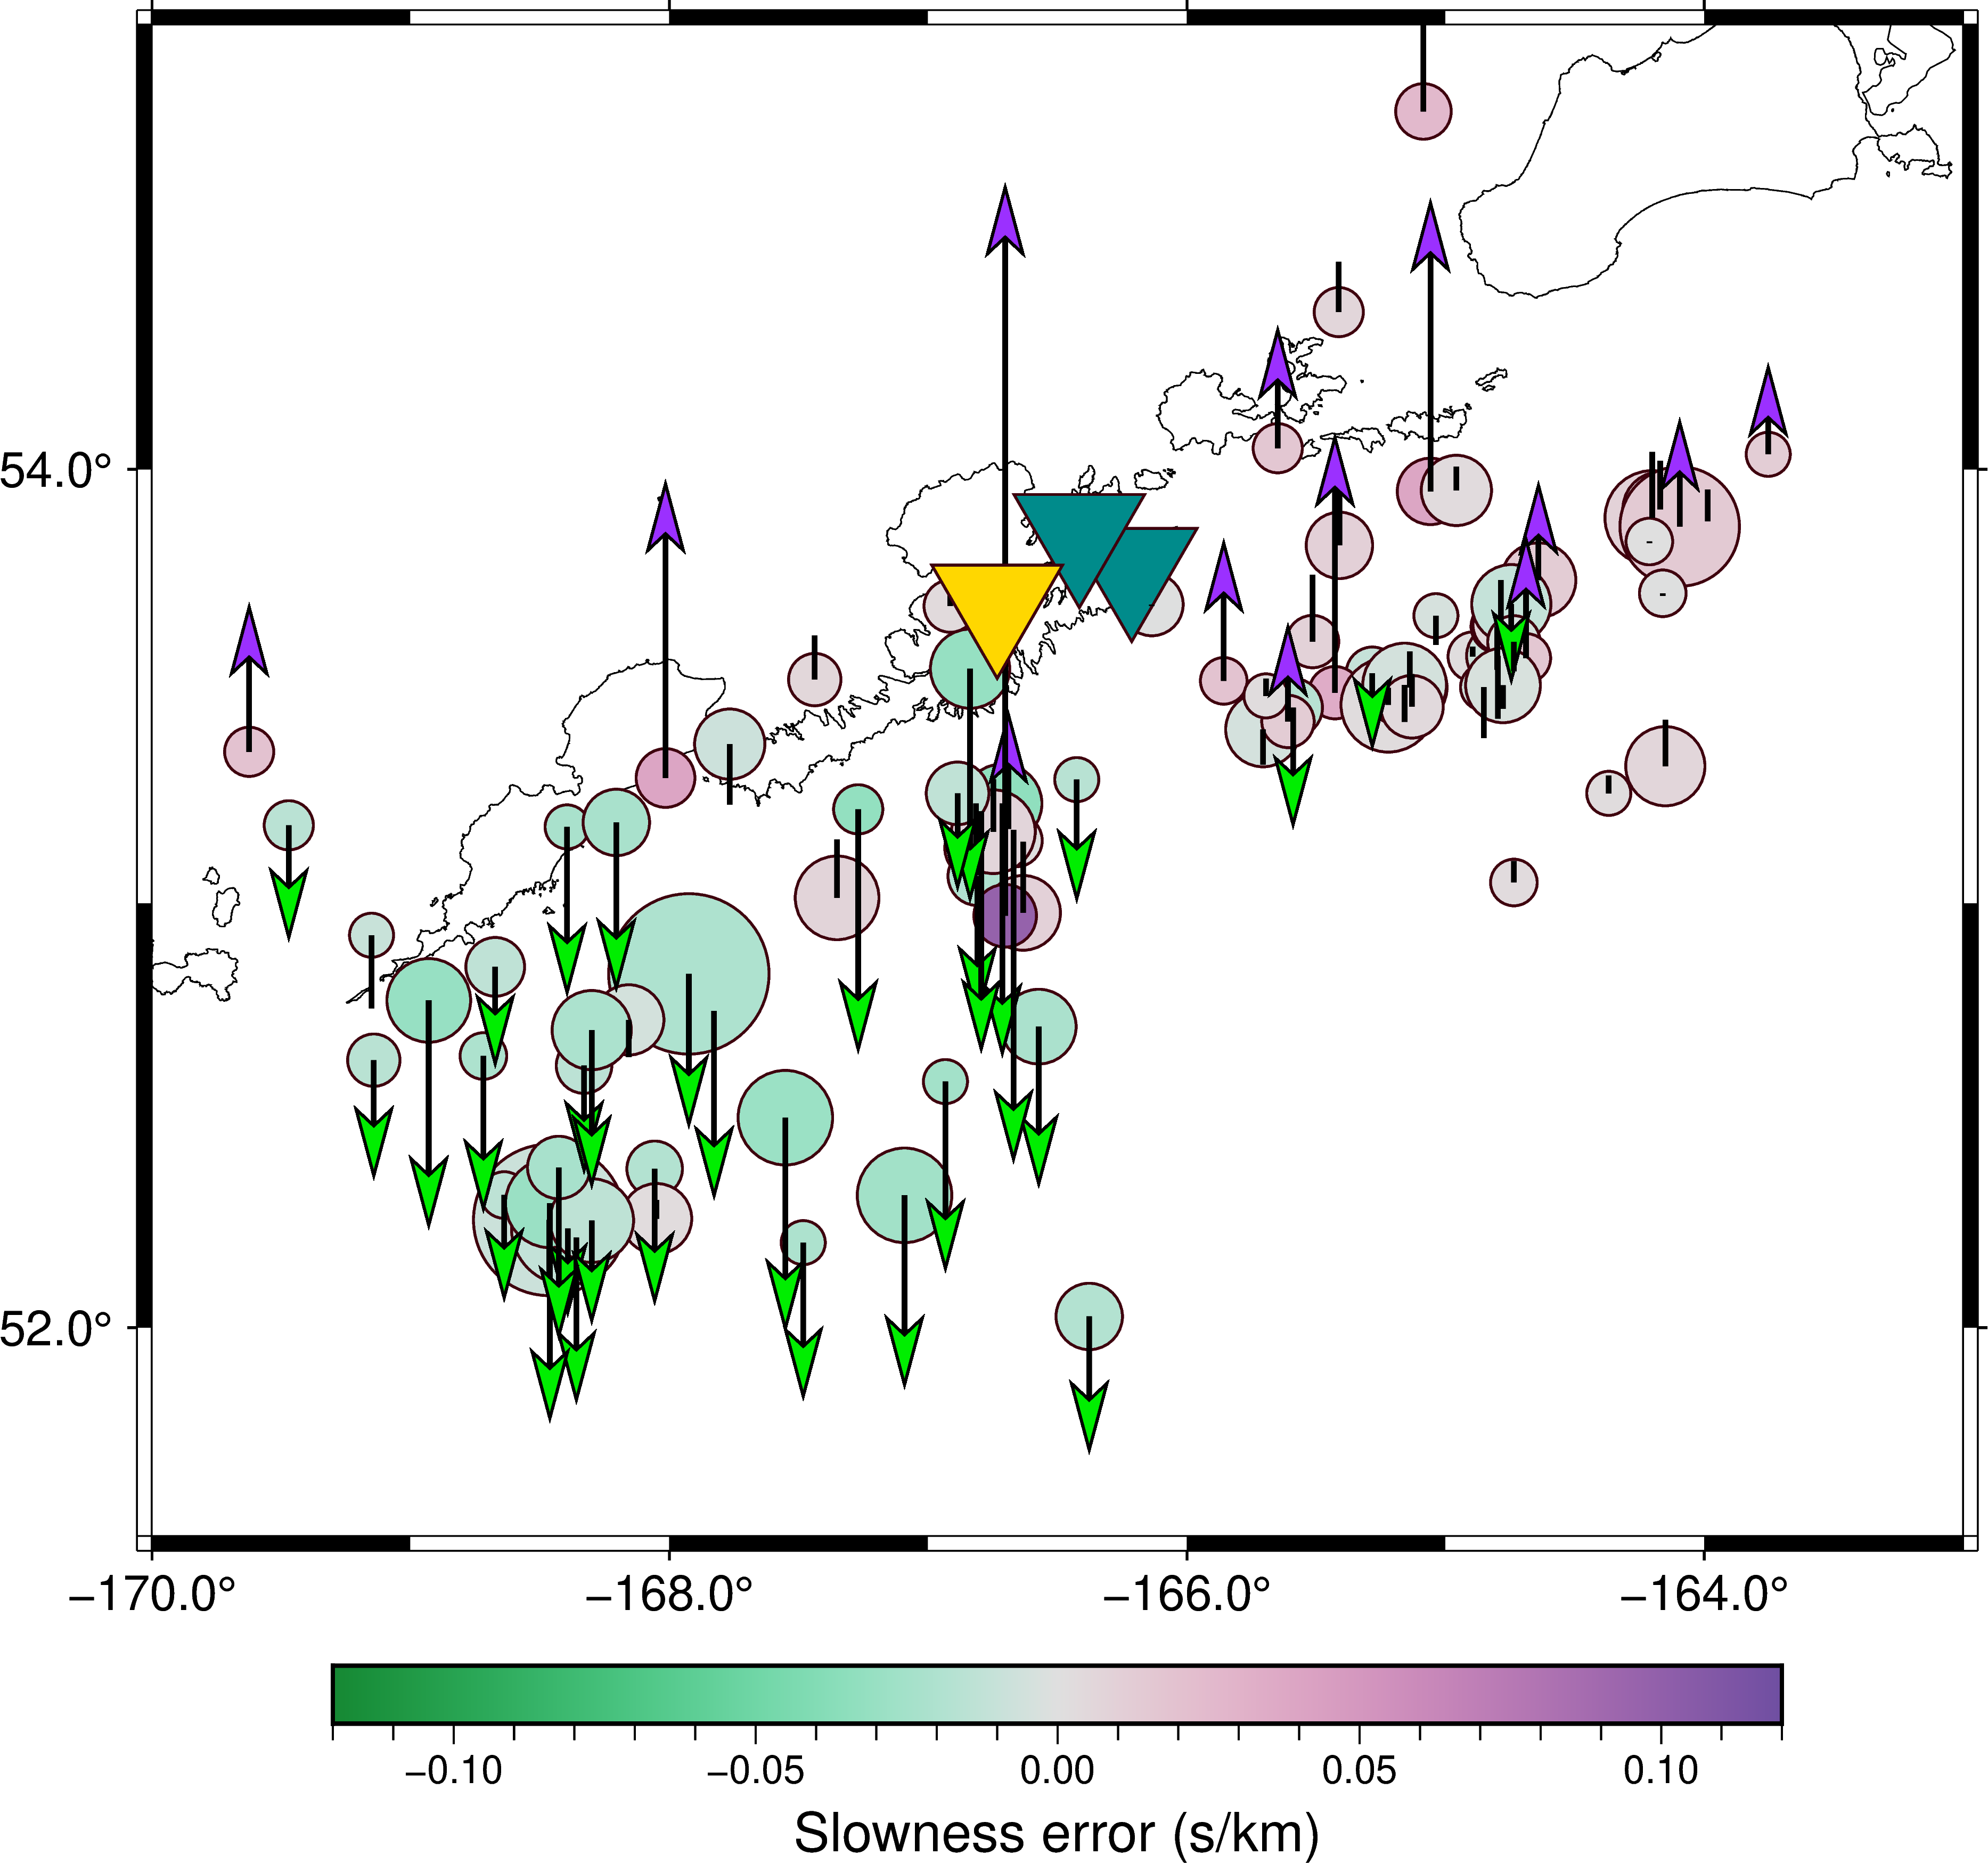

In [253]:
##---Begin basemap w/ AK eqs, stations, and boxes---##
fig = pygmt.Figure()
array_lat_2a = 53.6949 #Lat for sta 2A04
array_lon_2a = -166.7333 #Lon for sta 2A04
#array_lat_3a = 53.779 #Lat for sta 2A04
#array_lon_3a = -166.2131 #Lon for sta 2A04
#array_lat_pom = 53.8566 #Lat for sta 2A04
#array_lon_pom = -166.4161 #Lon for sta 2A04
array_lats = [53.6949, 53.779, 53.8566]
array_lons = [-166.7333,-166.2131,-166.4161]
sizes = [200,200,200]
region=[-180,-160,48,60]
#region=[-170,-163,51,55.5]
region_rect = "-170/51.5/-163/55r"  #rectangular designation for plotted mat
#projection = 'S210/90/8i'
projection = "M4i"
projection="M0/0/12c"


pygmt.config(FORMAT_GEO_MAP="ddd.x", MAP_FRAME_PEN='1p')
fig.basemap(frame=True, region=region_rect, projection=projection)
fig.coast(dcw="US.AK+p0.25p")

cpt_file = '/Users/cadequigley/Downloads/green-purple.cpt'
pygmt.makecpt(cmap=cpt_file, series = [-0.12,0.12])#red2green
###Plot earthquakes
fig.plot(x=temp['eq_longitude'], y=temp['eq_latitude'], size=0.05*(1.8**temp['eq_magnitude']),
         style="cc", pen='0.5p,#3e000d',cmap=True, fill = temp['slow_error'])
###Plot arrays
fig.plot(x = array_lons,
         y = array_lats,
         style = "i1c",pen = '0.5p,#3e000d', size = sizes, fill = 'cyan4')

###Plot slowness error
fig.plot(x=pos_error['eq_longitude'],
        y=pos_error['eq_latitude'],
        direction = [90*np.ones(len(pos_error)),50*pos_error['slow_error']],
        #direction = [baz_array_pygmt, [length]],
        style="v0.5c+ea",
        fill = "purple1",
        #fill="royalblue",
        pen="1.0p")
        #label = "Array backazimuth abs. power")

fig.plot(x=neg_error['eq_longitude'],
        y=neg_error['eq_latitude'],
        direction = [90*np.ones(len(neg_error)),50*neg_error['slow_error']],
        #direction = [baz_array_pygmt, [length]],
        style="v0.5c+ea",
        #fill = "cyan4",
        fill="green2",
        pen="1.0p")


### Plot array where data is coming from
fig.plot(x = array_lon_2a,
         y = array_lat_2a,
         style = "i1c",pen = '0.5p,#3e000d', size = [400], fill = 'gold1')
         
#fig.plot(x = array_lon_3a,
        # y = array_lat_3a,
         #style = "t0.4c", fill = 'steelblue1')
#fig.plot(x = array_lon_pom,
         #y = array_lat_pom,
         #style = "t0.4c", fill = 'steelblue1')

fig.colorbar(frame="xaf+lSlowness error (s/km)")

#fig.savefig('/Users/cadequigley/Downloads/Research/paper_figures/slowness_vectors_'+array+'_start.png', transparent=True, dpi=720)
fig.show(dpi=720)

### Slowness error plot

In [115]:
df.columns

Index(['Unnamed: 0_x', '2A_japan_1d_slowness', '3A_japan_1d_slowness',
       'POM_japan_1d_slowness', '2A_japan_1d_incidence',
       '3A_japan_1d_incidence', 'POM_japan_1d_incidence',
       '2A_japan_1d_trace_vel', '3A_japan_1d_trace_vel',
       'POM_japan_1d_trace_vel', '2A_japan_1d_takeoff', '3A_japan_1d_takeoff',
       'POM_japan_1d_takeoff', '2A_depth_takeoff', '3A_depth_takeoff',
       'POM_depth_takeoff', '2A_baz', '2A_az', '3A_az', 'POM_az', '3A_baz',
       'POM_baz', '2A_dist', '3A_dist', 'POM_dist', 'event_id', 'Unnamed: 0_y',
       'eq_depth(km)', 'eq_magnitude', 'eq_latitude', 'eq_longitude',
       'eq_origin_time', 'hypo_distance_2A(km)', 'epi_distance_2A(km)',
       'hypo_distance_3A(km)', 'epi_distance_3A(km)', 'hypo_distance_POM(km)',
       'epi_distance_POM(km)', '2A02', '3A05', 'POM11', 'array_2A_ppicks',
       'array_3A_ppicks', 'array_POM_ppicks', 'fwd_azimuth_2a',
       'fwd_azimuth_3a', 'fwd_azimuth_pom', 'Unnamed: 0', 'window_length',
       'freq_max

In [238]:
japan.columns

Index(['Unnamed: 0', '2A_japan_1d_slowness', '3A_japan_1d_slowness',
       'POM_japan_1d_slowness', '2A_japan_1d_incidence',
       '3A_japan_1d_incidence', 'POM_japan_1d_incidence',
       '2A_japan_1d_trace_vel', '3A_japan_1d_trace_vel',
       'POM_japan_1d_trace_vel', '2A_japan_1d_takeoff', '3A_japan_1d_takeoff',
       'POM_japan_1d_takeoff', '2A_depth_takeoff', '3A_depth_takeoff',
       'POM_depth_takeoff', '2A_baz', '2A_az', '3A_az', 'POM_az', '3A_baz',
       'POM_baz', '2A_dist', '3A_dist', 'POM_dist', 'event_id'],
      dtype='object')

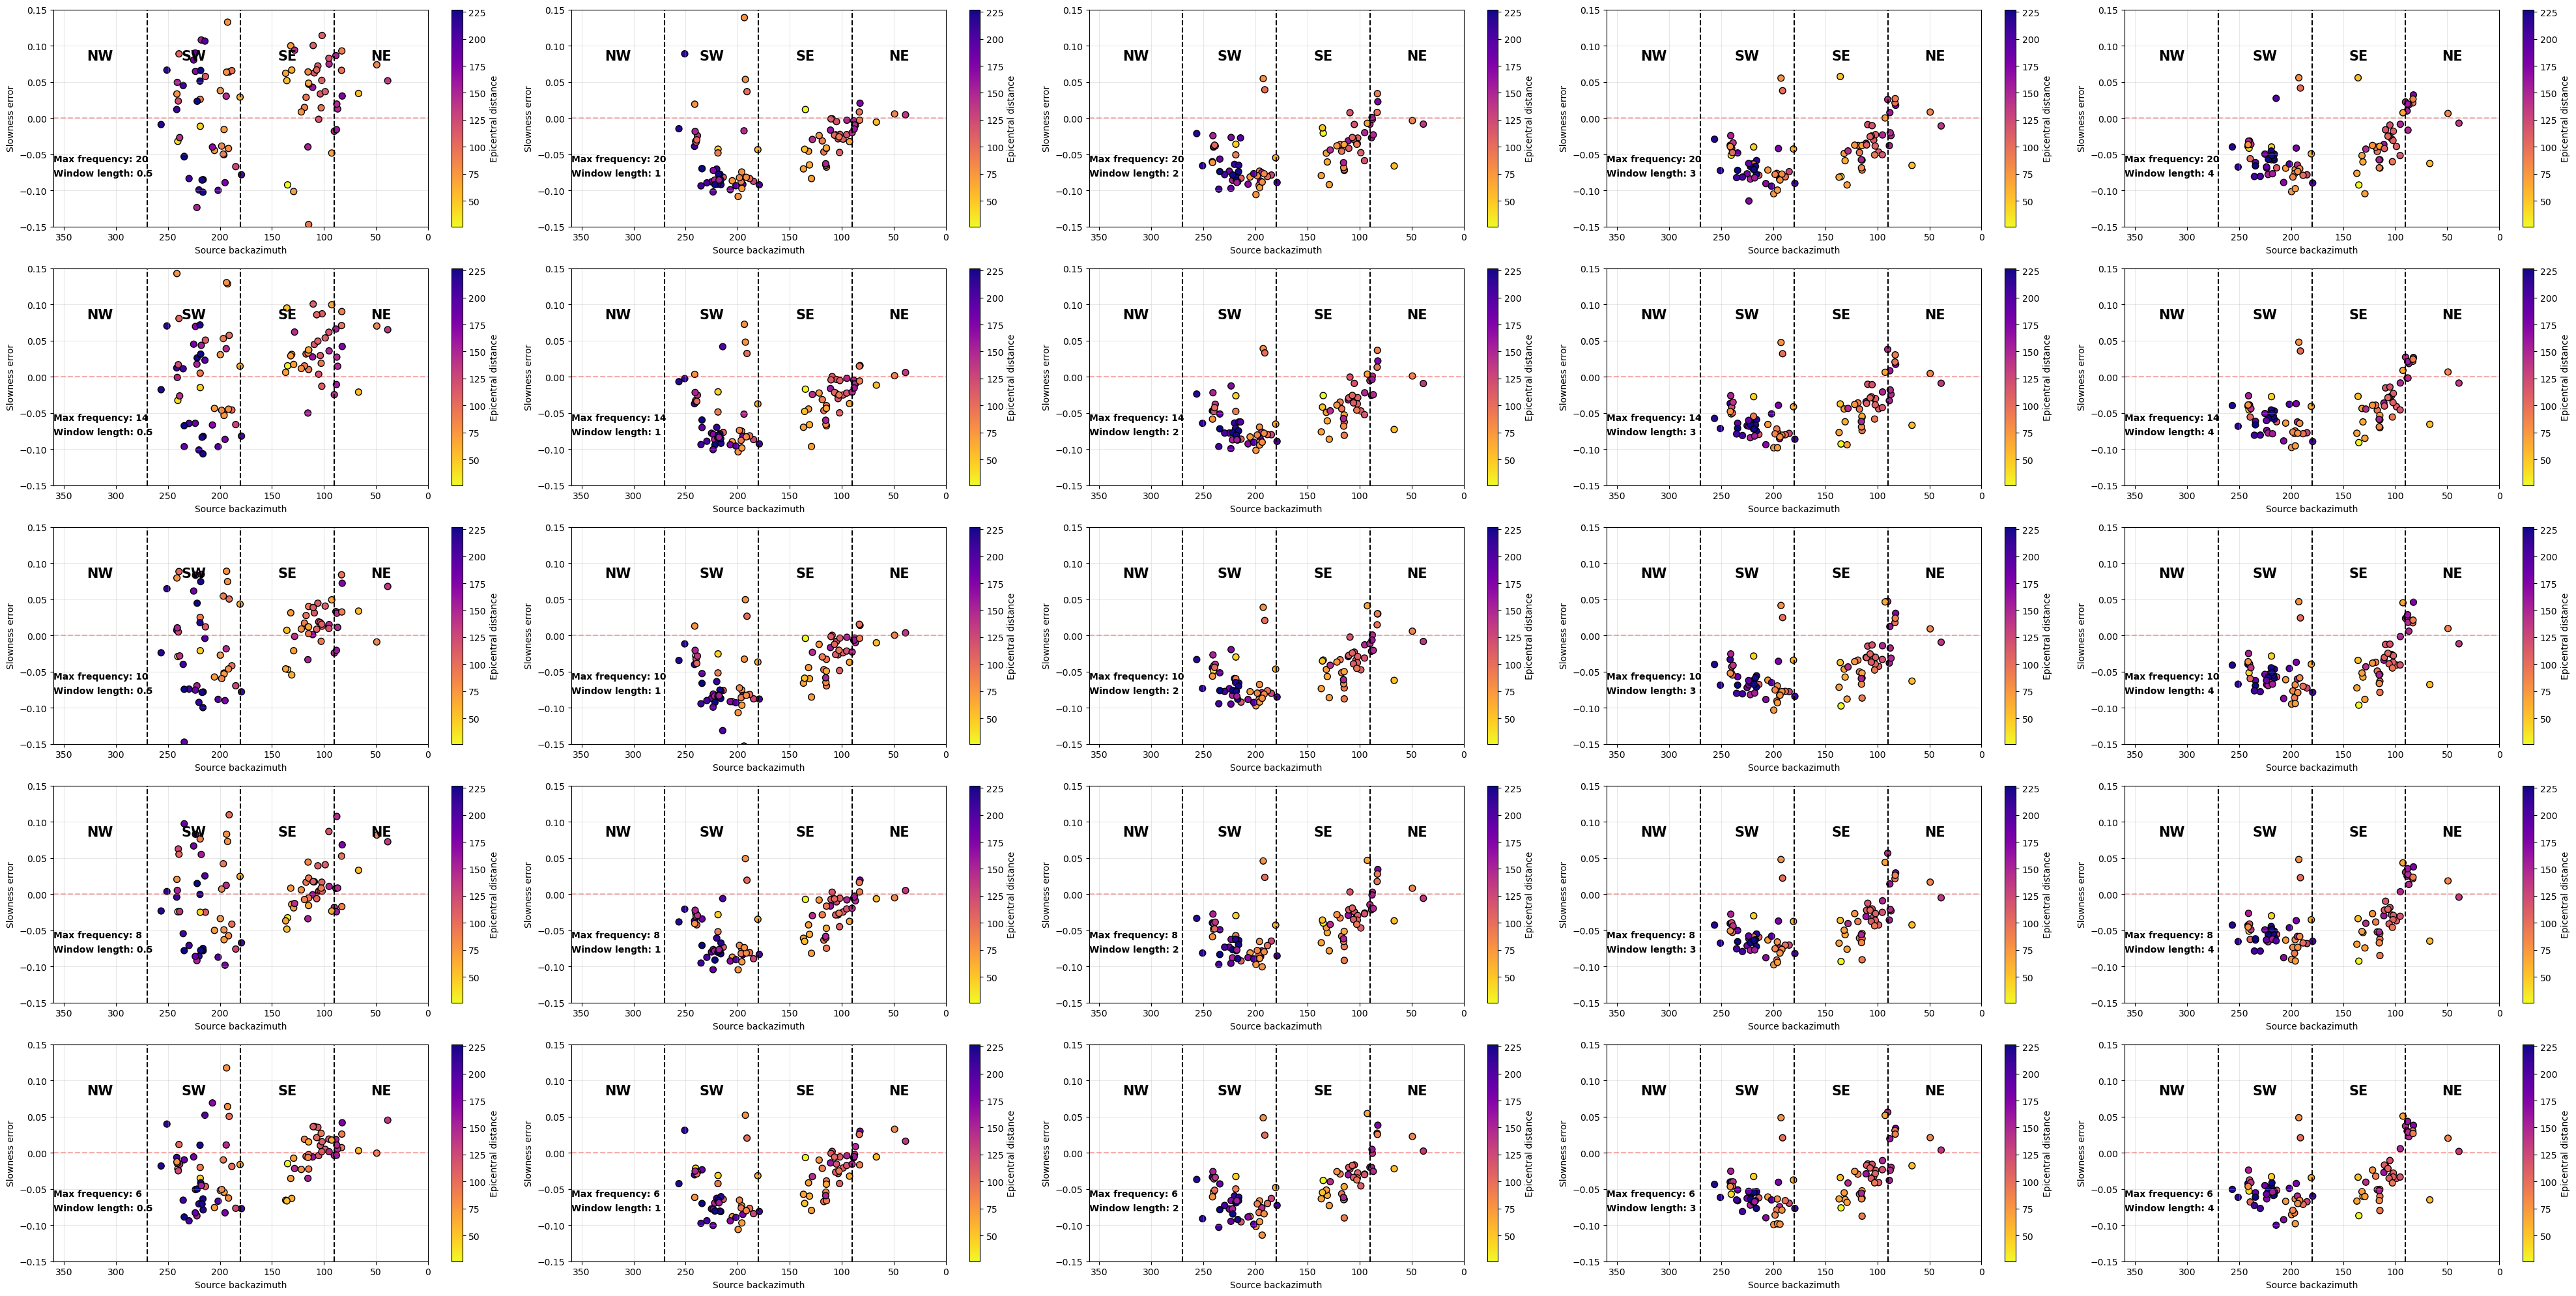

In [237]:
## BAZ GRID PLOTS ##########################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#INPUT PARAMETERS
array = 'POM' #'POM', '3A', "2A"
array1 = 'pom' #'pom', '3a'
analysis = 'lts' #fk, lts
timing = 'half' #quarter, half, start
y_variable = 'slow' # baz, slow

path = '/Users/cadequigley/Downloads/completed_runs_v2/array_analysis/05s_window/window_freq_analysis/'

#PULLING DATA
if analysis == 'lts':
    if timing =='start':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_epic_start.csv')
    elif timing == 'quarter':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_epic_start.csv')
    else:
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_epic_start.csv')
        
else:
    if timing =='start':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_pick_start.csv')
    elif timing == 'quarter':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_pick_start.csv')
    else:
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_pick_start.csv')

df2 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
#df2 = pd.read_csv("/Users/cadequigley/Downloads/Research/ls_time_plots/spatial_example_baz_errors.csv")
#snell = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/'+array+'_3Dsnell_dip_'+dip+'_strike_'+strike+'.csv')
japan = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/japan1d_values_9c_arrays.csv')
comb = pd.merge(japan, df2, on='event_id', how='inner')



## plot------------------
window_lengths = [0.5,1,2,3,4]
max_freqs = [20,14,10,8,6]
fig,ax = plt.subplots(nrows = 5, ncols = 5, figsize = (8*5,4*5))
for i in range(len(max_freqs)):

    max_freq = max_freqs[i]
    for j in range(len(window_lengths)):
        window_length = window_lengths[j]
        
        df2 = pd.DataFrame(df1[(df1['window_length'] == window_length)])
        df3 = pd.DataFrame(df2[(df2['freq_max'] == max_freq)])
        df = pd.merge(comb, df3, on='event_id', how='inner')

        ### calculate slowness error-----------------------------------------
        mod = 'japan_1d'
        if analysis == 'lts':
            slow_meas = 1/df['trace_vel'].to_numpy()
        else:
            slow_meas = df['slow'].to_numpy()
        slow_1d = df[array+'_'+mod+'_slowness'].to_numpy() #slowness using japan 1D vel model
        df['slow_error'] = slow_1d - slow_meas #add additional term to get to center around 0+ 0.05

        #print(len(df))
        
            

        sc = ax[i,j].scatter(df[array+'_baz'], df[y_variable+'_error'],c = df['epi_distance_'+array+'(km)'], s = 50, cmap = 'plasma_r', edgecolors = 'black')
        #ax[i,j].plot(x,y, color = 'skyblue')
        ax[i,j].axhline(y=0, color = 'red', linestyle = '--', alpha = 0.3)
        ax[i,j].set_xlabel('Source backazimuth')
        ax[i,j].set_ylabel('Backazimuth error')
        plt.colorbar(sc, label = 'Epicentral distance')

        ax[i,j].set_xlim(0, 360)
    #ax[i].set_ylim(-175,175)
        if y_variable == 'baz':
            ax[i,j].set_ylabel('Backazimuth error')
            ax[i,j].set_ylim(-60,60)
            ax[i,j].text(45,45, "NE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
            ax[i,j].text(135,45, "SE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
            ax[i,j].text(225,45, "SW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
            ax[i,j].text(315,45, "NW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
            ax[i,j].text(360,-30, 'Window length: '+str(window_length),color = 'black', fontweight = 'bold',fontsize = 10, ha='left')
            ax[i,j].text(360,-40, 'Max frequency: '+str(max_freq),color = 'black', fontweight = 'bold',fontsize = 10, ha='left')
        else:
            ax[i,j].set_ylabel('Slowness error')
            ax[i,j].set_ylim(-0.15,0.15)
            

            ax[i,j].text(45,0.08, "NE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
            ax[i,j].text(135,0.08, "SE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
            ax[i,j].text(225,0.08, "SW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
            ax[i,j].text(315,0.08, "NW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
            ax[i,j].text(360,-0.08, 'Window length: '+str(window_length),color = 'black', fontweight = 'bold',fontsize = 10, ha='left')
            ax[i,j].text(360,-0.06, 'Max frequency: '+str(max_freq),color = 'black', fontweight = 'bold',fontsize = 10, ha='left')
        ax[i,j].axvline(x=90, color = 'black', linestyle = '--')
        ax[i,j].axvline(x=180, color = 'black', linestyle = '--')
        ax[i,j].axvline(x=270, color = 'black', linestyle = '--')
        ax[i,j].grid(alpha = 0.3)
        ax[i,j].invert_xaxis()

plt.tight_layout()
plt.show()
#print(len(df))
#len((df1))

a = 0.0014402820352162333
b = 0.014748582909366172
phi (deg) = 198.825050966638


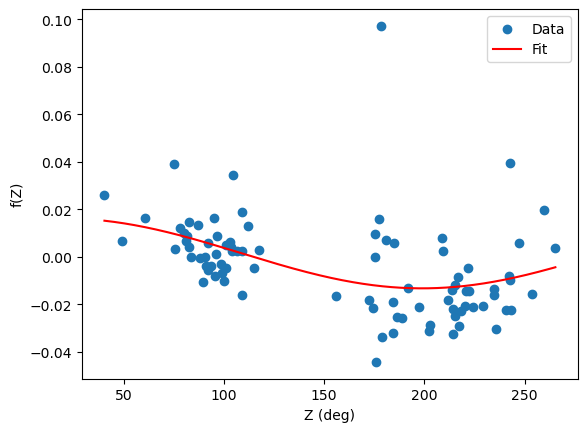

In [254]:
### Niazi style cosine fit--------------------------------
import numpy as np
from scipy.optimize import curve_fit

# Model: a - b*cos(Z - phi)
def cos_model(Z_deg, a, b, phi_deg):
    Z = np.radians(Z_deg)
    phi = np.radians(phi_deg)
    return a - b * np.cos(Z - phi)

# Example initial guesses
p0 = [1.0, 10.0, 180.0]   # a, b, phi guesses

Z_data = temp[array+'_baz']
y_data =  temp['slow_error']

params, cov = curve_fit(cos_model, Z_data, y_data, p0=p0)

a_fit, b_fit, phi_fit = params
print("a =", a_fit)
print("b =", b_fit)
print("phi (deg) =", phi_fit)

Z_fit = np.linspace(min(Z_data), max(Z_data), 500)
y_fit = cos_model(Z_fit, *params)


import matplotlib.pyplot as plt

plt.scatter(Z_data, y_data, label='Data')
plt.plot(Z_fit, y_fit, 'r-', label='Fit')
plt.xlabel("Z (deg)")
plt.ylabel("f(Z)")
plt.legend()
plt.show()



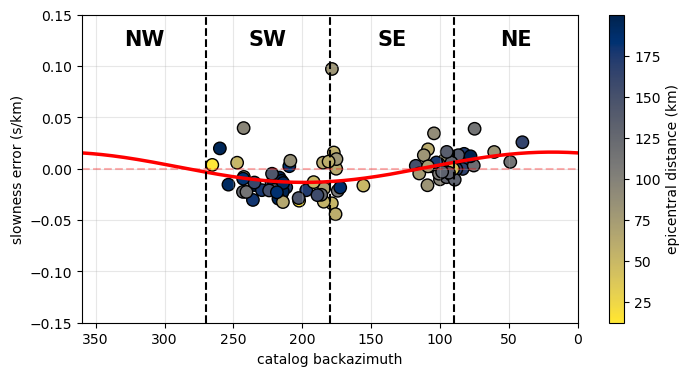

In [255]:
import matplotlib.pyplot as plt
#### Difference

plot_type = 'slowness' #slowness, trace_vel

#array = '2A'
fig,ax = plt.subplots(figsize = (8,4))
if plot_type == 'slowness':
    y = temp[array+'_'+mod+'_'+plot_type] #"Real"
    #y = temp[]
    if analysis == 'lts':
        y1 = 1/temp['trace_vel'] #array
    else:
        y1 = temp['slow']
    y = y-y1 #difference
    y = temp['slow_error']
    ax.set_xlim(0,360)
    ax.set_ylim(-0.15, 0.15)
    ax.text(45,0.12, "NE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
    ax.text(135,0.12, "SE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
    ax.text(225,0.12, "SW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
    ax.text(315,0.12, "NW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
    ax.set_ylabel('Slowness error (s/km)')
    #ax.set_title('Array '+array+' slowness error')
else:
    y = temp[array+'_'+mod+'_'+plot_type]
    y1 = temp['trace_vel']

    y = y-y1
    #y = temp['slow_error']
    ax.set_xlim(0,360)
    ax.set_ylim(-25,25)
    ax.text(45,23, "NE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
    ax.text(135,23, "SE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
    ax.text(225,23, "SW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
    ax.text(315,23, "NW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
    ax.set_ylabel('Trace velocity error (km/s)')
    #ax.set_title('Array '+array+' trace velocity error')

#c = temp['eq_depth(km)']
c = temp[array+'_dist']
#c = temp['eq_magnitude']

Z_fit = np.linspace(0, 360, 500)
y_fit = cos_model(Z_fit, *params)

#y = y+ 0.05
#sc = ax.scatter(temp[array+'_baz'], y, c =  temp['epi_distance_'+array+'(km)'], cmap = 'plasma_r', edgecolors = 'black')
sc = ax.scatter(temp[array+'_baz'], y, c =  c, cmap = 'cividis_r', edgecolors = 'black', s= 80)
ax.plot(Z_fit, y_fit, 'r-', linewidth = 2.5)
#ax.text(45,45, "NE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
#ax.text(135,45, "SE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
#ax.text(225,45, "SW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
#ax.text(315,45, "NW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')

ax.axvline(x=90, color = 'black', linestyle = '--')
ax.axvline(x=180, color = 'black', linestyle = '--')
ax.axvline(x=270, color = 'black', linestyle = '--')
ax.axhline(y=0, color = 'red', linestyle = '--', alpha = 0.3)

ax.grid(alpha = 0.3)
ax.set_xlabel('catalog backazimuth')
ax.set_ylabel('slowness error (s/km)')
#ax.set_xlim(0,360)
#ax.set_ylim(-60,60)
#ax.set_title('Array '+array+' IASP91 slowness')
plt.colorbar(sc, label = 'epicentral distance (km)')

ax.invert_xaxis()

#plt.savefig('./slow_error_2a_fk', transparent=True, dpi = 720)
plt.show()


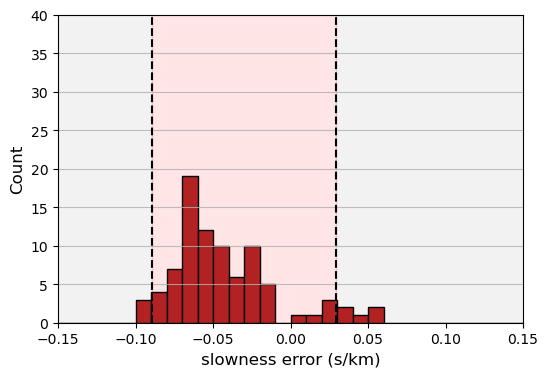

0.11844068020996519


In [103]:
fig, ax = plt.subplots(figsize=(6, 4,))

#corrected = df_measured['baz_error'].to_numpy() #no correction
#corrected = df_measured['baz_error'].to_numpy() - temp_deflect['2A_baz_error'].to_numpy() #snells 3D
#corrected = df_measured['baz_error'].to_numpy() - y_fit #niazi

corrected = y
hist_params = {
    'bins': 30, #0.01 s/km per bin
    'range': (-0.15, 0.15),
    'edgecolor': 'black'
    }
    
#corrected = corrected.dropna()
#b = baz_hist['baz_error']
c = corrected

ax.axvspan(-0.2,np.quantile(c, 0.05), color = 'gray',alpha = 0.1)

ax.axvspan(np.quantile(c, 0.95),0.2, color = 'gray',alpha = 0.1)
ax.axvspan(np.quantile(c, 0.05),np.quantile(c,0.95), color = 'red',alpha = 0.1)

ax.hist(c, color = 'firebrick', **hist_params)

ax.set_xlabel('slowness error (s/km)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(axis='y', alpha=0.8)


ax.axvline(x=np.quantile(c, 0.95), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
ax.axvline(x=np.quantile(c, 0.05), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
range1 = (np.abs(np.quantile(c, 0.05))+np.abs(np.quantile(c, 0.95)))

                                        


ax.set_xlim(-0.15, 0.15)
ax.set_ylim(0, 40)
#ax.set_title('Array '+array+' Theoretical Backazimuth Deflection')

#plt.tight_layout()  # To adjust space between subplots
#plt.savefig('/Users/cadequigley/Downloads/histogram_ess.png', transparent=True)
#plt.savefig('./slow_error_distribution_fk.png', transparent=True, dpi = 720)
plt.show()
print(range1)

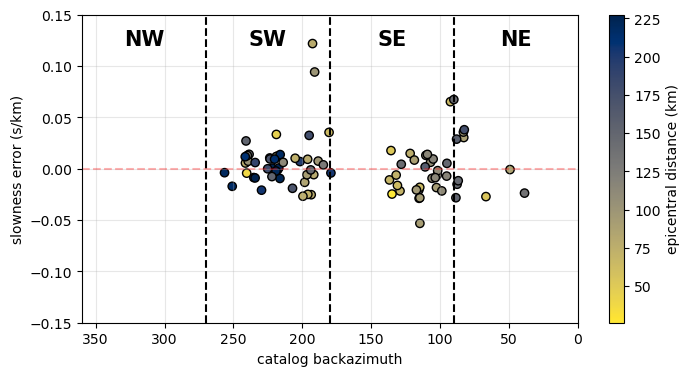

In [104]:
import matplotlib.pyplot as plt
#### Difference

y_fit = cos_model(Z_data, *params)

plot_type = 'slowness' #slowness, trace_vel

#array = '2A'
fig,ax = plt.subplots(figsize = (8,4))
if plot_type == 'slowness':
    y = temp[array+'_'+mod+'_'+plot_type] #"Real"
    #y = temp[]
    if analysis == 'lts':
        y1 = 1/temp['trace_vel'] #array
    else:
        y1 = temp['slow']
    y = y-y1 #difference
    y = temp['slow_error']
    ax.set_xlim(0,360)
    ax.set_ylim(-0.15, 0.15)
    ax.text(45,0.12, "NE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
    ax.text(135,0.12, "SE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
    ax.text(225,0.12, "SW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
    ax.text(315,0.12, "NW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
    ax.set_ylabel('Slowness error (s/km)')
    #ax.set_title('Array '+array+' slowness error')
else:
    y = temp[array+'_'+mod+'_'+plot_type]
    y1 = temp['trace_vel']

    y = y-y1
    #y = temp['slow_error']
    ax.set_xlim(0,360)
    ax.set_ylim(-25,25)
    ax.text(45,23, "NE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
    ax.text(135,23, "SE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
    ax.text(225,23, "SW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
    ax.text(315,23, "NW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
    ax.set_ylabel('Trace velocity error (km/s)')
    #ax.set_title('Array '+array+' trace velocity error')

#c = temp['eq_depth(km)']
c = temp[array+'_dist']

#y = y+ 0.05
#sc = ax.scatter(temp[array+'_baz'], y, c =  temp['epi_distance_'+array+'(km)'], cmap = 'plasma_r', edgecolors = 'black')
sc = ax.scatter(temp[array+'_baz'], y-y_fit, c =  c, cmap = 'cividis_r', edgecolors = 'black')
#ax.text(45,45, "NE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
#ax.text(135,45, "SE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
#ax.text(225,45, "SW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
#ax.text(315,45, "NW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')

ax.axvline(x=90, color = 'black', linestyle = '--')
ax.axvline(x=180, color = 'black', linestyle = '--')
ax.axvline(x=270, color = 'black', linestyle = '--')
ax.axhline(y=0, color = 'red', linestyle = '--', alpha = 0.3)

ax.grid(alpha = 0.3)
ax.set_xlabel('catalog backazimuth')
ax.set_ylabel('slowness error (s/km)')
#ax.set_xlim(0,360)
#ax.set_ylim(-60,60)
#ax.set_title('Array '+array+' IASP91 slowness')
plt.colorbar(sc, label = 'epicentral distance (km)')

ax.invert_xaxis()

#plt.savefig('./slow_error_2a', transparent=True, dpi = 720)
plt.show()


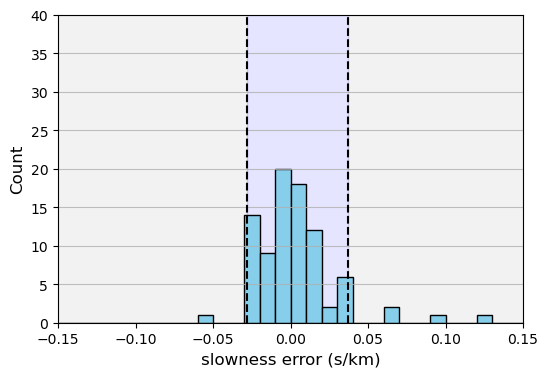

0.0652194755206901


In [105]:
fig, ax = plt.subplots(figsize=(6, 4,))

#corrected = df_measured['baz_error'].to_numpy() #no correction
#corrected = df_measured['baz_error'].to_numpy() - temp_deflect['2A_baz_error'].to_numpy() #snells 3D
#corrected = df_measured['baz_error'].to_numpy() - y_fit #niazi

corrected = y-y_fit
hist_params = {
    'bins': 30, #0.01 s/km per bin
    'range': (-0.15, 0.15),
    'edgecolor': 'black'
    }
    
#corrected = corrected.dropna()
#b = baz_hist['baz_error']
c = corrected

ax.axvspan(-0.2,np.quantile(c, 0.05), color = 'gray',alpha = 0.1)

ax.axvspan(np.quantile(c, 0.95),0.2, color = 'gray',alpha = 0.1)
ax.axvspan(np.quantile(c, 0.05),np.quantile(c,0.95), color = 'blue',alpha = 0.1)

ax.hist(c, color = 'skyblue', **hist_params)

ax.set_xlabel('slowness error (s/km)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(axis='y', alpha=0.8)


ax.axvline(x=np.quantile(c, 0.95), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
ax.axvline(x=np.quantile(c, 0.05), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
range1 = (np.abs(np.quantile(c, 0.05))+np.abs(np.quantile(c, 0.95)))

                                        


ax.set_xlim(-0.15, 0.15)
ax.set_ylim(0, 40)
#ax.set_title('Array '+array+' Theoretical Backazimuth Deflection')

#plt.tight_layout()  # To adjust space between subplots
#plt.savefig('/Users/cadequigley/Downloads/histogram_ess.png', transparent=True)
#plt.savefig('./slow_error_distribution_corrected_fk.png', transparent=True, dpi = 720)
plt.show()
print(range1)

In [698]:
temp.columns

Index(['Unnamed: 0_x', 'time', 'relpow', 'abspow', 'baz_obspy', 'slow',
       'baz_error', 'new_time', 'corrected_baz', 'window_length', 'event_id',
       'freq_min', 'freq_max', 'elapsed_time', 'Unnamed: 0_y', 'eq_depth(km)',
       'eq_magnitude', 'eq_latitude', 'eq_longitude', 'eq_origin_time',
       'hypo_distance_2A(km)', 'epi_distance_2A(km)', 'hypo_distance_3A(km)',
       'epi_distance_3A(km)', 'hypo_distance_POM(km)', 'epi_distance_POM(km)',
       '2A02', '3A05', 'POM11', 'array_2A_ppicks', 'array_3A_ppicks',
       'array_POM_ppicks', 'fwd_azimuth_2a', 'fwd_azimuth_3a',
       'fwd_azimuth_pom', 'Unnamed: 0', '2A_baz', '2A_baz_error_model',
       '2A_epicentral_distance', '2A_deflection_incident', '2A_slowness_error',
       '2A_japan_1d_slowness', '2A_japan_1d_incidence',
       '2A_japan_1d_trace_vel', 'slow_error'],
      dtype='object')

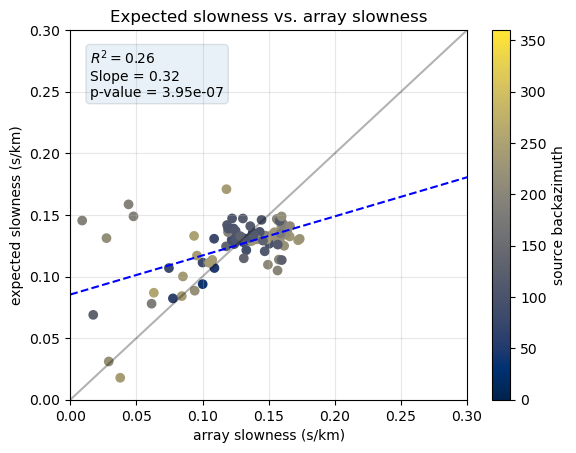

In [60]:
from scipy.stats import linregress
fig, ax = plt.subplots()
if analysis =='lts':
    x = 1/temp['trace_vel'].to_numpy() #array measured slowness
else:
    x = temp['slow'].to_numpy()
y = temp['2A_japan_1d_slowness'].to_numpy() # slowness from Japan 1D model
c = temp[array+'_baz'].to_numpy() #source backazimuth

x = x + y_fit
sc = ax.scatter(x,y, c= c, cmap = 'cividis',vmin = 0, vmax = 360 )
ax.plot(np.linspace(0,0.3,20), np.linspace(0,0.3,20), color = 'black', linestyle = '-', alpha = 0.3)

# Perform linear regression-----------------------------------------------------------
slope, intercept, r_value, p_value, std_err = linregress(x, y)

tempx = np.linspace(0,60,60)
regression_line = slope * tempx + intercept
ax.plot(tempx, regression_line, color='blue', linestyle='--', label='Linear Fit')
    
# Prepare the text for R^2, slope, and p-value
text_str = f'$R^2 = {r_value**2:.2f}$\nSlope = {slope:.2f}\np-value = {p_value:.3g}'
    
# Add the text to the plot
ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

ax.set_xlabel('array slowness (s/km)')
ax.set_ylabel('expected slowness (s/km)')
ax.set_title('Expected slowness vs. array slowness')
ax.grid(alpha = 0.3)
ax.set_xlim(0,0.3)
ax.set_ylim(0,0.3)
plt.colorbar(sc, label = 'source backazimuth')
plt.show()

In [716]:
temp.columns

Index(['Unnamed: 0_x', 'time', 'relpow', 'abspow', 'baz_obspy', 'slow',
       'baz_error', 'new_time', 'corrected_baz', 'window_length', 'event_id',
       'freq_min', 'freq_max', 'elapsed_time', 'Unnamed: 0_y', 'eq_depth(km)',
       'eq_magnitude', 'eq_latitude', 'eq_longitude', 'eq_origin_time',
       'hypo_distance_2A(km)', 'epi_distance_2A(km)', 'hypo_distance_3A(km)',
       'epi_distance_3A(km)', 'hypo_distance_POM(km)', 'epi_distance_POM(km)',
       '2A02', '3A05', 'POM11', 'array_2A_ppicks', 'array_3A_ppicks',
       'array_POM_ppicks', 'fwd_azimuth_2a', 'fwd_azimuth_3a',
       'fwd_azimuth_pom', 'Unnamed: 0', '2A_baz', '2A_baz_error_model',
       '2A_epicentral_distance', '2A_deflection_incident', '2A_slowness_error',
       '2A_japan_1d_slowness', '2A_japan_1d_incidence',
       '2A_japan_1d_trace_vel', 'slow_error'],
      dtype='object')

In [717]:
###Checking to see how slownesses perform with depth with a spatial correction
temp_df = pd.DataFrame({
        '2A_baz': temp[array+'_baz'].to_numpy(),
        #'corrected_slowness': (1/temp['trace_vel'])-y_fit,
        'corrected_slowness': x.to_numpy(),
        'japan_slowness': temp['2A_japan_1d_slowness'].to_numpy(),
        'slowness_error': temp['slow_error'].to_numpy(),
        'eq_depth': temp['eq_depth(km)'].to_numpy(),
        'epicentral_distance': temp['2A_epicentral_distance'].to_numpy(),
        'event_id': temp['event_id'].to_numpy()


})
temp_df.to_csv('/Users/cadequigley/Downloads/Research/paper_figures/2a_correction_depth_test.csv')

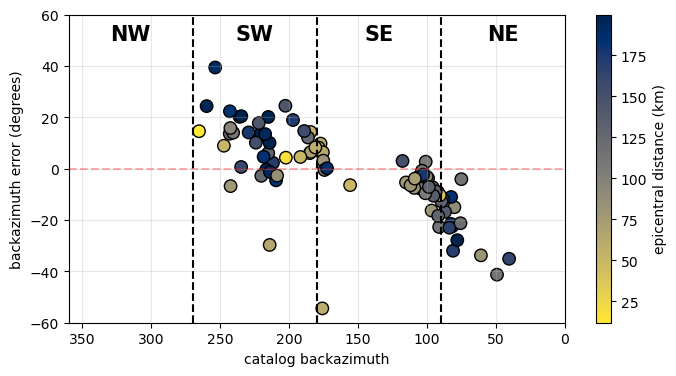

In [165]:
#SINGLE PLOT###################

df_measured = temp

fig, ax = plt.subplots(figsize = (8,4))

Z_fit = np.linspace(0, 360, 500)
y_fit = cos_model(Z_fit, *params)

#ax.plot(Z_fit, y_fit, 'r-', linewidth = 2.5)

sc = ax.scatter(df_measured[array+'_baz'], df_measured['baz_error'], c =  df_measured['epi_distance_'+array+'(km)'], s = 80, cmap = 'cividis_r', edgecolors = 'black')

ax.text(45,50, "NE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(135,50, "SE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(225,50, "SW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(315,50, "NW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')

ax.axvline(x=90, color = 'black', linestyle = '--')
ax.axvline(x=180, color = 'black', linestyle = '--')
ax.axvline(x=270, color = 'black', linestyle = '--')
ax.axhline(y=0, color = 'red', linestyle = '--', alpha = 0.3)

ax.grid(alpha = 0.3)
ax.set_xlabel('catalog backazimuth')
ax.set_ylabel('backazimuth error (degrees)')
ax.set_xlim(0,360)
ax.set_ylim(-60,60)
#ax.set_title('Array '+array+' Measured Backazimuth error')
plt.colorbar(sc, label = 'epicentral distance (km)')
ax.invert_xaxis()
plt.savefig('./baz_error_2a_lts', transparent=True, dpi = 720)
plt.show()

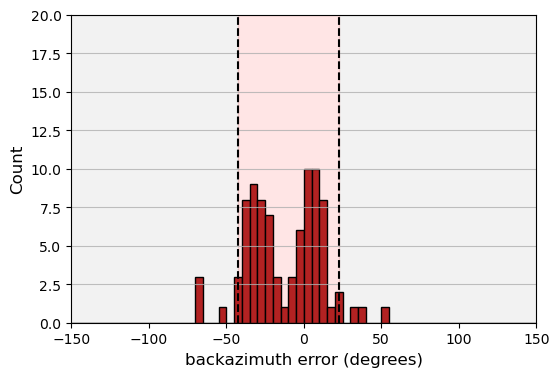

65.20001920676265


In [107]:
fig, ax = plt.subplots(figsize=(6, 4,))

#corrected = df_measured['baz_error'].to_numpy() #no correction
#corrected = df_measured['baz_error'].to_numpy() - temp_deflect['2A_baz_error'].to_numpy() #snells 3D
corrected = df_measured['baz_error'].to_numpy() 

hist_params = {
    'bins': 80, #5 degrees per bin
    'range': (-200, 200),
    'edgecolor': 'black'
    }
    
#corrected = corrected.dropna()
#b = baz_hist['baz_error']
c = corrected

ax.axvspan(-200,np.quantile(c, 0.05), color = 'gray',alpha = 0.1)

ax.axvspan(np.quantile(c, 0.95),200, color = 'gray',alpha = 0.1)
ax.axvspan(np.quantile(c, 0.05),np.quantile(c,0.95), color = 'red',alpha = 0.1)

ax.hist(c, color = 'firebrick', **hist_params)

ax.set_xlabel('backazimuth error (degrees)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(axis='y', alpha=0.8)


ax.axvline(x=np.quantile(c, 0.95), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
ax.axvline(x=np.quantile(c, 0.05), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
range1 = (np.abs(np.quantile(c, 0.05))+np.abs(np.quantile(c, 0.95)))

                                        


ax.set_xlim(-150, 150)
ax.set_ylim(0, 20)
#ax.set_title('Array '+array+' Theoretical Backazimuth Deflection')

#plt.tight_layout()  # To adjust space between subplots
#plt.savefig('/Users/cadequigley/Downloads/histogram_ess.png', transparent=True)
#plt.savefig('./baz_error_histogram_fk.png', transparent=True, dpi = 720)
plt.show()
print(range1)

a = -11.653705687923622
b = 28.315941232927628
phi (deg) = 73.51035175541416


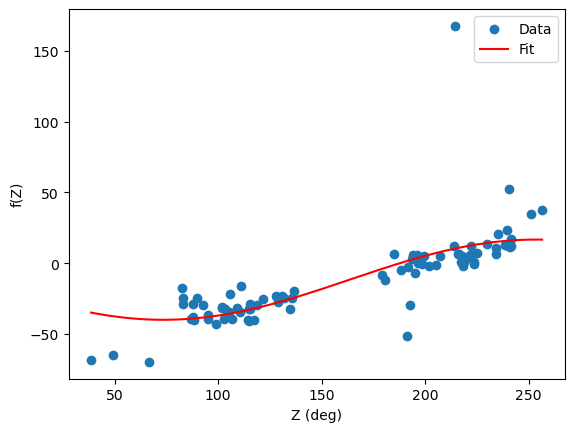

In [108]:
### Niazi style cosine fit--------------------------------
import numpy as np
from scipy.optimize import curve_fit

# Model: a - b*cos(Z - phi)
def cos_model(Z_deg, a, b, phi_deg):
    Z = np.radians(Z_deg)
    phi = np.radians(phi_deg)
    return a - b * np.cos(Z - phi)

# Example initial guesses
p0 = [1.0, 10.0, 180.0]   # a, b, phi guesses

Z_data = df_measured[array+'_baz']
y_data = df_measured['baz_error']

params, cov = curve_fit(cos_model, Z_data, y_data, p0=p0)

a_fit, b_fit, phi_fit = params
print("a =", a_fit)
print("b =", b_fit)
print("phi (deg) =", phi_fit)

Z_fit = np.linspace(min(Z_data), max(Z_data), 500)
y_fit = cos_model(Z_fit, *params)


import matplotlib.pyplot as plt

plt.scatter(Z_data, y_data, label='Data')
plt.plot(Z_fit, y_fit, 'r-', label='Fit')
plt.xlabel("Z (deg)")
plt.ylabel("f(Z)")
plt.legend()
plt.show()
y_fit = cos_model(Z_data, *params)



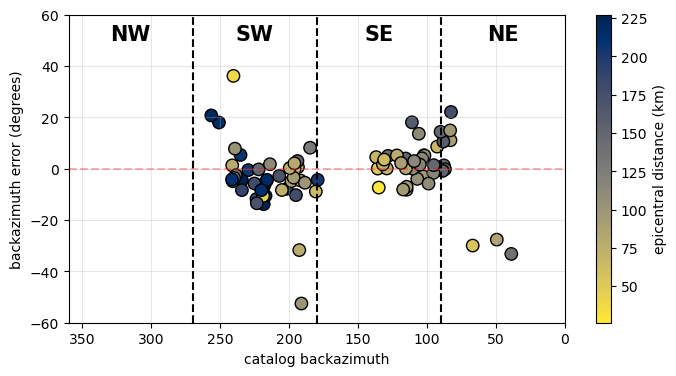

In [110]:
#SINGLE PLOT###################

df_measured = temp

fig, ax = plt.subplots(figsize = (8,4))

y_fit = cos_model(Z_data, *params)

sc = ax.scatter(df_measured[array+'_baz'], df_measured['baz_error']-y_fit, c =  df_measured['epi_distance_'+array+'(km)'], s = 80, cmap = 'cividis_r', edgecolors = 'black')

ax.text(45,50, "NE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(135,50, "SE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(225,50, "SW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(315,50, "NW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')

ax.axvline(x=90, color = 'black', linestyle = '--')
ax.axvline(x=180, color = 'black', linestyle = '--')
ax.axvline(x=270, color = 'black', linestyle = '--')
ax.axhline(y=0, color = 'red', linestyle = '--', alpha = 0.3)

ax.grid(alpha = 0.3)
ax.set_xlabel('catalog backazimuth')
ax.set_ylabel('backazimuth error (degrees)')
ax.set_xlim(0,360)
ax.set_ylim(-60,60)
#ax.set_title('Array '+array+' Measured Backazimuth error')
plt.colorbar(sc, label = 'epicentral distance (km)')
ax.invert_xaxis()
#plt.savefig('./baz_error_2a', transparent=True, dpi = 720)
plt.show()

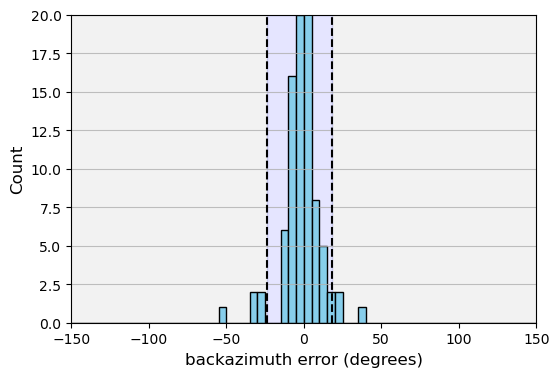

41.53994037443121


In [111]:
fig, ax = plt.subplots(figsize=(6, 4,))

#corrected = df_measured['baz_error'].to_numpy() #no correction
#corrected = df_measured['baz_error'].to_numpy() - temp_deflect['2A_baz_error'].to_numpy() #snells 3D
corrected = df_measured['baz_error'].to_numpy() - y_fit #Niazi

hist_params = {
    'bins': 80, #5 degrees per bin
    'range': (-200, 200),
    'edgecolor': 'black'
    }
    
#corrected = corrected.dropna()
#b = baz_hist['baz_error']
c = corrected

ax.axvspan(-200,np.quantile(c, 0.05), color = 'gray',alpha = 0.1)

ax.axvspan(np.quantile(c, 0.95),200, color = 'gray',alpha = 0.1)
ax.axvspan(np.quantile(c, 0.05),np.quantile(c,0.95), color = 'blue',alpha = 0.1)

ax.hist(c, color = 'skyblue', **hist_params)

ax.set_xlabel('backazimuth error (degrees)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(axis='y', alpha=0.8)


ax.axvline(x=np.quantile(c, 0.95), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
ax.axvline(x=np.quantile(c, 0.05), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
range1 = (np.abs(np.quantile(c, 0.05))+np.abs(np.quantile(c, 0.95)))

                                        


ax.set_xlim(-150, 150)
ax.set_ylim(0, 20)
#ax.set_title('Array '+array+' Theoretical Backazimuth Deflection')

#plt.tight_layout()  # To adjust space between subplots
#plt.savefig('/Users/cadequigley/Downloads/histogram_ess.png', transparent=True)
#plt.savefig('./baz_error_histogram_fk_corrected.png', transparent=True, dpi = 720)
plt.show()
print(range1)

### Slowness v slowness relationships

In [83]:
#Pull deflection data-----------------------------------
strike = '249'
dip = '30'
array = '2A'
test = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/'+array+'_3Dsnell_dip_'+dip+'_strike_'+strike+'.csv')

In [79]:
test = comb

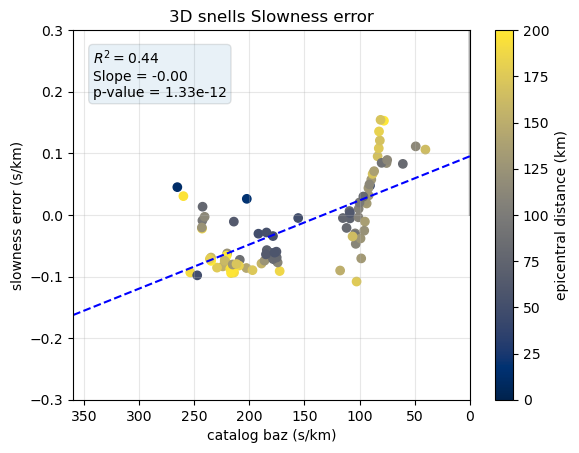

In [84]:
from scipy.stats import linregress
fig, ax = plt.subplots()
x = test[array+'_baz'].to_numpy() #array measured slowness
y = test['2A_slowness_error'].to_numpy() # slowness from Japan 1D model
c = test[array+'_epicentral_distance'].to_numpy() #source backazimuth

sc = ax.scatter(x,y, c= c, cmap = 'cividis',vmin = 0, vmax = 200 )
ax.plot(np.linspace(0,0.3,20), np.linspace(0,0.3,20), color = 'black', linestyle = '-', alpha = 0.3)

# Perform linear regression-----------------------------------------------------------
slope, intercept, r_value, p_value, std_err = linregress(x, y)

tempx = np.linspace(0,360,60)
regression_line = slope * tempx + intercept
ax.plot(tempx, regression_line, color='blue', linestyle='--', label='Linear Fit')
    
# Prepare the text for R^2, slope, and p-value
text_str = f'$R^2 = {r_value**2:.2f}$\nSlope = {slope:.2f}\np-value = {p_value:.3g}'
    
# Add the text to the plot
ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

ax.set_xlabel('catalog baz (s/km)')
ax.set_ylabel('slowness error (s/km)')
ax.set_title('3D snells Slowness error')
ax.grid(alpha = 0.3)
ax.set_xlim(0,360)
ax.set_ylim(-0.3,0.3)
ax.invert_xaxis()
plt.colorbar(sc, label = 'epicentral distance (km)')
plt.show()

In [37]:
compare = pd.merge(test,temp, on = 'event_id', how = 'inner')
compare.columns

Index(['Unnamed: 0', '2A_baz_x', '2A_baz_error_model',
       '2A_epicentral_distance', '2A_deflection_incident', '2A_slowness_error',
       '2A_japan_1d_slowness_x', '2A_japan_1d_incidence_x',
       '2A_japan_1d_trace_vel_x', 'event_id', '2A_japan_1d_slowness_y',
       '3A_japan_1d_slowness', 'POM_japan_1d_slowness',
       '2A_japan_1d_incidence_y', '3A_japan_1d_incidence',
       'POM_japan_1d_incidence', '2A_japan_1d_trace_vel_y',
       '3A_japan_1d_trace_vel', 'POM_japan_1d_trace_vel',
       '2A_japan_1d_takeoff', '3A_japan_1d_takeoff', 'POM_japan_1d_takeoff',
       '2A_depth_takeoff', '3A_depth_takeoff', 'POM_depth_takeoff', '2A_baz_y',
       '3A_baz', 'POM_baz', '2A_dist', '3A_dist', 'POM_dist', 'slow_error',
       'Unnamed: 0_x', 'window_length', 'freq_max', 'freq_min', 'trace_vel',
       'baz', 'mdccm', 'baz_error', 'abs_baz_error', 'new_time',
       'conf_int_vel', 'conf_int_baz', 'time', 'elapsed_time', 'Unnamed: 0_y',
       'eq_depth(km)', 'eq_magnitude', 'eq_lat

In [85]:
compare = comb

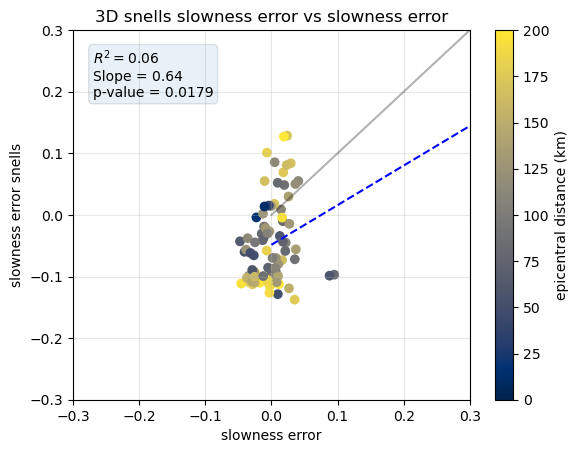

In [86]:
from scipy.stats import linregress

#compare = pd.merge(test,temp, on = 'event_id', how = 'inner')
fig, ax = plt.subplots()
x = compare['slow_error'].to_numpy() #array measured slowness
y = compare['2A_slowness_error'].to_numpy() # slowness from Japan 1D model
c = compare[array+'_epicentral_distance'].to_numpy() #source backazimuth

sc = ax.scatter(x,y, c= c, cmap = 'cividis',vmin = 0, vmax = 200 )
ax.plot(np.linspace(0,0.3,20), np.linspace(0,0.3,20), color = 'black', linestyle = '-', alpha = 0.3)

# Perform linear regression-----------------------------------------------------------
slope, intercept, r_value, p_value, std_err = linregress(x, y)

tempx = np.linspace(0,360,60)
regression_line = slope * tempx + intercept
ax.plot(tempx, regression_line, color='blue', linestyle='--', label='Linear Fit')
    
# Prepare the text for R^2, slope, and p-value
text_str = f'$R^2 = {r_value**2:.2f}$\nSlope = {slope:.2f}\np-value = {p_value:.3g}'
    
# Add the text to the plot
ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

ax.set_xlabel('slowness error')
ax.set_ylabel('slowness error snells')
ax.set_title('3D snells slowness error vs slowness error')
ax.grid(alpha = 0.3)
ax.set_xlim(-0.3,0.3)
ax.set_ylim(-0.3,0.3)
#ax.invert_xaxis()
plt.colorbar(sc, label = 'epicentral distance (km)')
plt.show()

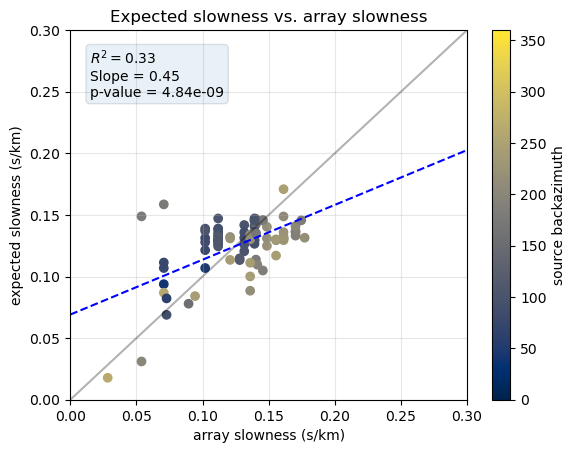

In [87]:
from scipy.stats import linregress
fig, ax = plt.subplots()
if analysis =='lts':
    x = 1/temp['trace_vel'].to_numpy() #array measured slowness
else:
    x = temp['slow'].to_numpy()
y = temp['2A_japan_1d_slowness'].to_numpy() # slowness from Japan 1D model
c = temp[array+'_baz'].to_numpy() #source backazimuth

sc = ax.scatter(x,y, c= c, cmap = 'cividis',vmin = 0, vmax = 360 )
ax.plot(np.linspace(0,0.3,20), np.linspace(0,0.3,20), color = 'black', linestyle = '-', alpha = 0.3)

# Perform linear regression-----------------------------------------------------------
slope, intercept, r_value, p_value, std_err = linregress(x, y)

tempx = np.linspace(0,60,60)
regression_line = slope * tempx + intercept
ax.plot(tempx, regression_line, color='blue', linestyle='--', label='Linear Fit')
    
# Prepare the text for R^2, slope, and p-value
text_str = f'$R^2 = {r_value**2:.2f}$\nSlope = {slope:.2f}\np-value = {p_value:.3g}'
    
# Add the text to the plot
ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))

ax.set_xlabel('array slowness (s/km)')
ax.set_ylabel('expected slowness (s/km)')
ax.set_title('Expected slowness vs. array slowness')
ax.grid(alpha = 0.3)
ax.set_xlim(0,0.3)
ax.set_ylim(0,0.3)
plt.colorbar(sc, label = 'source backazimuth')
plt.show()

In [89]:
temp.columns

Index(['Unnamed: 0_x', 'time', 'relpow', 'abspow', 'baz_obspy', 'slow',
       'baz_error', 'new_time', 'corrected_baz', 'window_length', 'event_id',
       'freq_min', 'freq_max', 'elapsed_time', 'Unnamed: 0_y', 'eq_depth(km)',
       'eq_magnitude', 'eq_latitude', 'eq_longitude', 'eq_origin_time',
       'hypo_distance_2A(km)', 'epi_distance_2A(km)', 'hypo_distance_3A(km)',
       'epi_distance_3A(km)', 'hypo_distance_POM(km)', 'epi_distance_POM(km)',
       '2A02', '3A05', 'POM11', 'array_2A_ppicks', 'array_3A_ppicks',
       'array_POM_ppicks', 'fwd_azimuth_2a', 'fwd_azimuth_3a',
       'fwd_azimuth_pom', 'Unnamed: 0', '2A_baz', '2A_baz_error_model',
       '2A_epicentral_distance', '2A_deflection_incident', '2A_slowness_error',
       '2A_japan_1d_slowness', '2A_japan_1d_incidence',
       '2A_japan_1d_trace_vel', 'slow_error'],
      dtype='object')

KeyError: '2A_dist'

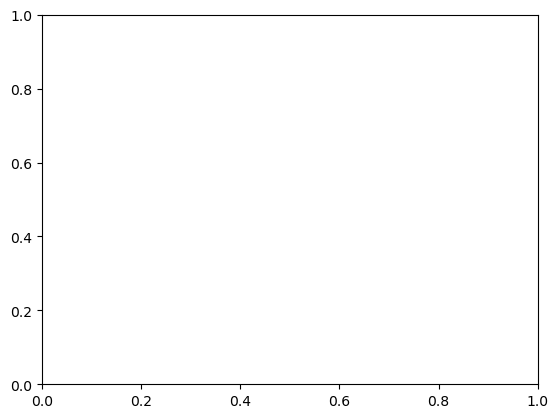

In [88]:
from scipy.stats import linregress
fig, ax = plt.subplots()
if analysis == 'lts':
    x = 1/temp['trace_vel'].to_numpy() #array measured slowness
else:
    x = temp['slow'].to_numpy()
#y = temp['2A_japan_1d_slowness'].to_numpy() # slowness from Japan 1D model
y = temp['eq_depth(km)'].to_numpy()
#c = temp[array+'_baz'].to_numpy() #source backazimuth
c = temp[array+'_dist'].to_numpy() #source backazimuth

sc = ax.scatter(x,y, c= c, cmap = 'cividis',vmin = 0, vmax = 200 )
#ax.plot(np.linspace(0,0.3,20), np.linspace(0,0.3,20), color = 'black', linestyle = '-', alpha = 0.3)

# Perform linear regression-----------------------------------------------------------
slope, intercept, r_value, p_value, std_err = linregress(x, y)

tempx = np.linspace(0,60,60)
regression_line = slope * tempx + intercept
ax.plot(tempx, regression_line, color='blue', linestyle='--', label='Linear Fit')
    
# Prepare the text for R^2, slope, and p-value
text_str = f'$R^2 = {r_value**2:.2f}$\nSlope = {slope:.2f}\np-value = {p_value:.3g}'
    
# Add the text to the plot
ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))
ax.set_xlabel('array slowness (s/km)')
ax.set_ylabel('earthquake depth (s/km)')

ax.grid(alpha = 0.3)
ax.set_xlim(0,0.3)
ax.set_ylim(0,200)
ax.set_title('Array slowness vs. earthquake depth')
plt.colorbar(sc, label = 'epicentral distance (km)')
plt.show()

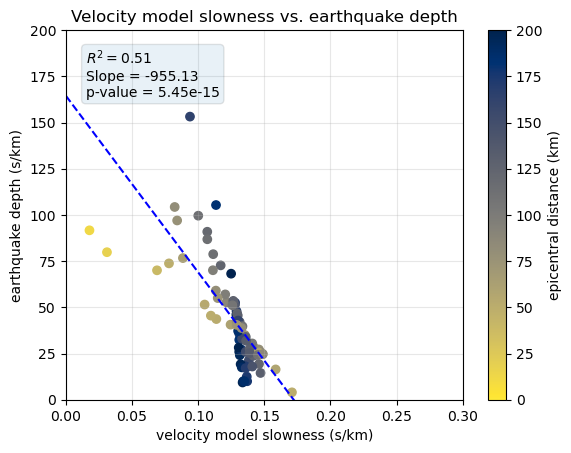

In [27]:
from scipy.stats import linregress
fig, ax = plt.subplots()
#x = 1/temp['trace_vel'].to_numpy() #array measured slowness
x = temp['2A_japan_1d_slowness'].to_numpy() # slowness from Japan 1D model
y = temp['eq_depth(km)'].to_numpy()
#c = temp[array+'_baz'].to_numpy() #source backazimuth
c = temp[array+'_dist'].to_numpy() #source backazimuth

sc = ax.scatter(x,y, c= c, cmap = 'cividis_r',vmin = 0, vmax = 200 )
#ax.plot(np.linspace(0,0.3,20), np.linspace(0,0.3,20), color = 'black', linestyle = '-', alpha = 0.3)

# Perform linear regression-----------------------------------------------------------
slope, intercept, r_value, p_value, std_err = linregress(x, y)

tempx = np.linspace(0,60,60)
regression_line = slope * tempx + intercept
ax.plot(tempx, regression_line, color='blue', linestyle='--', label='Linear Fit')
    
# Prepare the text for R^2, slope, and p-value
text_str = f'$R^2 = {r_value**2:.2f}$\nSlope = {slope:.2f}\np-value = {p_value:.3g}'
    
# Add the text to the plot
ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))
ax.set_xlabel('velocity model slowness (s/km)')
ax.set_ylabel('earthquake depth (s/km)')

ax.grid(alpha = 0.3)
ax.set_title('Velocity model slowness vs. earthquake depth')
ax.set_xlim(0,0.3)
ax.set_ylim(0,200)
plt.colorbar(sc, label = 'epicentral distance (km)')
plt.show()

### BAZ error plot

In [38]:
from obspy.geodetics import gps2dist_azimuth

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


lat_2a = 53.69619999999999
lon_2a = -166.7326
lat_3a = 53.77933636363636
lon_3a = -166.21232727272726
lat_pom = 53.85690833333333
lon_pom = -166.41502499999999

df = pd.read_csv('/Users/cadequigley/Downloads/completed_runs_v2/record_sections_picks/2A_epic_times.csv')
df = df.rename(columns={'eq_name': 'event_id'})
df1 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
merged = pd.merge(df, df1, on='event_id', how='inner')

lats = merged['eq_latitude'].to_numpy()
lons = merged['eq_longitude'].to_numpy()
baz_2a = []
baz_3a = []
baz_pom = []
for i in range(len(lats)):
    lat = lats[i]
    lon = lons[i]
    #2A-------------
    dist,baz,az = gps2dist_azimuth(lat,lon,lat_2a,lon_2a)
    baz_2a.append(az)
    #3A-------------
    dist,baz,az = gps2dist_azimuth(lat,lon,lat_3a,lon_3a)
    baz_3a.append(az)
    #POM-------------
    dist,baz,az = gps2dist_azimuth(lat,lon,lat_pom,lon_pom)
    baz_pom.append(az)

merged['baz_2a'] = np.array(baz_2a)
merged['baz_3a'] = np.array(baz_3a)
merged['baz_pom'] = np.array(baz_pom)
#df = pd.merge(merged, df3, on='event_id', how='inner')

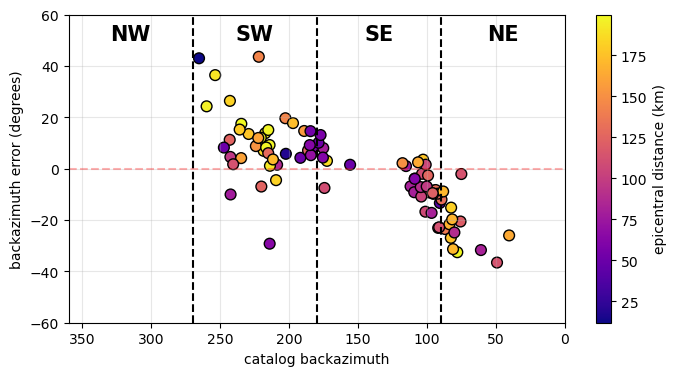

In [193]:
#SINGLE PLOT###################

#INPUTS--------------

max_freq = 20 #Hz
window_length = 1 #SECONDS
array = '2A' #'POM', '3A', "2A"
array1 = '2a' #'pom', '3a'
analysis = 'lts' #fk, lts
timing = 'quarter' #quarter, half, start

path = '/Users/cadequigley/Downloads/completed_runs_v2/array_analysis/05s_window/window_freq_analysis/'
#PULLING DATA
if analysis == 'lts':
    if timing =='start':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_epic_start.csv')
    elif timing == 'quarter':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_epic_start.csv')
    else:
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_epic_start.csv')
        
else:
    if timing =='start':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_pick_start.csv')
    elif timing == 'quarter':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_pick_start.csv')
    else:
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_pick_start.csv')
###############################################################
df2 = pd.DataFrame(df1[(df1['window_length'] == window_length)])
df3 = pd.DataFrame(df2[(df2['freq_max'] == max_freq)])


df_measured = pd.merge(merged, df3, on='event_id', how='inner')

fig, ax = plt.subplots(figsize = (8,4))

sc = ax.scatter(df_measured['baz_'+array1], df_measured['baz_error'], c =  df_measured['epi_distance_'+array+'(km)'], s = 60, cmap = 'plasma', edgecolors = 'black')

ax.text(45,50, "NE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(135,50, "SE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(225,50, "SW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(315,50, "NW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')

ax.axvline(x=90, color = 'black', linestyle = '--')
ax.axvline(x=180, color = 'black', linestyle = '--')
ax.axvline(x=270, color = 'black', linestyle = '--')
ax.axhline(y=0, color = 'red', linestyle = '--', alpha = 0.3)

ax.grid(alpha = 0.3)
ax.set_xlabel('catalog backazimuth')
ax.set_ylabel('backazimuth error (degrees)')
ax.set_xlim(0,360)
ax.set_ylim(-60,60)
#ax.set_title('Array '+array+' Measured Backazimuth error')
plt.colorbar(sc, label = 'epicentral distance (km)')
ax.invert_xaxis()
plt.savefig('./baz_error_2a', transparent=True, dpi = 720)
plt.show()

### 3D Snells

#### 3D snells functions

In [3]:
#### FUNCTIONS FOR 3D SNELLS LAW ###########################

def baz_to_az(backazimuth):
    azimuth = (backazimuth + 180) % 360
    return azimuth

def plane_normal(dip, strike):
    """
    Converts dip and strike to a unit normal vector (X, Y, Z).
    
    Parameters:
        dip_deg: float — Dip angle in degrees (0 = horizontal, 90 = vertical)
        dip_dir_deg: float — Dip direction in degrees (clockwise from North)

    Returns:
        np.array([x, y, z]) — unit normal vector to the plane
    """
    dip_dir_deg = (strike + 90) % 360
    dip_rad = np.radians(dip)
    dip_dir_rad = np.radians(dip_dir_deg)

    nx = np.sin(dip_rad) * np.sin(dip_dir_rad)  # X = East
    ny = np.sin(dip_rad) * np.cos(dip_dir_rad)  # Y = North
    nz = np.cos(dip_rad)                        # Z = Up

    n = np.array([nx, ny, nz])
    normal = n / np.linalg.norm(n)  # normalize just in case
    return normal

def spherical_to_xyz(azimuth, takeoff):
    """
    Converts azimuth (0-360°, clockwise from North) and takeoff angle (0-90°, from vertical)
    to a unit 3D direction vector [x, y, z].

    Parameters:
        azimuth_deg: float — azimuth angle in degrees, clockwise from North (Y+ axis)
        takeoff_deg: float — takeoff angle in degrees, 0° = vertical up, 90° = horizontal

    Returns:
        np.array([x, y, z]) — unit direction vector
    """
    az_rad = np.radians(azimuth)
    takeoff_rad = np.radians(takeoff)

    r_xy = np.sin(takeoff_rad)       # projection in XY plane
    x = r_xy * np.sin(az_rad)
    y = r_xy * np.cos(az_rad)
    z = np.cos(takeoff_rad)          # vertical component

    vector = np.array([x, y, z])

    return vector


    
def angle_to_xy(angle_deg):
    """
    Converts a clockwise-from-north angle (degrees) to a unit XY vector.
    0° = North (positive Y), 90° = East (positive X), etc.
    """
    theta_rad = np.radians(angle_deg)
    x = np.sin(theta_rad)
    y = np.cos(theta_rad)
    return np.array([x, y])
    

def snell_3d(incident, normal, v1, v2):
    """
    Snells law in 3 dimensions.
    Args:
        v1: velocity below moho (cold lithosphere) (float)
        v2: velocity above moho (hot lithosphere) (float)
        incident: directional vector of incident ray (3 component np.array)
        normal: normal vector to dipping moho plane (strike and dip)
    Returns:
        refracted: refracted ray
    
    """
    ratio = v2/v1
    l = incident/np.linalg.norm(incident) #incident vector of ray
    n = normal/np.linalg.norm(normal) #normal vector to subduction surface
    costheta1 = np.dot(n,l)
    costheta2 = np.sqrt((1-ratio**2)*(1-costheta1**2))
    refracted = ratio*l+(ratio*costheta1 + costheta2)*n
    return refracted



def deflection_xy(incident, refracted): #analogous with baz error
    """
    Calculates the angle between the incident wave and refracted wave in the x-y plane
    Args:
        incident: incident vector (3 component np.array)
        refracted: refracted vector (3 component np.array)

    Returns:
        angle_deg: angle in degrees of vector
    """
    # Project to XY
    u = np.array([incident[0], incident[1]])  # (x, y); incident vector
    v = np.array([refracted[0], refracted[1]])  # (x, y); refracted vector

    # Normalize
    u /= np.linalg.norm(u)
    v /= np.linalg.norm(v)

    # Compute signed angle using atan2
    angle_rad = np.arctan2(u[0]*v[1] - u[1]*v[0], u[0]*v[0] + u[1]*v[1]) #refracted - incident
    angle_deg = np.rad2deg(angle_rad)

    return angle_deg # converts back to incident - refracted: definition of BAZ error, *-1

def deflection_yz(incident, refracted):
    """
    Args:
    Calculates the angle between the incident wave and refracted wave in the y-z plane
    
        incident: incident vector (3 component np.array)
        refracted: refracted vector (3 component np.array)

    Returns:
        angle_deg: angle in degrees of vector
    """
    # Project to YZ
    u = np.array([incident[1], incident[2]])  # (y, z)
    v = np.array([refracted[1], refracted[2]])  # (y, z)

    # Normalize
    u /= np.linalg.norm(u)
    v /= np.linalg.norm(v)

    # Compute signed angle using atan2
    angle_rad = np.arctan2(u[0]*v[1] - u[1]*v[0], u[0]*v[0] + u[1]*v[1])
    angle_deg = np.rad2deg(angle_rad)

    return angle_deg

### Trying some new deflections in slowness plane

### Function to rotate refracted ray back into azimuth-normal plane
def rotate_about_z(v, angle_deg): ##v is a vector, angle_deg is the backazimuth error rotation
    angle = np.radians(angle_deg)
    R = np.array([
        [ np.cos(angle), -np.sin(angle), 0],
        [ np.sin(angle),  np.cos(angle), 0],
        [ 0,              0,             1]
    ])
    return R @ v

## Function to calculate incidence angle from vector
def incidence_angle(v): #incidence angle from vertical 
    v = v / np.linalg.norm(v)
    return np.degrees(np.arccos(v[2]))  # z = up

### Definition of horizontal slowness
def horizontal_slowness(v, velocity): #v is vector, velocity is p-wave velocity of medium
    v = v / np.linalg.norm(v)
    theta = np.arccos(v[2])
    return np.sin(theta) / velocity




In [ ]:
def baz_error(strike, dip, backazimuth, takeoff, oceanic_vel, continental_vel):
    
    azimuth = baz_to_az(backazimuth) #azimuth of incoming wave
    normal = plane_normal(dip, strike) #dip of plane (moho)
    incident = spherical_to_xyz(azimuth, takeoff) #incident vector
    refracted = snell_3d(incident, normal, oceanic_vel, continental_vel) #refracted vector
    ###BAZ ERROR--------------------------------------
    deflection_baz = deflection_xy(incident, refracted)

    return deflection_baz

def slowness_error(strike, dip, backazimuth, takeoff, oceanic_vel, continental_vel):
    azimuth = baz_to_az(baz) #azimuth of incoming wave
    normal = plane_normal(dip, strike) #dip of plane (moho)
    incident = spherical_to_xyz(azimuth, takeoff) #incident vector
    refracted = snell_3d(incident, normal, oceanic_vel, continental_vel) #refracted vector

    ###SLOWNESS ERROR---------------------------------

    # Undo azimuthal deflection to get vertical variation
    refracted_unrot = rotate_about_z(refracted, 0) #-deflected_baz #gives refracted vector that is rotated in the x-y plane back into plane of incident wave
    p_inc = horizontal_slowness(incident, oceanic_vel) # slowness of incident wave, oceanic_vel, 6.04
    p_ref = horizontal_slowness(refracted_unrot, continental_vel) # slowness of refracted wave, continental_vel, 6.04

    delta_p = p_inc - p_ref  #slowness error: incident ray - refracted ray
    return delta_p

#### Application

In [172]:
### Pull single combination
#import pygmt
import pandas as pd
import numpy as np

#INPUTS--------------

max_freq = 20 #Hz, 6,8,10,14,20
window_length = 3 #SECONDS, 0.5,1,2,3,4
array = '3A' #'POM', '3A', "2A"
array1 = '3a' #'pom', '3a'
analysis = 'lts' #fk, lts
timing = 'start' #quarter, half, start
#model = 'japan1d' #pavdut, japan1d, ak135, iasp91
mod = 'iasp91' #pavdut, japan_1d, ak135, iasp91

strike = '249'
dip = '20'

path = '/Users/cadequigley/Downloads/completed_runs_v2/array_analysis/05s_window/window_freq_analysis/'
#PULLING DATA
if analysis == 'lts':
    if timing =='start':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_epic_start.csv')
    elif timing == 'quarter':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_epic_start.csv')
    else:
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_epic_start.csv')
        
else:
    if timing =='start':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_pick_start.csv')
    elif timing == 'quarter':
        df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_pick_start.csv')
    else:
        df1 = pd.read_csv(analysis+'_all_events_'+array+'_half_before_pick_start.csv')
        
###############################################################
df2 = pd.DataFrame(df1[(df1['window_length'] == window_length)])
dfbaz = pd.DataFrame(df2[(df2['freq_max'] == max_freq)])

df = pd.read_csv('~/Downloads/Research/2014-15_eqs.txt', delimiter = '|')
df1 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
#df2 = pd.read_csv("/Users/cadequigley/Downloads/Research/ls_time_plots/spatial_example_baz_errors.csv")
#snell = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/'+array+'_3Dsnell_dip_'+dip+'_strike_'+strike+'.csv')
japan = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/'+mod+'_values_9c_arrays.csv')
comb = pd.merge(dfbaz, df1, on='event_id', how='inner')
comb = pd.merge(comb, japan, on = 'event_id', how = 'inner')


In [173]:
baz = comb[array+'_baz'].to_numpy()
takeoff = comb[array+'_depth_takeoff'].to_numpy()
baz_obs = comb['baz_error'].to_numpy()
if analysis == 'lts':
    slow_obs = 1/comb['trace_vel'].to_numpy()
else:
    slow_obs  = comb['slow'].to_numpy()

dp_obs = comb[array+'_'+mod+'_slowness'].to_numpy() - slow_obs

In [174]:
sigma_baz = np.deg2rad(20.0)   # 2° uncertainty
sigma_p   = 0.2              # s/km uncertainty

w_baz = 1 / sigma_baz         # ≈ 28.6
w_p   = 1 / sigma_p           # = 50

alpha_baz = 1   # BAZ importance multiplier, 0.1
alpha_slow = 0

#w_baz = alpha_baz / sigma_baz
#w_p   = alpha_slow / sigma_p

w_baz = .3
w_p   = 1



In [175]:
import numpy as np

### Defining model for inversion---------------------------------------------------
def combined_residuals(p, baz, takeoff, baz_obs, dp_obs, w_bazw=w_baz, w_p=w_p):
    
    """
    Args:
    Calculates residuals between model and observed for different strike/dip/continental_vel/oceanic vel combinations
    
        p: list of guess values [strike, dip, v_oceanic, v_continental]; list
        baz: source baz from USGS catalog (degrees from north); numpy.array
        takeoff: takeoff angle from depth or 1D velocity model; numpy.array
        baz_obs: observed baz deflection (degrees); numpy.array
        dp_obs: slowness deflection (s/km); numpy.array
        w_baz: weight for baz
        w_p: weight for slowness
        

    Returns:
        angle_deg: angle in degrees of vector
    """
    strike, dip, v_oceanic, v_continental = p

    N = len(baz)

    baz_res = np.zeros(N)
    p_res   = np.zeros(N)

    for i in range(N):
        azimuth = baz_to_az(baz[i])
        normal = plane_normal(dip, strike)
        incident = spherical_to_xyz(azimuth, takeoff[i])
        refracted = snell_3d(incident, normal, v_oceanic, v_continental)

        # --- BAZ residual (wrapped) ---
        baz_model = deflection_xy(incident, refracted)
        #baz_res[i] = np.angle(np.exp(1j * (baz_model - baz_obs[i]))) #for radians
        baz_res[i] = np.deg2rad((baz_model - baz_obs[i] + 180) % 360 - 180) #for angles


        # --- Slowness residual ---
        refracted_unrot = rotate_about_z(refracted, 0)
        p_inc = horizontal_slowness(incident, v_oceanic)
        p_ref = horizontal_slowness(refracted_unrot, v_continental)
        p_model = p_inc - p_ref

        p_res[i] = p_model - dp_obs[i]

    # Stack residuals
    return np.hstack([w_baz * baz_res, w_p * p_res])



#####INVERSION######################################
from scipy.optimize import least_squares


#Initial guess---------------------
x0 = [
    249.0,   # strike, based on trench strike
    10.0,   # dip, based on subduction zone dip
    8.04,    # oceanic velocity
    6.2     # continental velocity
]

#Value bounds---------------------
bounds = (
    [0,   0,   8.03, 4], #lower bounds, 5.8, 4
    [360, 90,  8.04, 8] #upper bounds
    #[0,   0,   8.0, 6.15], #lower bounds, 5.8, 4
    #[360, 90,  8.1, 6.25] #upper bounds


    #[0,   0,   8.03, 6.19], #lower bounds, 5.8, 4
    #[360, 90,  8.04, 6.21] #upper bounds
)

res = least_squares(
    combined_residuals,
    x0=x0,
    bounds=bounds,
    args=(baz, takeoff, baz_obs, dp_obs),
)

strike_fit, dip_fit, v_oceanic_fit, v_continental_fit = res.x

print('Best strike:', strike_fit)
print('Best dip:', dip_fit)
print('Best oceanic vel:', v_oceanic_fit)
print('Best continental vel:', v_continental_fit)



Best strike: 302.13126846907244
Best dip: 15.283920691804541
Best oceanic vel: 8.030000000007224
Best continental vel: 5.017103986157778


In [108]:
6.2/8.04

0.7711442786069653

In [176]:
### THEORETICAL DEFLECTION FOR 2A-----------------
#df = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/japan1d_values_9c_arrays.csv')
df = japan
#array = '3A' #2A, 3A, POM
#mod = 'japan_1d'
### data to be saved--------------------
event_id = df['event_id']



##Input data to be used------------------ 
baz = df[array+'_baz'].to_numpy()
az = baz_to_az(baz)
az = df[array+'_az']

#takeoff = df[array+'_pavdut_takeoff'].to_numpy()
#takeoff = df[array+'_iasp91_takeoff'].to_numpy()
#takeoff = df[array+'_'+mod+'_incidence']
#takeoff = df[array+'_japan_1d_takeoff'].to_numpy()
takeoff = df[array+'_depth_takeoff'].to_numpy()
epi_distance = df[array+'_dist']


inversion = True

if inversion == False: #True for defining subduction zone, false for using inversion results
    ##Define subduction zone--------------
    print('Using defined subduction zone')
    strike = 249 # relative to north, 66 (trench), 61 (Unalaska), 249
    dip = 30 # 0 to 90, 20
    oceanic_vel = 8.2 # km/s #8.2
    continental_vel = 4.1 # km/s, 6.04 (iasp91), 3
else:
    #Use inversion results-------------------
    print('Using inversion results')
    strike = strike_fit
    dip = dip_fit
    oceanic_vel = v_oceanic_fit
    continental_vel = v_continental_fit

##

##Calculate deflection-----------------
normal = plane_normal(dip, strike)

deflection_backazimuth = []
deflection_incident = []
deflection_slow = []

for i in range(len(baz)):
    azimuth = az[i]
    takeoff1 = takeoff[i]
    #print('Takeoff angle',takeoff1)
    incident = spherical_to_xyz(azimuth, takeoff1)
    refracted = snell_3d(incident, normal, oceanic_vel, continental_vel)

    ###BAZ ERROR--------------------------------------
    deflection_baz = deflection_xy(incident, refracted)
    deflection_backazimuth.append(deflection_baz)

    ###SLOWNESS ERROR---------------------------------

    # Undo azimuthal deflection to get vertical variation
    refracted_unrot = rotate_about_z(refracted, 0) #-deflected_baz #gives refracted vector that is rotated in the x-y plane back into plane of incident wave

    #Calculate original incident angle/final incident angle
    theta_inc = incidence_angle(incident) #incident angle of incident wave
    #theta_ref = incidence_angle(refracted_unrot) #incident angle of refracted wave
    theta_ref = incidence_angle(refracted) #incident angle of refracted wave
    #print('Incident angle', theta_inc)
    #print('Refracted angle', theta_ref)
    #Incident angle error
    incident_error_deg = theta_inc - theta_ref #change in incident angle
    deflection_incident.append(incident_error_deg)

    #Slowness error
    p_inc = horizontal_slowness(incident, oceanic_vel) # slowness of incident wave, oceanic_vel, 6.04
    p_ref = horizontal_slowness(refracted_unrot, continental_vel) # slowness of refracted wave, continental_vel, 6.04

    #delta_p = p_ref - p_inc #slowness error between 
    delta_p = p_inc - p_ref  #slowness error: incident ray - refracted ray

    deflection_slow.append(delta_p)

    ### OLD WAY OF CALCULATING SLOWNESS ERROR-------------------
    #deflection_inc = deflection_yz(incident, refracted)
    #deflection_incident.append(deflection_inc)


    
### Calculate slowness error--------------------
#slow_theor = []
#for i in range(len(deflection_incident)):
    #angle = -1*deflection_incident[i] #need to check why this is
    #vh = 6.05/(np.sin(np.deg2rad(angle))) #6.05
    #slow = 1/vh
    #slow_theor.append(slow)

### Save date in dataframe-----------------------

temp_deflect = pd.DataFrame({
        array+'_baz': baz,
        array+'_baz_error_model': np.array(deflection_backazimuth),
        array+'_epicentral_distance':epi_distance,
        array+'_deflection_incident': np.array(deflection_incident),
        array+'_slowness_error': np.array(deflection_slow),
        array+'_'+mod+'_slowness': df[array+'_'+mod+'_slowness'],
        array+'_'+mod+'_incidence': df[array+'_'+mod+'_incidence'],
        array+'_'+mod+'_trace_vel': df[array+'_'+mod+'_trace_vel'],
        'event_id': event_id
})
    
#temp_deflect.to_csv('/Users/cadequigley/Downloads/Research/paper_figures/'+array+'_3Dsnell_dip_'+str(dip)+'_strike_'+str(strike)+'.csv')
print('Finished')


Using inversion results
Finished


a = 0.0024657137239030642
b = 0.04527449109820971
phi (deg) = 254.5347414326303


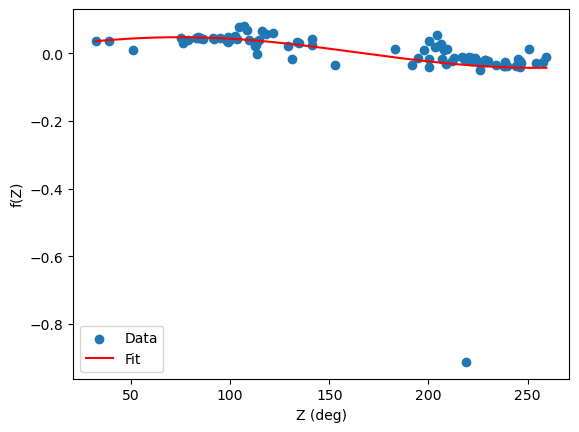

In [177]:
### Niazi style cosine fit--------------------------------
import numpy as np
from scipy.optimize import curve_fit

# Model: a - b*cos(Z - phi)
def cos_model(Z_deg, a, b, phi_deg):
    Z = np.radians(Z_deg)
    phi = np.radians(phi_deg)
    return a - b * np.cos(Z - phi)

if analysis == 'lts':
    slow_err = comb[array+'_'+mod+'_slowness'] - (1/comb['trace_vel']) 
else:
    slow_err = comb[array+'_'+mod+'_slowness'] - (comb['slow'])


# Example initial guesses
p0 = [1.0, 10.0, 180.0]   # a, b, phi guesses

Z_data = comb[array+'_baz']
y_data = slow_err

params, cov = curve_fit(cos_model, Z_data, y_data, p0=p0)

a_fit, b_fit, phi_fit = params
print("a =", a_fit)
print("b =", b_fit)
print("phi (deg) =", phi_fit)

Z_fit = np.linspace(min(Z_data), max(Z_data), 500)
y_fit = cos_model(Z_fit, *params)


import matplotlib.pyplot as plt

plt.scatter(Z_data, y_data, label='Data')
plt.plot(Z_fit, y_fit, 'r-', label='Fit')
plt.xlabel("Z (deg)")
plt.ylabel("f(Z)")
plt.legend()
plt.show()
y_fit = cos_model(Z_data, *params)



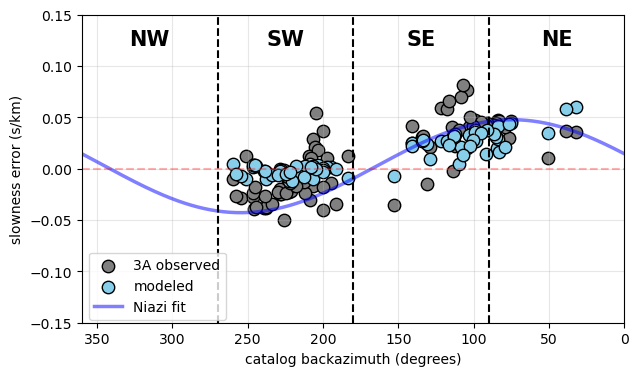

In [178]:
fig, ax = plt.subplots(figsize = (7,4))
if analysis == 'lts':
    slow_err = comb[array+'_'+mod+'_slowness'] - (1/comb['trace_vel']) 
else:
    slow_err = comb[array+'_'+mod+'_slowness'] - (comb['slow'])

c = comb[array+'_dist']
#ax.scatter(temp_deflect[array+'_baz'], temp_deflect[array+'_deflection_incident'])

#sc = ax.scatter(comb[array+'_baz'], slow_err,  c=c, cmap = 'cividis_r', s = 100, edgecolors = 'black', label = '2A slowness residuals')
ax.scatter(comb[array+'_baz'], slow_err, color ='gray', s = 80, edgecolors = 'black', label = array+' observed')
ax.scatter(temp_deflect[array+'_baz'], temp_deflect[array+'_slowness_error'],color = 'skyblue',alpha = 1, edgecolors = 'black', s = 80, label = 'modeled')

Z_fit = np.linspace(0, 360, 500)
y_fit = cos_model(Z_fit, *params)
ax.plot(Z_fit, y_fit, color = 'blue', linewidth = 2.5, label = 'Niazi fit', alpha= 0.5)

ax.text(45,0.12, "NE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(135,0.12, "SE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(225,0.12, "SW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(315,0.12, "NW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')

ax.axvline(x=90, color = 'black', linestyle = '--')
ax.axvline(x=180, color = 'black', linestyle = '--')
ax.axvline(x=270, color = 'black', linestyle = '--')
ax.axhline(y=0, color = 'red', linestyle = '--', alpha = 0.3)

ax.grid(alpha = 0.3)
ax.set_xlabel('catalog backazimuth (degrees)')
ax.set_ylabel('slowness error (s/km)')
#ax.set_title(array+' modeled slowness error vs. measured slowness error')
ax.set_xlim(0,360)
ax.set_ylim(-0.15,0.15)
#plt.colorbar(sc, label = 'epicentral distance (km)')
#plt.legend(loc = 'upper left')
plt.legend(loc = 'upper left', bbox_to_anchor=(0, 0.25))
ax.invert_xaxis()
#plt.savefig('./slow_error_'+array+'snell_nonfixed_3s', transparent=True, dpi = 720)

plt.show()

a = -11.588519588991486
b = 13.087875185199742
phi (deg) = 81.91941034369303


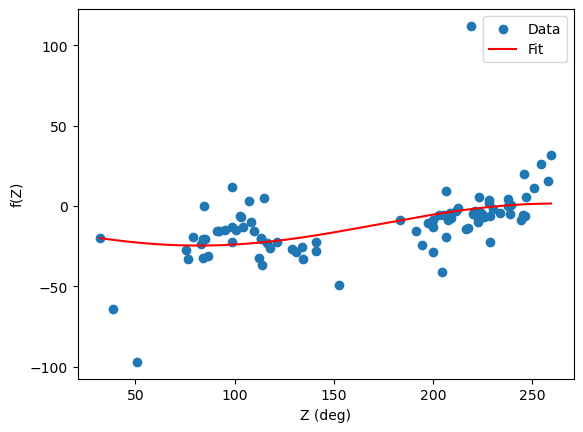

In [179]:
### Niazi style cosine fit--------------------------------
import numpy as np
from scipy.optimize import curve_fit

# Model: a - b*cos(Z - phi)
def cos_model(Z_deg, a, b, phi_deg):
    Z = np.radians(Z_deg)
    phi = np.radians(phi_deg)
    return a - b * np.cos(Z - phi)



# Example initial guesses
p0 = [1.0, 10.0, 180.0]   # a, b, phi guesses

Z_data = comb[array+'_baz']
y_data = comb['baz_error']

params, cov = curve_fit(cos_model, Z_data, y_data, p0=p0)

a_fit, b_fit, phi_fit = params
print("a =", a_fit)
print("b =", b_fit)
print("phi (deg) =", phi_fit)

Z_fit = np.linspace(min(Z_data), max(Z_data), 500)
y_fit = cos_model(Z_fit, *params)


import matplotlib.pyplot as plt

plt.scatter(Z_data, y_data, label='Data')
plt.plot(Z_fit, y_fit, 'r-', label='Fit')
plt.xlabel("Z (deg)")
plt.ylabel("f(Z)")
plt.legend()
plt.show()
y_fit = cos_model(Z_data, *params)



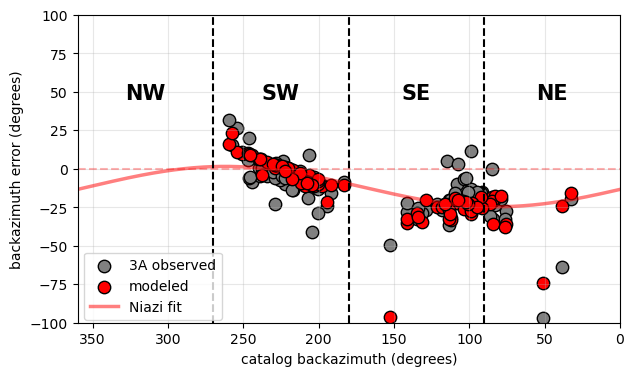

In [180]:
fig, ax = plt.subplots(figsize = (7,4))

ax.scatter(comb[array+'_baz'], comb['baz_error'], color = 'gray', alpha = 1, edgecolors = 'black', s = 80, label = array+' observed')
#sc = ax.scatter(temp_deflect[array+'_baz'], temp_deflect[array+'_baz_error_model'], c = temp_deflect[array+'_epicentral_distance'], cmap = 'plasma_r', edgecolors = 'black', s = 100)
ax.scatter(temp_deflect[array+'_baz'], temp_deflect[array+'_baz_error_model'], color = 'red', edgecolors = 'black', s = 80, label = 'modeled')

Z_fit = np.linspace(0, 360, 500)
y_fit = cos_model(Z_fit, *params)
ax.plot(Z_fit, y_fit, color = 'red', linewidth = 2.5, label = 'Niazi fit', alpha= 0.5)

ax.text(45,45, "NE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(135,45, "SE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(225,45, "SW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(315,45, "NW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')

ax.axvline(x=90, color = 'black', linestyle = '--')
ax.axvline(x=180, color = 'black', linestyle = '--')
ax.axvline(x=270, color = 'black', linestyle = '--')
ax.axhline(y=0, color = 'red', linestyle = '--', alpha = 0.3)

ax.grid(alpha = 0.3)
ax.set_xlabel('catalog backazimuth (degrees)')
ax.set_ylabel('backazimuth error (degrees)')
#ax.set_title(array+' modeled backazimuth error vs. measured backazimuth error')
ax.set_xlim(0,360)
ax.set_ylim(-100,100)
#ax.set_title('Array '+array+' Theoretical Backazimuth Deflection')
#plt.colorbar(sc, label = 'epicentral distance (km)')
ax.invert_xaxis()
plt.legend(loc = 'upper left', bbox_to_anchor=(0, 0.25))
#plt.savefig('./baz_error_'+array+'snell_nonfixed', transparent=True, dpi = 720)
plt.show()

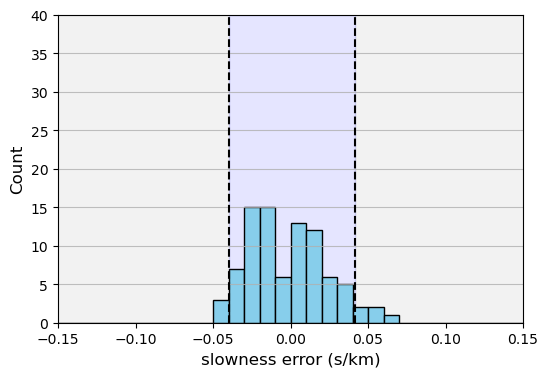

Quantile range before correction: 0.09678074430060583
Quantile range after correction: 0.08129431532745188
Percent improvement: 16.001560108953424


In [181]:
fig, ax = plt.subplots(figsize=(6, 4,))

if analysis == 'lts':
    comb['slowness_error'] = comb[array+'_'+mod+'_slowness'] - (1/comb['trace_vel']) 
else:
    comb['slowness_error'] = comb[array+'_'+mod+'_slowness'] - (comb['slow'])

temp = pd.merge(temp_deflect, comb, on = 'event_id', how = 'left')
temp = temp.dropna()
corrected = temp['slowness_error'] - temp[array+'_slowness_error']  

hist_params = {
    'bins': 30, #0.01 s/km per bin
    'range': (-0.15, 0.15),
    'edgecolor': 'black'
    }
    
#corrected = corrected.dropna()
#b = baz_hist['baz_error']
c = corrected

ax.axvspan(-200,np.quantile(c, 0.05), color = 'gray',alpha = 0.1)

ax.axvspan(np.quantile(c, 0.95),200, color = 'gray',alpha = 0.1)
ax.axvspan(np.quantile(c, 0.05),np.quantile(c,0.95), color = 'blue',alpha = 0.1)

ax.hist(c, color = 'skyblue', **hist_params)

ax.set_xlabel('slowness error (s/km)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(axis='y', alpha=0.8)


ax.axvline(x=np.quantile(c, 0.95), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
ax.axvline(x=np.quantile(c, 0.05), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
range1 = (np.abs(np.quantile(c, 0.05))+np.abs(np.quantile(c, 0.95)))
c = temp['slowness_error']
range2 = (np.abs(np.quantile(c, 0.05))+np.abs(np.quantile(c, 0.95)))

                                        


ax.set_xlim(-0.15, 0.15)
ax.set_ylim(0, 40)
#ax.set_title('Array '+array+' Theoretical Backazimuth Deflection')

#plt.tight_layout()  # To adjust space between subplots
#plt.savefig('/Users/cadequigley/Downloads/histogram_ess.png', transparent=True)
#plt.savefig('./baz_error_histogram_fk_corrected.png', transparent=True, dpi = 720)
plt.show()
print('Quantile range before correction:', range2)
print('Quantile range after correction:', range1)
print('Percent improvement:', ((range2-range1)/range2)*100)
slow_improve = ((range2-range1)/range2)*100

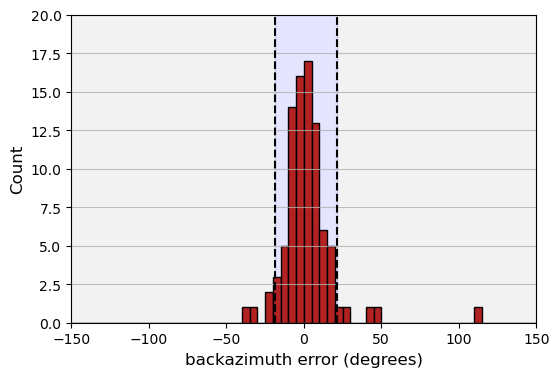

Quantile range before correction: 49.42397427258038
Quantile range after correction: 40.07343836801129
Percent improvement: 18.919028755153384
Overall improvement (baz + slow): 34.920588864106804


In [182]:
fig, ax = plt.subplots(figsize=(6, 4,))

#corrected = df_measured['baz_error'].to_numpy() #no correction
#corrected = df_measured['baz_error'].to_numpy() - temp_deflect['2A_baz_error'].to_numpy() #snells 3D
temp = pd.merge(temp_deflect, comb, on = 'event_id', how = 'left')
temp = temp.dropna()
corrected = temp['baz_error'] - temp[array+'_baz_error_model']

hist_params = {
    'bins': 80, #5 degrees per bin
    'range': (-200, 200),
    'edgecolor': 'black'
    }
    
#corrected = corrected.dropna()
#b = baz_hist['baz_error']
c = corrected

ax.axvspan(-200,np.quantile(c, 0.05), color = 'gray',alpha = 0.1)

ax.axvspan(np.quantile(c, 0.95),200, color = 'gray',alpha = 0.1)
ax.axvspan(np.quantile(c, 0.05),np.quantile(c,0.95), color = 'blue',alpha = 0.1)

ax.hist(c, color = 'firebrick', **hist_params)

ax.set_xlabel('backazimuth error (degrees)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(axis='y', alpha=0.8)


ax.axvline(x=np.quantile(c, 0.95), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
ax.axvline(x=np.quantile(c, 0.05), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
range1 = (np.abs(np.quantile(c, 0.05))+np.abs(np.quantile(c, 0.95)))

c = temp['baz_error']
range2 = (np.abs(np.quantile(c, 0.05))+np.abs(np.quantile(c, 0.95)))

                                        


ax.set_xlim(-150, 150)
ax.set_ylim(0, 20)
#ax.set_title('Array '+array+' Theoretical Backazimuth Deflection')

#plt.tight_layout()  # To adjust space between subplots
#plt.savefig('/Users/cadequigley/Downloads/histogram_ess.png', transparent=True)
#plt.savefig('./baz_error_histogram_fk_corrected.png', transparent=True, dpi = 720)
plt.show()
print('Quantile range before correction:', range2)
print('Quantile range after correction:', range1)
print('Percent improvement:', ((range2-range1)/range2)*100)
baz_improve = ((range2-range1)/range2)*100
print('Overall improvement (baz + slow):', baz_improve + slow_improve)

### STATISTICS

In [197]:
import numpy as np
import pandas as pd

### Defining model for inversion---------------------------------------------------
def combined_residuals(p, baz, takeoff, baz_obs, dp_obs, w_bazw=w_baz, w_p=w_p):
    
    """
    Args:
    Calculates residuals between model and observed for different strike/dip/continental_vel/oceanic vel combinations
    
        p: list of guess values [strike, dip, v_oceanic, v_continental]; list
        baz: source baz from USGS catalog (degrees from north); numpy.array
        takeoff: takeoff angle from depth or 1D velocity model; numpy.array
        baz_obs: observed baz deflection (degrees); numpy.array
        dp_obs: slowness deflection (s/km); numpy.array
        w_baz: weight for baz
        w_p: weight for slowness
        

    Returns:
        angle_deg: angle in degrees of vector
    """
    strike, dip, v_oceanic, v_continental = p

    N = len(baz)

    baz_res = np.zeros(N)
    p_res   = np.zeros(N)

    for i in range(N):
        azimuth = baz_to_az(baz[i])
        normal = plane_normal(dip, strike)
        incident = spherical_to_xyz(azimuth, takeoff[i])
        refracted = snell_3d(incident, normal, v_oceanic, v_continental)

        # --- BAZ residual (wrapped) ---
        baz_model = deflection_xy(incident, refracted)
        #baz_res[i] = np.angle(np.exp(1j * (baz_model - baz_obs[i]))) #for radians
        baz_res[i] = np.deg2rad((baz_model - baz_obs[i] + 180) % 360 - 180) #for angles


        # --- Slowness residual ---
        refracted_unrot = rotate_about_z(refracted, 0)
        p_inc = horizontal_slowness(incident, v_oceanic)
        p_ref = horizontal_slowness(refracted_unrot, v_continental)
        p_model = p_inc - p_ref

        p_res[i] = p_model - dp_obs[i]

    # Stack residuals
    return np.hstack([w_baz * baz_res, w_p * p_res])


###############################
#---------EXAMPLE USAGE----------------
###############################

baz = comb[array+'_baz'].to_numpy()
takeoff = comb[array+'_depth_takeoff'].to_numpy()
baz_obs = comb['baz_error'].to_numpy() #observed baz error
if analysis == 'lts':
    slow_obs = 1/comb['trace_vel'].to_numpy()
else:
    slow_obs  = comb['slow'].to_numpy()

dp_obs = comb[array+'_japan_1d_slowness'].to_numpy() - slow_obs #observed slowness error



### CREATE WEIGHTS FOR INVERSION------------------------------
sigma_baz = np.deg2rad(2.0)   # 2° uncertainty
sigma_p   = 0.02              # s/km uncertainty

w_baz = 1 / sigma_baz         # ≈ 28.6
w_p   = 1 / sigma_p           # = 50

alpha = 1.0   # BAZ importance multiplier

w_baz = alpha / sigma_baz
w_p   = 1.0 / sigma_p

#Initial guess---------------------
x0 = [
    249.0,   # strike, based on trench strike
    10.0,   # dip, based on subduction zone dip
    8.0,    # oceanic velocity
    6.0     # continental velocity
]

#Value bounds---------------------
bounds = (
    [0,   0,   8.0, 5.8], #lower bounds; strike, dip, oceanic_vel, continental_vel
    [360, 90,  8.4, 6.2] #upper bounds; strike, dip, oceanic_vel, continental_vel
)

#####INVERSION######################################
from scipy.optimize import least_squares

res = least_squares(
    combined_residuals,
    x0=x0,
    bounds=bounds,
    args=(baz, takeoff, baz_obs, dp_obs),
)

strike_fit, dip_fit, v_oceanic_fit, v_continental_fit = res.x

print('Best strike:', strike_fit)
print('Best dip:', dip_fit)
print('Best oceanic vel:', v_oceanic_fit)
print('Best continental vel:', v_continental_fit)



Best strike: 302.6977540772884
Best dip: 19.267832438957115
Best oceanic vel: 8.000000000001574
Best continental vel: 6.199999999999658


In [198]:
### THEORETICAL DEFLECTION FOR 2A-----------------    
def calculate_deflection(array, strike, dip, oceanic_vel,continental_vel):

    """
    Args:
    Calculates all deflection values from snell 3D functions given an orientation of a dipping plane. Within the function contains
    a dataframe with the source information (event id, baz, az, takeoff, slowness, incident angle, trace velocity).
    
        array: array label; '2A', '3A', 'POM'
        strike: strike of dipping plane
        dip: dip of dipping plane
        oceanic_vel: velocity below dipping structure
        continental_vel: velocity above dipping structure

    Returns:
        dataframe: 
            array+'_baz': true backazimuth
            array+'_baz_error_model': deflected backazimuth error
            array+'_epicentral_distance': epicentral distance
            array+'_deflection_incident': deflection of incident angle
            array+'_slowness_error': slowness error from deflection
            array+'_'+mod+'_slowness': 1D model slowness
            array+'_'+mod+'_incidence': 1D model incident angle
            array+'_'+mod+'_trace_vel': 1D model trace velocity
            'event_id': event_id
    """
    df = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/japan1d_values_9c_arrays.csv') #pulling data from Japan 1D fit of data
    array = array #2A, 3A, POM
    mod = 'japan_1d'

    ### data to be saved--------------------
    event_id = df['event_id']



    ##Input data to be used------------------ 
    baz = df[array+'_baz'].to_numpy()
    #az = baz_to_az(baz) #from functions list
    az = df[array+'_az'] #from obspy

    ### Different takeoff angle options, using takeoff angle from catalog depth/distance assuming straight path
    #takeoff = df[array+'_pavdut_takeoff'].to_numpy()
    #takeoff = df[array+'_iasp91_takeoff'].to_numpy()
    #takeoff = df[array+'_'+mod+'_incidence']
    #takeoff = df[array+'_japan_1d_takeoff'].to_numpy()
    takeoff = df[array+'_depth_takeoff'].to_numpy()
    epi_distance = df[array+'_dist']


    ##Calculate deflection-----------------
    normal = plane_normal(dip, strike)

    deflection_backazimuth = []
    deflection_incident = []
    deflection_slow = []

    for i in range(len(baz)):
        azimuth = az[i]
        takeoff1 = takeoff[i]
        #print('Takeoff angle',takeoff1)
        incident = spherical_to_xyz(azimuth, takeoff1)
        refracted = snell_3d(incident, normal, oceanic_vel, continental_vel)

        ###BAZ ERROR--------------------------------------
        deflection_baz = deflection_xy(incident, refracted)
        deflection_backazimuth.append(deflection_baz)

        ###SLOWNESS ERROR---------------------------------

        # Undo azimuthal deflection to get vertical variation
        refracted_unrot = rotate_about_z(refracted, 0) #-deflected_baz #gives refracted vector that is rotated in the x-y plane back into plane of incident wave

        #Calculate original incident angle/final incident angle
        theta_inc = incidence_angle(incident) #incident angle of incident wave
        #theta_ref = incidence_angle(refracted_unrot) #incident angle of refracted wave
        theta_ref = incidence_angle(refracted) #incident angle of refracted wave
        #print('Incident angle', theta_inc)
        #print('Refracted angle', theta_ref)
        #Incident angle error
        incident_error_deg = theta_inc - theta_ref #change in incident angle
        deflection_incident.append(incident_error_deg)

        #Slowness error
        p_inc = horizontal_slowness(incident, oceanic_vel) # slowness of incident wave, oceanic_vel, 6.04
        p_ref = horizontal_slowness(refracted_unrot, continental_vel) # slowness of refracted wave, continental_vel, 6.04

        #delta_p = p_ref - p_inc #slowness error between 
        delta_p = p_inc - p_ref  #slowness error: incident ray - refracted ray

        deflection_slow.append(delta_p)

    temp_deflect = pd.DataFrame({
            array+'_baz': baz,
            array+'_baz_error_model': np.array(deflection_backazimuth),
            array+'_epicentral_distance':epi_distance,
            array+'_deflection_incident': np.array(deflection_incident),
            array+'_slowness_error': np.array(deflection_slow),
            array+'_'+mod+'_slowness': df[array+'_'+mod+'_slowness'],
            array+'_'+mod+'_incidence': df[array+'_'+mod+'_incidence'],
            array+'_'+mod+'_trace_vel': df[array+'_'+mod+'_trace_vel'],
            'event_id': event_id
    })
    
    #temp_deflect.to_csv('/Users/cadequigley/Downloads/Research/paper_figures/'+array+'_3Dsnell_dip_'+str(dip)+'_strike_'+str(strike)+'.csv')
    print('Finished')

    return temp_deflect

###############################
#---------EXAMPLE USAGE----------------
###############################

array = '2A' #2A, 3A, POM

inversion = False ##use results from inversion

if inversion == False: #True for defining subduction zone, false for using inversion results
    ##Define subduction zone--------------
    print('Using defined subduction zone')
    strike = 249 # relative to north, 66 (trench), 61 (Unalaska), 249
    dip = 10 # 0 to 90
    oceanic_vel = 8.2 # km/s, iasp91 oceanic vel
    continental_vel = 6.04 # km/s, iasp91 continental vel
else:
    #Use inversion results-------------------
    print('Using inversion results')
    strike = strike_fit
    dip = dip_fit
    oceanic_vel = v_oceanic_fit
    continental_vel = v_continental_fit



temp_deflect = calculate_deflection(array, strike, dip, oceanic_vel,continental_vel)


Using defined subduction zone
Finished


#### Finished functions

In [199]:
def quantile_range(array): #numpy array
    ah = np.quantile(array, 0.95)
    aw = np.quantile(array, 0.05)
    return ah-aw

### Niazi model (see fig3....ipynb)-------------------------
def cos_model(Z_deg, a, b, phi_deg):
    Z = np.radians(Z_deg)
    phi = np.radians(phi_deg)
    return a - b * np.cos(Z - phi)

In [200]:
if analysis == 'lts':
    comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (1/comb['trace_vel'])
else:
    comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (comb['slow'])

def nonfixed_snell_quantiles(df, array = '2A', residuals = 'slow'):
###############################################################
### Non-Fixed 3D Snell ---------------------------------------------
    print('Starting Non-fixed 3D Snells')
    
    baz = comb[array+'_baz'].to_numpy()
    takeoff = comb[array+'_depth_takeoff'].to_numpy()
    baz_obs = comb['baz_error'].to_numpy() #observed baz error
    if analysis == 'lts':
        slow_obs = 1/comb['trace_vel'].to_numpy()
    else:
        slow_obs  = comb['slow'].to_numpy()

    dp_obs = comb[array+'_japan_1d_slowness'].to_numpy() - slow_obs #observed slowness error

    ### CREATE WEIGHTS FOR INVERSION------------------------------
    sigma_baz = np.deg2rad(2.0)   # 2° uncertainty
    sigma_p   = 0.02              # s/km uncertainty

    w_baz = 1 / sigma_baz         # ≈ 28.6
    w_p   = 1 / sigma_p           # = 50

    alpha = 1.0   # BAZ importance multiplier

    w_baz = alpha / sigma_baz
    w_p   = 1.0 / sigma_p

    if residuals =='slow':
        w_baz = 0
        w_p   = 1
    else:
        w_baz = 1
        w_p   = 0

    #Initial guess---------------------
    x0 = [
        249.0,   # strike, based on trench strike
        10.0,   # dip, based on subduction zone dip
        8.0,    # oceanic velocity
        6.0     # continental velocity
    ]

    #Value bounds---------------------
    bounds = (
        [0,   0,   8.0, 3], #lower bounds; strike, dip, oceanic_vel, continental_vel
        [360, 90,  8.4, 6.2] #upper bounds; strike, dip, oceanic_vel, continental_vel
    )

    #####INVERSION######################################
    from scipy.optimize import least_squares

    res = least_squares(
        combined_residuals,
        x0=x0,
        bounds=bounds,
        args=(baz, takeoff, baz_obs, dp_obs),
    )

    strike_fit, dip_fit, v_oceanic_fit, v_continental_fit = res.x

    print('Best strike:', strike_fit)
    print('Best dip:', dip_fit)
    print('Best oceanic vel:', v_oceanic_fit)
    print('Best continental vel:', v_continental_fit)

    #array = '2A' #2A, 3A, POM

    inversion = True ##use results from inversion

    if inversion == False: #True for defining subduction zone, false for using inversion results
        ##Define subduction zone--------------
        print('Using defined subduction zone')
        strike = 249 # relative to north, 66 (trench), 61 (Unalaska), 249
        dip = 10 # 0 to 90
        oceanic_vel = 8.2 # km/s, iasp91 oceanic vel
        continental_vel = 6.04 # km/s, iasp91 continental vel
    else:
        #Use inversion results-------------------
        print('Using inversion results')
        strike = strike_fit
        dip = dip_fit
        oceanic_vel = v_oceanic_fit
        continental_vel = v_continental_fit

    #Calculate deflection-------------------   
    temp_deflect = calculate_deflection(array, strike, dip, oceanic_vel,continental_vel)
    temp_df = pd.merge(comb,temp_deflect, on = 'event_id', how = 'inner') #ensures same values being compared

    #BAZ error quanitle range---------------    
    baz_error_model = temp_df[array+'_baz_error_model'].to_numpy()
    baz_error_array = temp_df['baz_error'].to_numpy()
    quantile_range_baz_snell_nonfixed = quantile_range(baz_error_array - baz_error_model)
    print(quantile_range_baz_snell_nonfixed) #check to see if right
    print(quantile_range(baz_error_array)) 

    #SLOW error quanitle range---------------    
    slow_error_model = temp_df[array+'_slowness_error'].to_numpy()
    slow_error_array = temp_df['slow_error_array'].to_numpy()
    quantile_range_slow_snell_nonfixed = quantile_range(slow_error_array - slow_error_model)
    print(quantile_range_slow_snell_nonfixed) #check to see if right
    print(quantile_range(slow_error_array))
    print('Non-fixed 3D Snells finished')
    return quantile_range_baz_snell_nonfixed, quantile_range_slow_snell_nonfixed, strike_fit, dip_fit, v_oceanic_fit, v_continental_fit

quantile_range_baz_snell_nonfixed, quantile_range_slow_snell_nonfixed, strike_fit, dip_fit, v_oceanic_fit, v_continental_fit = nonfixed_snell_quantiles(comb, array = '2A')

Starting Non-fixed 3D Snells
Best strike: 301.05284732063126
Best dip: 23.99864054752696
Best oceanic vel: 8.000000000003366
Best continental vel: 6.199999999990127
Using inversion results
Finished
39.48547149553748
49.42397427258038
0.10057309503804443
0.10640805594961655
Non-fixed 3D Snells finished


In [126]:
if analysis == 'lts':
    comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (1/comb['trace_vel'])
else:
    comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (comb['slow'])

def fixed_snell_quantiles(df,array = '2A'):
###############################################################
### Fixed 3D Snell ---------------------------------------------
    print('Starting Fixed 3D Snell')
    array = array #2A, 3A, POM

    inversion = False ##use results from inversion

    if inversion == False: #True for defining subduction zone, false for using inversion results
        ##Define subduction zone--------------
        print('Using defined subduction zone')
        strike = 249 # relative to north, 66 (trench), 61 (Unalaska), 249
        dip = 10 # 0 to 90
        oceanic_vel = 8.2 # km/s, iasp91 oceanic vel
        continental_vel = 6.04 # km/s, iasp91 continental vel
    else:
        #Use inversion results-------------------
        print('Using inversion results')
        strike = strike_fit
        dip = dip_fit
        oceanic_vel = v_oceanic_fit
        continental_vel = v_continental_fit

    #BAZ error quanitle range---------------
    temp_deflect = calculate_deflection(array, strike, dip, oceanic_vel,continental_vel)
    temp_df = pd.merge(comb,temp_deflect, on = 'event_id', how = 'inner')
    baz_error_model = temp_df[array+'_baz_error_model'].to_numpy()
    baz_error_array = temp_df['baz_error'].to_numpy()
    quantile_range_baz_snell_fixed = quantile_range(baz_error_array - baz_error_model)
    print(quantile_range_baz_snell_fixed) #check to see if right
    print(quantile_range(baz_error_array))

    #SLOW error quanitle range---------------    
    slow_error_model = temp_df[array+'_slowness_error'].to_numpy()
    slow_error_array = temp_df['slow_error_array'].to_numpy()
    quantile_range_slow_snell_fixed = quantile_range(slow_error_array - slow_error_model)
    print(quantile_range_slow_snell_fixed) #check to see if right
    print(quantile_range(slow_error_array))
    print('Fixed 3D Snell finished')
    return quantile_range_baz_snell_fixed, quantile_range_slow_snell_fixed
    
quantile_range_baz_snell_fixed, quantile_range_slow_snell_fixed = fixed_snell_quantiles(comb,array = '2A')

Starting Fixed 3D Snell
Using defined subduction zone
Finished
37.61181403859614
54.2472164570565
0.060024435296262585
0.061102728142888835
Fixed 3D Snell finished


In [203]:
if analysis == 'lts':
    comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (1/comb['trace_vel'])
else:
    comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (comb['slow'])

def nonfixed_niazi_quantiles(comb, array = '2A'):
###############################################################
### Non-Fixed Niazi ---------------------------------------------
    from scipy.optimize import curve_fit

    array = array
    print('Starting Non-fixed Niazi')

    # Initial guess--------------------------
    p0 = [1.0, 10.0, 180.0]   # a, b, phi guesses


    #Backazimuth-------------------------
    Z_data = comb[array+'_baz']
    y_data = comb['baz_error']

    params, cov = curve_fit(cos_model, Z_data, y_data, p0=p0)

    a_fit, b_fit, phi_fit = params
    #print("a =", a_fit)
    #print("b =", b_fit)
    #print("phi (deg) =", phi_fit)
    print('Estimated strike baz:', 360 - phi_fit)
    afit_niazi_baz_nonfixed = a_fit
    bfit_niazi_baz_nonfixed = b_fit
    phifit_niazi_baz_nonfixed = phi_fit
    strike_niazi_baz_nonfixed = 360 - phi_fit

    y_fit = cos_model(Z_data, *params)

    quantile_range_baz_niazi_nonfixed = quantile_range(y_data - y_fit)
    print(quantile_range(y_data - y_fit))
    print(quantile_range(y_data))

    #Slowness-------------------------
    Z_data = comb[array+'_baz']
    y_data = comb['slow_error_array']

    params, cov = curve_fit(cos_model, Z_data, y_data, p0=p0)
    a_fit, b_fit, phi_fit = params
    #print("a =", a_fit)
    #print("b =", b_fit)
    #print("phi (deg) =", phi_fit)
    print('Estimated strike slowness:', phi_fit+90)
    afit_niazi_slow_nonfixed = a_fit
    bfit_niazi_slow_nonfixed = b_fit
    phifit_niazi_slow_nonfixed = phi_fit
    strike_niazi_slow_nonfixed = phi_fit + 90
    y_fit = cos_model(Z_data, *params)

    quantile_range_slow_niazi_nonfixed = quantile_range(y_data - y_fit)
    print(quantile_range(y_data - y_fit))
    print(quantile_range(y_data))
    print('Non-fixed Niazi Finished')
    return quantile_range_baz_niazi_nonfixed, quantile_range_slow_niazi_nonfixed, afit_niazi_baz_nonfixed, bfit_niazi_baz_nonfixed, phifit_niazi_baz_nonfixed, afit_niazi_slow_nonfixed, bfit_niazi_slow_nonfixed, phifit_niazi_slow_nonfixed, strike_niazi_baz_nonfixed, strike_niazi_slow_nonfixed
    
quantile_range_baz_niazi_nonfixed, quantile_range_slow_niazi_nonfixed, afit_niazi_baz_nonfixed, bfit_niazi_baz_nonfixed, phifit_niazi_baz_nonfixed, afit_niazi_slow_nonfixed, bfit_niazi_slow_nonfixed, phifit_niazi_slow_nonfixed, strike_niazi_baz_nonfixed, strike_niazi_slow_nonfixed = nonfixed_niazi_quantiles(comb, array = '2A')

Starting Non-fixed Niazi
Estimated strike baz: 280.84073167549246
48.21631630551459
49.42397427258038
Estimated strike slowness: 333.4214190629316
0.07746095235328099
0.10640805594961655
Non-fixed Niazi Finished


In [34]:
if analysis == 'lts':
    comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (1/comb['trace_vel'])
else:
    comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (comb['slow'])
    
def linear_correction_quantiles(comb, array = '2A'):
    ###############################################################
    ### Linear fit ---------------------------------------------
    print('Starting Linear Fit')
    from scipy.stats import linregress

    ###Slowness------------------
    x_data = comb[array+'_baz']
    y_data = comb['slow_error_array']
    slow_slope, slow_intercept, slow_r_value, slow_p_value, std_err = linregress(x_data, y_data)
    quantile_range_slow_linear = quantile_range(y_data - (slow_slope*y_data +slow_intercept)) #quantile range slowness error
    
    print(quantile_range_slow_linear)
    print(quantile_range(y_data))
    
    ###Backazimuth------------------
    x_data = comb[array+'_baz']
    y_data = comb['baz_error']
    baz_slope, baz_intercept, baz_r_value, baz_p_value, std_err = linregress(x_data, y_data)
    quantile_range_baz_linear = quantile_range(y_data - (baz_slope*y_data +baz_intercept)) #quantile range slowness error
    
    print(quantile_range_baz_linear)
    print(quantile_range(y_data))
    print('Linear Fit finished')
    return quantile_range_slow_linear, quantile_range_baz_linear, slow_slope, slow_intercept, slow_r_value, slow_p_value,baz_slope,baz_intercept, baz_r_value, baz_p_value
quantile_range_slow_linear, quantile_range_baz_linear, slow_slope, slow_intercept, slow_r_value, slow_p_value,baz_slope,baz_intercept, baz_r_value, baz_p_value = linear_correction_quantiles(comb, array = '2A')

Starting Linear Fit
0.06111191489134604
0.061102728142888835
44.24088525234057
54.2472164570565
Linear Fit finished


In [54]:
##########################################
#------------SNELL 3D SLAB2.0 DATA--------------------------

### THEORETICAL DEFLECTION FOR 2A-----------------    
def calculate_deflection_slab2(array, comb, oceanic_vel,continental_vel):

    """
    Args:
    Calculates all deflection values from snell 3D functions given an orientation of a dipping plane. Within the function contains
    a dataframe with the source information (event id, baz, az, takeoff, slowness, incident angle, trace velocity).
    
        array: array label; '2A', '3A', 'POM'
        strike: strike of dipping plane
        dip: dip of dipping plane
        oceanic_vel: velocity below dipping structure
        continental_vel: velocity above dipping structure

    Returns:
        dataframe: 
            array+'_baz': true backazimuth
            array+'_baz_error_model': deflected backazimuth error
            array+'_epicentral_distance': epicentral distance
            array+'_deflection_incident': deflection of incident angle
            array+'_slowness_error': slowness error from deflection
            array+'_'+mod+'_slowness': 1D model slowness
            array+'_'+mod+'_incidence': 1D model incident angle
            array+'_'+mod+'_trace_vel': 1D model trace velocity
            'event_id': event_id
    """
    #df = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/japan1d_values_9c_arrays.csv') #pulling data from Japan 1D fit of data
    
    df = comb
    array = array #2A, 3A, POM
    mod = 'japan_1d'

    ### data to be saved--------------------
    event_id = df['event_id']



    ##Input data to be used------------------ 
    baz = df[array+'_baz'].to_numpy()
    #az = baz_to_az(baz) #from functions list
    az = df[array+'_az'] #from obspy

    ### Different takeoff angle options, using takeoff angle from catalog depth/distance assuming straight path
    #takeoff = df[array+'_pavdut_takeoff'].to_numpy()
    #takeoff = df[array+'_iasp91_takeoff'].to_numpy()
    #takeoff = df[array+'_'+mod+'_incidence']
    #takeoff = df[array+'_japan_1d_takeoff'].to_numpy()
    takeoff = df[array+'_depth_takeoff'].to_numpy()
    epi_distance = df[array+'_dist']
    strike = df['slab2_strike'].to_numpy()
    dip = df['slab2_dip'].to_numpy()


    ##Calculate deflection-----------------
    

    deflection_backazimuth = []
    deflection_incident = []
    deflection_slow = []

    for i in range(len(baz)):
        azimuth = az[i]
        takeoff1 = takeoff[i]
        normal = plane_normal(dip[i], strike[i])
        #print('Takeoff angle',takeoff1)
        incident = spherical_to_xyz(azimuth, takeoff1)
        refracted = snell_3d(incident, normal, oceanic_vel, continental_vel)

        ###BAZ ERROR--------------------------------------
        deflection_baz = deflection_xy(incident, refracted)
        deflection_backazimuth.append(deflection_baz)

        ###SLOWNESS ERROR---------------------------------

        # Undo azimuthal deflection to get vertical variation
        refracted_unrot = rotate_about_z(refracted, 0) #-deflected_baz #gives refracted vector that is rotated in the x-y plane back into plane of incident wave

        #Calculate original incident angle/final incident angle
        theta_inc = incidence_angle(incident) #incident angle of incident wave
        #theta_ref = incidence_angle(refracted_unrot) #incident angle of refracted wave
        theta_ref = incidence_angle(refracted) #incident angle of refracted wave
        #print('Incident angle', theta_inc)
        #print('Refracted angle', theta_ref)
        #Incident angle error
        incident_error_deg = theta_inc - theta_ref #change in incident angle
        deflection_incident.append(incident_error_deg)

        #Slowness error
        p_inc = horizontal_slowness(incident, oceanic_vel) # slowness of incident wave, oceanic_vel, 6.04
        p_ref = horizontal_slowness(refracted_unrot, continental_vel) # slowness of refracted wave, continental_vel, 6.04

        #delta_p = p_ref - p_inc #slowness error between 
        delta_p = p_inc - p_ref  #slowness error: incident ray - refracted ray

        deflection_slow.append(delta_p)

    temp_deflect = pd.DataFrame({
            array+'_baz': baz,
            array+'_baz_error_model': np.array(deflection_backazimuth),
            array+'_epicentral_distance':epi_distance,
            array+'_deflection_incident': np.array(deflection_incident),
            array+'_slowness_error': np.array(deflection_slow),
            array+'_'+mod+'_slowness': df[array+'_'+mod+'_slowness'],
            array+'_'+mod+'_incidence': df[array+'_'+mod+'_incidence'],
            array+'_'+mod+'_trace_vel': df[array+'_'+mod+'_trace_vel'],
            'event_id': event_id
    })
    
    #temp_deflect.to_csv('/Users/cadequigley/Downloads/Research/paper_figures/'+array+'_3Dsnell_dip_'+str(dip)+'_strike_'+str(strike)+'.csv')
    print('Finished')

    return temp_deflect

if analysis == 'lts':
    comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (1/comb['trace_vel'])
else:
    comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (comb['slow'])

def slab2_snell_quantiles(df,array = '2A'):
    ##########################################
    ###Pull in slab2.0 data
    print('Slab2 3D Snell starting')
    depth_grid_df = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/dense_grid_unalaska.csv')
    df1 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
    #Get slab2.0 depth
    path = '/Users/cadequigley/Downloads/alu_slab2_dep_02.23.18.xyz'
    slab = pd.read_csv(path, names = ['x','y','depth'])
    slab = slab.dropna(subset=['depth'])
    slab['depth'] = -1*slab['depth']
    slab['x'] = slab['x']-360

    #Get slab2.0 strike----------------------
    path = '/Users/cadequigley/Downloads/alu_slab2_str_02.23.18.xyz'
    strike = pd.read_csv(path, names = ['x','y','strike'])
    strike = strike.dropna(subset=['strike'])
    #slab['depth'] = -1*slab['depth']
    strike['x'] = strike['x']-360

    slab2 = slab.merge(
        strike,
        on=["x", "y"],
        how="inner"   # or "left", "right", "outer" 
    )

    #Get slab2.0 dip----------------------
    path = '/Users/cadequigley/Downloads/alu_slab2_dip_02.23.18.xyz'
    dip = pd.read_csv(path, names = ['x','y','dip'])
    dip = dip.dropna(subset=['dip'])
    #slab['depth'] = -1*slab['depth']
    dip['x'] =dip['x']-360

    slab2 = slab2.merge(
        dip,
        on=["x", "y"],
        how="inner"   # or "left", "right", "outer" 
    )

    slab2 = slab2[
        (slab2['x'] < max(depth_grid_df['x'])) &
        (slab2['x']  > min(depth_grid_df['x']))&
        (slab2['y']  > min(depth_grid_df['y']))&
        (slab2['y']  < max(depth_grid_df['y']))].reset_index(drop=True)

    ##########################################
    ###Find closest strike/dip of slab in relation to earthquake

    eq_lon_round = (comb["eq_longitude"] / 0.05).round() * 0.05
    eq_lat_round = (comb["eq_latitude"] / 0.05).round() * 0.05
    depths = comb["eq_depth(km)"].to_numpy()
    event_ids = comb['event_id'].to_numpy()

    # round slab once
    slab2["x_r"] = (slab2["x"] / 0.05).round() * 0.05
    slab2["y_r"] = (slab2["y"] / 0.05).round() * 0.05

    #dist_slab = []
    closest_strike = []
    closest_dip = []
    for i in range(len(eq_lon_round)):
        target_lat = eq_lat_round[i]
        target_lon = eq_lon_round[i]

        matches = np.flatnonzero(
            (slab2["y_r"].to_numpy() == target_lat) &
            (slab2["x_r"].to_numpy() == target_lon)
        )

        if len(matches) == 0:
            #print("No slab point found")
            #dist_slab.append(-5)
            closest_strike.append(247)
            closest_dip.append(10)
            continue

        pos = matches[0]
        strike_slab = slab2.iloc[pos]["strike"]
        closest_strike.append(strike_slab)

        dip_slab = slab2.iloc[pos]["dip"]
        closest_dip.append(dip_slab)
    
    slab2_df = pd.DataFrame({
                'slab2_strike': np.array(closest_strike),
                'slab2_dip': np.array(closest_dip),
                'event_id': event_ids })

    temp1 = comb.merge(
        slab2_df,
        on=['event_id'],
        how="inner"   # or "left", "right", "outer" 
    )

    ###############################
    #---------Calculate deflection----------------
    array = array #2A, 3A, POM
    oceanic_vel = 8.2
    continental_vel = 6.05

    temp_deflect = calculate_deflection_slab2(array, temp1, oceanic_vel,continental_vel) ###COMB NEEDS TO INCLUDE SLAB2 DATA
    #BAZ error quanitle range---------------

    temp_df = pd.merge(temp1,temp_deflect, on = 'event_id', how = 'inner')
    baz_error_model = temp_df[array+'_baz_error_model'].to_numpy()
    baz_error_array = temp_df['baz_error'].to_numpy()
    quantile_range_baz_snell_slab2 = quantile_range(baz_error_array - baz_error_model)
    print(quantile_range_baz_snell_slab2) #check to see if right
    print(quantile_range(baz_error_array))

    #SLOW error quanitle range---------------    
    slow_error_model = temp_df[array+'_slowness_error'].to_numpy()
    slow_error_array = temp_df['slow_error_array'].to_numpy()
    quantile_range_slow_snell_slab2 = quantile_range(slow_error_array - slow_error_model)
    print(quantile_range_slow_snell_slab2) #check to see if right
    print(quantile_range(slow_error_array))
    print('Slab2 3D Snell finished')
    return quantile_range_baz_snell_slab2, quantile_range_slow_snell_slab2
    
quantile_range_baz_snell_slab2, quantile_range_slow_snell_slab2 = slab2_snell_quantiles(comb,array = '2A')


Slab2 3D Snell starting
Finished
76.3617477429108
54.2472164570565
0.0530891501323343
0.061102728142888835
Slab2 3D Snell finished


In [166]:
if analysis == 'lts':
    comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (1/comb['trace_vel'])
else:
    comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (comb['slow'])

def fixed_niazi_quantiles(comb, array = '2A'):
###############################################################
### Fixed Niazi ---------------------------------------------
    from scipy.optimize import curve_fit

    array = array
    print('Starting Fixed Niazi')


    #Backazimuth-------------------------
    Z_data = comb[array+'_baz']
    y_data = comb['baz_error']

 ### Values from fitting large grid of data for fixed subduction zone--------------------------
    a_fit = -0.03024
    b_fit = 13.50233
    phi_fit = 71.28134

    params = a_fit, b_fit, phi_fit
    y_fit = cos_model(Z_data, *params)

    quantile_range_baz_niazi_fixed = quantile_range(y_data - y_fit)
    print(quantile_range(y_data - y_fit))
    print(quantile_range(y_data))

    #Slowness-------------------------
    Z_data = comb[array+'_baz']
    y_data = comb['slow_error_array']

    ### Values from fitting large grid of data for fixed subduction zone--------------------------
    a_fit = 0.0229148
    b_fit = 0.01008629
    phi_fit = 158.758

    params = a_fit, b_fit, phi_fit
    
    y_fit = cos_model(Z_data, *params)

    quantile_range_slow_niazi_fixed = quantile_range(y_data - y_fit)
    print(quantile_range(y_data - y_fit))
    print(quantile_range(y_data))
    print('Fixed Niazi Finished')
    return quantile_range_baz_niazi_fixed, quantile_range_slow_niazi_fixed 
    
quantile_range_baz_niazi_fixed, quantile_range_slow_niazi_fixed= fixed_niazi_quantiles(comb, array = '2A')

Starting Fixed Niazi
44.365176216703674
59.41670352437812
0.0629888360069605
0.0641724029649042
Fixed Niazi Finished


#### Quantile csv creation

##### Nothing

In [185]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
path = '/Users/cadequigley/Downloads/completed_runs_v2/array_analysis/05s_window/window_freq_analysis/'

#INPUTS-------------------------------------
array = '3A' #'POM', '3A', "2A"
array1 = '3a' #'pom', '3a', '2a'
analysis = 'fk' #fk, lts
timing = 'start' #quarter, half, start

window_length_list = [0.5,1,2,3,4]
max_freq_list = [6,8,10,14,20]
dfs = []
for i in range(len(window_length_list)):
    window_length = window_length_list[i] #SECONDS
    for j in range(len(max_freq_list)):
        max_freq = max_freq_list[j]
    #PULLING DATA----------------------------------------------
        if analysis == 'lts':
            if timing =='start':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_epic_start.csv')
            elif timing == 'quarter':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_epic_start.csv')
            else:
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_epic_start.csv')
        
        else:
            if timing =='start':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_pick_start.csv')
            elif timing == 'quarter':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_pick_start.csv')
            else:
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_pick_start.csv')
        
        ### Pull out specific window_legth
        df2 = pd.DataFrame(df1[(df1['window_length'] == window_length)])
        dfbaz = pd.DataFrame(df2[(df2['freq_max'] == max_freq)])
        df1 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
        japan = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/japan1d_values_9c_arrays.csv')
        comb = pd.merge(dfbaz, df1, on='event_id', how='inner')
        comb = pd.merge(comb, japan, on = 'event_id', how = 'inner')
        #comb = pd.merge(dfbaz, df1, on='event_id', how='inner')
        if analysis == 'lts':
            comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (1/comb['trace_vel'])
        else:
            comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (comb['slow'])
       
    ###########################################################
        quantile_range_baz_nothing = quantile_range(comb['baz_error'].to_numpy())
        quantile_range_slow_nothing = quantile_range(comb['slow_error_array'].to_numpy())
        df = pd.DataFrame({
                ###SLOW
                'max_freq': max_freq,
                'window_length': window_length, 
                'quantile_range_baz_nothing': quantile_range_baz_nothing,
                'quantile_range_slow_nothing': quantile_range_slow_nothing,
                
            
            }, index=[0]) 

        dfs.append(df)

df6 = dfs[0]
for f in range(len(dfs)-1):
    df3 = dfs[f+1]
    df6 = pd.concat([df3,df6], axis=0)
df6 = df6.reset_index(drop = True)
df6.to_csv('/Users/cadequigley/Downloads/Research/paper_figures/quantiles/'+array+'_nothing_'+analysis+'_'+timing+'.csv')

##### Snell Non-Fixed

In [207]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
path = '/Users/cadequigley/Downloads/completed_runs_v2/array_analysis/05s_window/window_freq_analysis/'

#INPUTS-------------------------------------
array = 'POM' #'POM', '3A', "2A"
array1 = 'POM' #'pom', '3a', '2a'
analysis = 'fk' #fk, lts
timing = 'half' #quarter, half, start
residuals = 'baz' #slow, baz

window_length_list = [0.5,1,2,3,4]
max_freq_list = [6,8,10,14,20]
dfs = []
for i in range(len(window_length_list)):
    window_length = window_length_list[i] #SECONDS
    for j in range(len(max_freq_list)):
        max_freq = max_freq_list[j]
    #PULLING DATA----------------------------------------------
        if analysis == 'lts':
            if timing =='start':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_epic_start.csv')
            elif timing == 'quarter':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_epic_start.csv')
            else:
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_epic_start.csv')
        
        else:
            if timing =='start':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_pick_start.csv')
            elif timing == 'quarter':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_pick_start.csv')
            else:
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_pick_start.csv')
        
        ### Pull out specific window_legth
        df2 = pd.DataFrame(df1[(df1['window_length'] == window_length)])
        dfbaz = pd.DataFrame(df2[(df2['freq_max'] == max_freq)])
        df1 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
        japan = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/japan1d_values_9c_arrays.csv')
        comb = pd.merge(dfbaz, df1, on='event_id', how='inner')
        comb = pd.merge(comb, japan, on = 'event_id', how = 'inner')
        #comb = pd.merge(dfbaz, df1, on='event_id', how='inner')
        if analysis == 'lts':
            comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (1/comb['trace_vel'])
        else:
            comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (comb['slow'])
       
    ###########################################################
        quantile_range_baz_snell_nonfixed, quantile_range_slow_snell_nonfixed, strike_fit, dip_fit, v_oceanic_fit, v_continental_fit = nonfixed_snell_quantiles(comb, array = array, residuals = residuals)
        df = pd.DataFrame({
                ###SLOW
                'max_freq': max_freq,
                'window_length': window_length, 
                'quantile_range_baz_snell_nonfixed': quantile_range_baz_snell_nonfixed,
                'quantile_range_slow_snell_nonfixed': quantile_range_slow_snell_nonfixed,
                'strike_fit': strike_fit,
                'dip_fit': dip_fit,
                'v_oceanic_fit': v_oceanic_fit,
                'v_continental_fit':v_continental_fit,
                
            
            }, index=[0]) 

        dfs.append(df)

df6 = dfs[0]
for f in range(len(dfs)-1):
    df3 = dfs[f+1]
    df6 = pd.concat([df3,df6], axis=0)
df6 = df6.reset_index(drop = True)
df6.to_csv('/Users/cadequigley/Downloads/Research/paper_figures/quantiles/'+array+'_snell_nonfixed_'+analysis+'_'+timing+'_'+residuals+'.csv')

Starting Non-fixed 3D Snells
Best strike: 263.3572186587001
Best dip: 16.17316985951868
Best oceanic vel: 8.196763665116135
Best continental vel: 4.5351263132125075
Using inversion results
Finished
99.5085703986846
135.25474352109057
0.1269210869293753
0.1304351313110426
Non-fixed 3D Snells finished
Starting Non-fixed 3D Snells
Best strike: 267.70138101821817
Best dip: 9.543473721211559
Best oceanic vel: 8.399999999989005
Best continental vel: 3.000000000082487
Using inversion results
Finished
197.45099836387288
220.43220357335008
0.16396649671477387
0.16879708690932138
Non-fixed 3D Snells finished
Starting Non-fixed 3D Snells
Best strike: 263.1391896991787
Best dip: 11.53147438318046
Best oceanic vel: 8.399999999996144
Best continental vel: 3.000000000028986
Using inversion results
Finished
218.4508379197859
210.49677530663203
0.16152422133265457
0.17156923802729093
Non-fixed 3D Snells finished
Starting Non-fixed 3D Snells
Best strike: 258.56977790329586
Best dip: 23.227800711969998
B

##### Snell Fixed

In [197]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
path = '/Users/cadequigley/Downloads/completed_runs_v2/array_analysis/05s_window/window_freq_analysis/'

#INPUTS-------------------------------------
array = '3A' #'POM', '3A', "2A"
array1 = '3a' #'pom', '3a', '2a'
analysis = 'lts' #fk, lts
timing = 'start' #quarter, half, start

window_length_list = [0.5,1,2,3,4]
max_freq_list = [6,8,10,14,20]
dfs = []
for i in range(len(window_length_list)):
    window_length = window_length_list[i] #SECONDS
    for j in range(len(max_freq_list)):
        max_freq = max_freq_list[j]
    #PULLING DATA----------------------------------------------
        if analysis == 'lts':
            if timing =='start':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_epic_start.csv')
            elif timing == 'quarter':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_epic_start.csv')
            else:
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_epic_start.csv')
        
        else:
            if timing =='start':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_pick_start.csv')
            elif timing == 'quarter':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_pick_start.csv')
            else:
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_pick_start.csv')
        
        ### Pull out specific window_legth
        df2 = pd.DataFrame(df1[(df1['window_length'] == window_length)])
        dfbaz = pd.DataFrame(df2[(df2['freq_max'] == max_freq)])
        df1 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
        japan = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/japan1d_values_9c_arrays.csv')
        comb = pd.merge(dfbaz, df1, on='event_id', how='inner')
        comb = pd.merge(comb, japan, on = 'event_id', how = 'inner')
        #comb = pd.merge(dfbaz, df1, on='event_id', how='inner')
        if analysis == 'lts':
            comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (1/comb['trace_vel'])
        else:
            comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (comb['slow'])
       
    ###########################################################
        quantile_range_baz_snell_fixed, quantile_range_slow_snell_fixed = fixed_snell_quantiles(comb,array = array)
        df = pd.DataFrame({
                ###SLOW
                'max_freq': max_freq,
                'window_length': window_length, 
                'quantile_range_baz_snell_fixed': quantile_range_baz_snell_fixed,
                'quantile_range_slow_snell_fixed': quantile_range_slow_snell_fixed,

                
            
            }, index=[0]) 

        dfs.append(df)

df6 = dfs[0]
for f in range(len(dfs)-1):
    df3 = dfs[f+1]
    df6 = pd.concat([df3,df6], axis=0)
df6 = df6.reset_index(drop = True)
df6.to_csv('/Users/cadequigley/Downloads/Research/paper_figures/quantiles/'+array+'_snell_fixed_'+analysis+'_'+timing+'.csv')

Starting Fixed 3D Snell
Using defined subduction zone
Finished
50.18762380034397
58.046188497629615
0.1345417218014706
0.12137456277147549
Fixed 3D Snell finished
Starting Fixed 3D Snell
Using defined subduction zone
Finished
48.81700188624704
57.74882141525187
0.11860195356484948
0.1136371745032444
Fixed 3D Snell finished
Starting Fixed 3D Snell
Using defined subduction zone
Finished
51.02443385304424
57.74604233263497
0.11301429348032888
0.10943572480984229
Fixed 3D Snell finished
Starting Fixed 3D Snell
Using defined subduction zone
Finished
56.7483959208943
64.57067950796088
0.10203061121110507
0.0936607650024038
Fixed 3D Snell finished
Starting Fixed 3D Snell
Using defined subduction zone
Finished
58.938709886726826
57.0457803549981
0.09721739341233537
0.08892873831272598
Fixed 3D Snell finished
Starting Fixed 3D Snell
Using defined subduction zone
Finished
62.574112020199756
75.84372773408944
0.11966158530879209
0.11359723934259555
Fixed 3D Snell finished
Starting Fixed 3D Snell


##### Snell Slab2

In [89]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
path = '/Users/cadequigley/Downloads/completed_runs_v2/array_analysis/05s_window/window_freq_analysis/'

#INPUTS-------------------------------------
array = '2A' #'POM', '3A', "2A"
array1 = '2a' #'pom', '3a', '2a'
analysis = 'lts' #fk, lts
timing = 'half' #quarter, half, start

window_length_list = [0.5,1,2,3,4]
max_freq_list = [6,8,10,14,20]
dfs = []
for i in range(len(window_length_list)):
    window_length = window_length_list[i] #SECONDS
    for j in range(len(max_freq_list)):
        max_freq = max_freq_list[j]
    #PULLING DATA----------------------------------------------
        if analysis == 'lts':
            if timing =='start':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_epic_start.csv')
            elif timing == 'quarter':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_epic_start.csv')
            else:
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_epic_start.csv')
        
        else:
            if timing =='start':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_pick_start.csv')
            elif timing == 'quarter':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_pick_start.csv')
            else:
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_pick_start.csv')
        
        ### Pull out specific window_legth
        df2 = pd.DataFrame(df1[(df1['window_length'] == window_length)])
        dfbaz = pd.DataFrame(df2[(df2['freq_max'] == max_freq)])
        df1 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
        japan = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/japan1d_values_9c_arrays.csv')
        comb = pd.merge(dfbaz, df1, on='event_id', how='inner')
        comb = pd.merge(comb, japan, on = 'event_id', how = 'inner')
        #comb = pd.merge(dfbaz, df1, on='event_id', how='inner')
        if analysis == 'lts':
            comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (1/comb['trace_vel'])
        else:
            comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (comb['slow'])
       
    ###########################################################
        quantile_range_baz_snell_slab2, quantile_range_slow_snell_slab2 = slab2_snell_quantiles(comb,array = array)
        df = pd.DataFrame({
                ###SLOW
                'max_freq': max_freq,
                'window_length': window_length, 
                'quantile_range_baz_snell_slab2': quantile_range_baz_snell_slab2,
                'quantile_range_slow_snell_slab2': quantile_range_slow_snell_slab2,

                
            
            }, index=[0]) 

        dfs.append(df)

df6 = dfs[0]
for f in range(len(dfs)-1):
    df3 = dfs[f+1]
    df6 = pd.concat([df3,df6], axis=0)
df6 = df6.reset_index(drop = True)
df6.to_csv('/Users/cadequigley/Downloads/Research/paper_figures/quantiles/'+array+'_snell_slab2_'+analysis+'_'+timing+'.csv')

Slab2 3D Snell starting
Finished
72.2706853454898
55.11227187247796
0.09026317462440017
0.08950904869993437
Slab2 3D Snell finished
Slab2 3D Snell starting
Finished
81.10651403388408
53.0687246728547
0.10138585923742789
0.10990397513626929
Slab2 3D Snell finished
Slab2 3D Snell starting
Finished
92.60816567219834
74.63302684808204
0.11107038548033445
0.1122554549697101
Slab2 3D Snell finished
Slab2 3D Snell starting
Finished
247.0893307008271
226.19680624598223
0.12545090145892507
0.12960151976131207
Slab2 3D Snell finished
Slab2 3D Snell starting
Finished
344.16508940440394
300.9280974420358
0.17685538709369267
0.1940258629973005
Slab2 3D Snell finished
Slab2 3D Snell starting
Finished
76.8718397375875
38.214767646977606
0.07804155690568622
0.08210799253037276
Slab2 3D Snell finished
Slab2 3D Snell starting
Finished
67.13109538007696
45.442729240161135
0.07338469256316464
0.06642267742707687
Slab2 3D Snell finished
Slab2 3D Snell starting
Finished
65.43020345504507
44.84394120816134
0

##### Linear

In [88]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
path = '/Users/cadequigley/Downloads/completed_runs_v2/array_analysis/05s_window/window_freq_analysis/'

#INPUTS-------------------------------------
array = '2A' #'POM', '3A', "2A"
array1 = '2a' #'pom', '3a', '2a'
analysis = 'lts' #fk, lts
timing = 'half' #quarter, half, start

window_length_list = [0.5,1,2,3,4]
max_freq_list = [6,8,10,14,20]
dfs = []
for i in range(len(window_length_list)):
    window_length = window_length_list[i] #SECONDS
    for j in range(len(max_freq_list)):
        max_freq = max_freq_list[j]
    #PULLING DATA----------------------------------------------
        if analysis == 'lts':
            if timing =='start':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_epic_start.csv')
            elif timing == 'quarter':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_epic_start.csv')
            else:
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_epic_start.csv')
        
        else:
            if timing =='start':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_pick_start.csv')
            elif timing == 'quarter':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_pick_start.csv')
            else:
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_pick_start.csv')
        
        ### Pull out specific window_legth
        df2 = pd.DataFrame(df1[(df1['window_length'] == window_length)])
        dfbaz = pd.DataFrame(df2[(df2['freq_max'] == max_freq)])
        df1 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
        japan = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/japan1d_values_9c_arrays.csv')
        comb = pd.merge(dfbaz, df1, on='event_id', how='inner')
        comb = pd.merge(comb, japan, on = 'event_id', how = 'inner')
        #comb = pd.merge(dfbaz, df1, on='event_id', how='inner')
        if analysis == 'lts':
            comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (1/comb['trace_vel'])
        else:
            comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (comb['slow'])
       
    ###########################################################
        quantile_range_slow_linear, quantile_range_baz_linear, slow_slope, slow_intercept, slow_r_value, slow_p_value,baz_slope,baz_intercept, baz_r_value, baz_p_value = linear_correction_quantiles(comb, array = array)
        df = pd.DataFrame({
                ###SLOW
                'max_freq': max_freq,
                'window_length': window_length, 
                'quantile_range_slow_linear': quantile_range_slow_linear,
                'quantile_range_baz_linear': quantile_range_baz_linear,
                'slow_slope': slow_slope,
                'slow_intercept': slow_intercept,
                'slow_r_value': slow_r_value,
                'slow_p_value':slow_p_value,
                'baz_slope':baz_slope,
                'baz_intercept': baz_intercept,
                'baz_r_value':baz_r_value,
                'baz_slope':baz_p_value,
                
            
            }, index=[0]) 

        dfs.append(df)

df6 = dfs[0]
for f in range(len(dfs)-1):
    df3 = dfs[f+1]
    df6 = pd.concat([df3,df6], axis=0)
df6 = df6.reset_index(drop = True)
df6.to_csv('/Users/cadequigley/Downloads/Research/paper_figures/quantiles/'+array+'_linear_'+analysis+'_'+timing+'.csv')

Starting Linear Fit
0.08952094889097412
0.08950904869993437
51.10812575206754
55.11227187247796
Linear Fit finished
Starting Linear Fit
0.10992408648682088
0.10990397513626929
50.00579777649915
53.0687246728547
Linear Fit finished
Starting Linear Fit
0.11227300952584976
0.1122554549697101
67.57023083885049
74.63302684808204
Linear Fit finished
Starting Linear Fit
0.12963221008619757
0.12960151976131207
232.8587672861662
226.19680624598223
Linear Fit finished
Starting Linear Fit
0.194085821790414
0.1940258629973005
380.12821933124405
300.9280974420358
Linear Fit finished
Starting Linear Fit
0.08211438663327685
0.08210799253037276
33.13063059198403
38.214767646977606
Linear Fit finished
Starting Linear Fit
0.06642985234449658
0.06642267742707687
37.88639732701924
45.442729240161135
Linear Fit finished
Starting Linear Fit
0.0651414067875723
0.0651322950771042
36.64452968191025
44.84394120816134
Linear Fit finished
Starting Linear Fit
0.05756579609717888
0.05755889026747711
35.676480573786

##### Niazi Non-Fixed

In [228]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
path = '/Users/cadequigley/Downloads/completed_runs_v2/array_analysis/05s_window/window_freq_analysis/'

#INPUTS-------------------------------------
array = 'POM' #'POM', '3A', "2A"
array1 = 'pom' #'pom', '3a', '2a'
analysis = 'lts' #fk, lts
timing = 'start' #quarter, half, start

window_length_list = [0.5,1,2,3,4]
max_freq_list = [6,8,10,14,20]
dfs = []
for i in range(len(window_length_list)):
    window_length = window_length_list[i] #SECONDS
    for j in range(len(max_freq_list)):
        max_freq = max_freq_list[j]
    #PULLING DATA----------------------------------------------
        if analysis == 'lts':
            if timing =='start':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_epic_start.csv')
            elif timing == 'quarter':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_epic_start.csv')
            else:
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_epic_start.csv')
        
        else:
            if timing =='start':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_pick_start.csv')
            elif timing == 'quarter':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_pick_start.csv')
            else:
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_pick_start.csv')
        
        ### Pull out specific window_legth
        df2 = pd.DataFrame(df1[(df1['window_length'] == window_length)])
        dfbaz = pd.DataFrame(df2[(df2['freq_max'] == max_freq)])
        df1 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
        japan = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/japan1d_values_9c_arrays.csv')
        comb = pd.merge(dfbaz, df1, on='event_id', how='inner')
        comb = pd.merge(comb, japan, on = 'event_id', how = 'inner')
        #comb = pd.merge(dfbaz, df1, on='event_id', how='inner')
        if analysis == 'lts':
            comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (1/comb['trace_vel'])
        else:
            comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (comb['slow'])
       
    ###########################################################
        quantile_range_baz_niazi_nonfixed, quantile_range_slow_niazi_nonfixed, afit_niazi_baz_nonfixed, bfit_niazi_baz_nonfixed, phifit_niazi_baz_nonfixed, afit_niazi_slow_nonfixed, bfit_niazi_slow_nonfixed, phifit_niazi_slow_nonfixed = nonfixed_niazi_quantiles(comb, array = array)
        df = pd.DataFrame({
                ###SLOW
                'max_freq': max_freq,
                'window_length': window_length, 
                'quantile_range_baz_niazi_nonfixed': quantile_range_baz_niazi_nonfixed,
                'quantile_range_slow_niazi_nonfixed': quantile_range_slow_niazi_nonfixed,
                'afit_niazi_baz_nonfixed': afit_niazi_baz_nonfixed,
                'bfit_niazi_baz_nonfixed': bfit_niazi_baz_nonfixed,
                'phifit_niazi_baz_nonfixed': phifit_niazi_baz_nonfixed,
                'afit_niazi_slow_nonfixed':afit_niazi_slow_nonfixed,
                'bfit_niazi_slow_nonfixed':bfit_niazi_slow_nonfixed,
                'phifit_niazi_slow_nonfixed': phifit_niazi_slow_nonfixed
            
            }, index=[0]) 

        dfs.append(df)

df6 = dfs[0]
for f in range(len(dfs)-1):
    df3 = dfs[f+1]
    df6 = pd.concat([df3,df6], axis=0)
df6 = df6.reset_index(drop = True)
df6.to_csv('/Users/cadequigley/Downloads/Research/paper_figures/quantiles/'+array+'_niazi_nonfixed_'+analysis+'_'+timing+'.csv')

Starting Non-fixed Niazi
a = -6.560182633964447
b = 23.874762413332476
phi (deg) = 68.9465912497893
42.15558865647583
72.72112230415493
a = -0.01636352936323265
b = 0.037459076271642196
phi (deg) = 196.41787847947788
0.08100678265464493
0.12252779221034882
Non-fixed Niazi Finished
Starting Non-fixed Niazi
a = -8.470671043532663
b = 25.56697005035678
phi (deg) = 74.57035252122508
32.45384294212207
66.91498742196731
a = -0.016853785058379315
b = 0.04255998424462822
phi (deg) = 187.28701470987852
0.12661040853784428
0.12967235765995835
Non-fixed Niazi Finished
Starting Non-fixed Niazi
a = -5.8262928555665505
b = 30.136721646161632
phi (deg) = 86.51497166273938
40.58712607772078
66.05190476365655
a = -0.016366331828317482
b = 0.050597239879299996
phi (deg) = 182.12045809236426
0.10807729098127611
0.11359119820431175
Non-fixed Niazi Finished
Starting Non-fixed Niazi
a = -8.860501315055219
b = 26.41876343754268
phi (deg) = 80.4438529462429
46.934713662898275
76.60508270885828
a = -0.02049676

##### Niazi Fixed

In [213]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
path = '/Users/cadequigley/Downloads/completed_runs_v2/array_analysis/05s_window/window_freq_analysis/'

#INPUTS-------------------------------------
array = '3A' #'POM', '3A', "2A"
array1 = '3a' #'pom', '3a', '2a'
analysis = 'fk' #fk, lts
timing = 'half' #quarter, half, start

window_length_list = [0.5,1,2,3,4]
max_freq_list = [6,8,10,14,20]
dfs = []
for i in range(len(window_length_list)):
    window_length = window_length_list[i] #SECONDS
    for j in range(len(max_freq_list)):
        max_freq = max_freq_list[j]
    #PULLING DATA----------------------------------------------
        if analysis == 'lts':
            if timing =='start':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_epic_start.csv')
            elif timing == 'quarter':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_epic_start.csv')
            else:
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_epic_start.csv')
        
        else:
            if timing =='start':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_pick_start.csv')
            elif timing == 'quarter':
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_quarter_before_pick_start.csv')
            else:
                df1 = pd.read_csv(path+analysis+'_all_events_'+array+'_half_before_pick_start.csv')
        
        ### Pull out specific window_legth
        df2 = pd.DataFrame(df1[(df1['window_length'] == window_length)])
        dfbaz = pd.DataFrame(df2[(df2['freq_max'] == max_freq)])
        df1 = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')
        japan = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/japan1d_values_9c_arrays.csv')
        comb = pd.merge(dfbaz, df1, on='event_id', how='inner')
        comb = pd.merge(comb, japan, on = 'event_id', how = 'inner')
        #comb = pd.merge(dfbaz, df1, on='event_id', how='inner')
        if analysis == 'lts':
            comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (1/comb['trace_vel'])
        else:
            comb['slow_error_array'] = comb[array+'_japan_1d_slowness'] - (comb['slow'])
       
    ###########################################################
        quantile_range_baz_niazi_fixed, quantile_range_slow_niazi_fixed= fixed_niazi_quantiles(comb, array = array)
        df = pd.DataFrame({
                ###SLOW
                'max_freq': max_freq,
                'window_length': window_length, 
                'quantile_range_baz_niazi_fixed': quantile_range_baz_niazi_fixed,
                'quantile_range_slow_niazi_fixed': quantile_range_slow_niazi_fixed,
            
            }, index=[0]) 

        dfs.append(df)

df6 = dfs[0]
for f in range(len(dfs)-1):
    df3 = dfs[f+1]
    df6 = pd.concat([df3,df6], axis=0)
df6 = df6.reset_index(drop = True)
df6.to_csv('/Users/cadequigley/Downloads/Research/paper_figures/quantiles/'+array+'_niazi_fixed_'+analysis+'_'+timing+'.csv')

Starting Fixed Niazi
287.2517202233401
269.4218656060174
1.10527198992838
1.1082640679083404
Fixed Niazi Finished
Starting Fixed Niazi
292.25834573220527
275.29743468145494
1.2389715872944014
1.2379943256483603
Fixed Niazi Finished
Starting Fixed Niazi
282.48038340730335
272.0750941339314
1.1094416167548928
1.1117483510916122
Fixed Niazi Finished
Starting Fixed Niazi
277.1827638164142
260.73176147294834
1.0900847268224405
1.0916373765286704
Fixed Niazi Finished
Starting Fixed Niazi
292.2561921442117
288.1468837637087
0.9657884316852232
0.9679098240970447
Fixed Niazi Finished
Starting Fixed Niazi
66.53766176815512
67.31278135261705
0.18513158801798704
0.18330771637251297
Fixed Niazi Finished
Starting Fixed Niazi
53.665706113201594
58.39154763530328
0.2029425157466
0.2025609960998162
Fixed Niazi Finished
Starting Fixed Niazi
51.82319452208991
63.71309746878155
0.18363118077835278
0.1853059705221703
Fixed Niazi Finished
Starting Fixed Niazi
59.66933883874257
60.895119182098426
0.196566823

### Lots of locations

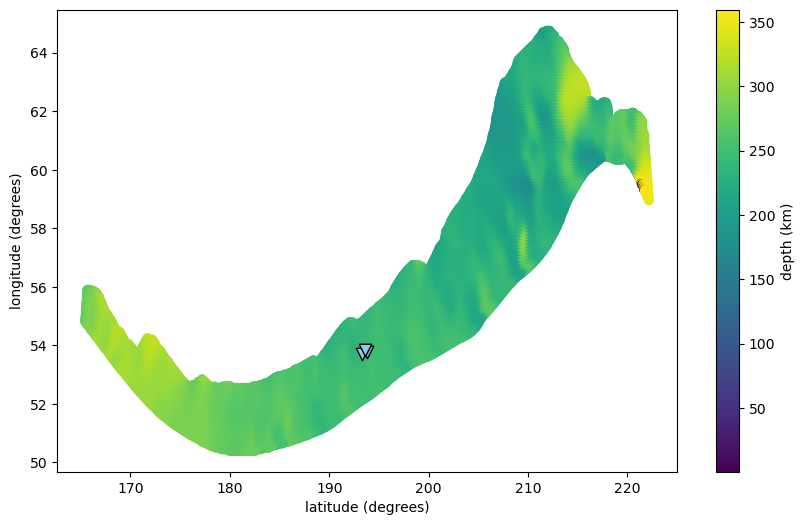

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#path = '/Users/cadequigley/Downloads/alu_slab2_dep_02.23.18.xyz'
#path = '/Users/cadequigley/Downloads/alu_slab2_dip_02.23.18.xyz'
path = '/Users/cadequigley/Downloads/alu_slab2_str_02.23.18.xyz'
#path = '/Users/cadequigley/Downloads/alu_slab2_thk_02.23.18.xyz'
df= pd.read_csv(path, names = ['x','y','z'])
df1 = df.dropna(subset=['z'])

lat_2a = 53.69619999999999
lon_2a = -166.7326
lat_3a = 53.77933636363636
lon_3a = -166.21232727272726
lat_pom = 53.85690833333333
lon_pom = -166.41502499999999

lats = [lat_2a,
       lat_3a,
        lat_pom
       ]
lons = [360+lon_2a,
        360+lon_3a,
        360+lon_pom
       ]
lats = np.array(lats)
lons = np.array(lons)

#%matplotlib widget
fig,ax = plt.subplots(figsize = (10,6))
z = df1['z'].to_numpy()
sc = ax.scatter(df1['x'],df1['y'],c = z,cmap = 'viridis')
ax.scatter(lons,lats,marker = 'v', s = 80,color = 'skyblue',linewidths = 1, edgecolors='black' )
ax.set_ylabel('longitude (degrees)')
ax.set_xlabel('latitude (degrees)')
plt.colorbar(sc, label = 'depth (km)')
#plt.gca().set_aspect('equal', adjustable='box')
plt.show()


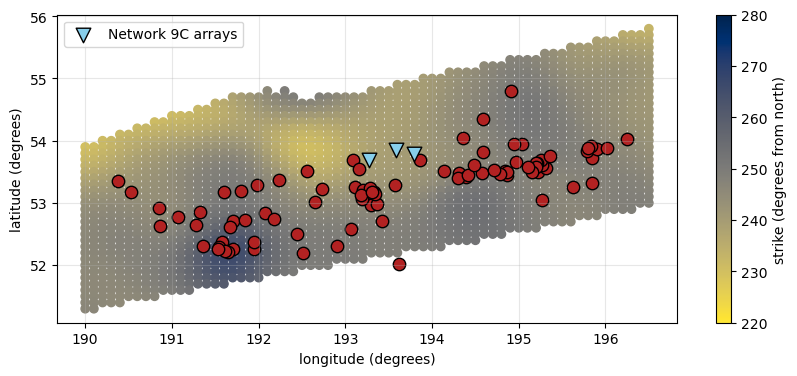

In [26]:
eqs = pd.read_csv('/Users/cadequigley/Downloads/array_plots/earthquake_dataset.csv')

#DEFINE REGION OF INTEREST
df2 = df1[(df1['x'] >= 190) & (df1['x'] <= 196.5)] #200.5
df_cleaned = df2[(df2['x'] * 100 % 10) != 5]
df2 = df_cleaned[(df_cleaned['y']* 100 % 10) != 5]
df2 = df2.reset_index(drop = True)
#%matplotlib widget
fig,ax = plt.subplots(figsize=(10,4))
z = df2['z'].to_numpy()
#sc = ax.scatter(df2['x'],df2['y'],c = -1*z,cmap = 'cividis_r') #turns depths to positive values
#sc = ax.scatter(df2['x'],df2['y'],c = z,cmap = 'cividis_r', vmin = 0, vmax = 70) #for dip values
sc = ax.scatter(df2['x'],df2['y'],c = z,cmap = 'cividis_r', vmin = 220, vmax = 280) #for strike values
#sc = ax.scatter(df2['x'],df2['y'],c = z,cmap = 'cividis_r', vmin = 50, vmax = 150) #for thickness values
ax.scatter(eqs['eq_longitude']+360, eqs['eq_latitude'], s = 80, color  = 'firebrick', edgecolors = 'black')
ax.scatter(lons,lats,marker = 'v', s = 110,color = 'skyblue',linewidths = 1, edgecolors='black',label = 'Network 9C arrays' )
ax.set_ylabel('latitude (degrees)')
ax.set_xlabel('longitude (degrees)')
plt.colorbar(sc, label = 'strike (degrees from north)')
#plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [22]:
np.mean(z)

245.52944164901234

In [116]:
eq_lons_df = df2['x']
eq_lats_df = df2['y']
depths = df2['z'].to_numpy()
depths = depths*(-1)
depths = np.ones(len(depths))*10
df1 = pd.DataFrame({
    'x': df2['x'],
    'y': df2['y'],
    'depth': depths
})
depths_list = [20,30,40,50,60,70,80,90,100]
for i in range(len(depths_list)):
    d = np.ones(len(depths))*depths_list[i]
    wa = pd.DataFrame({
    'x': df2['x'],
    'y': df2['y'],
    'depth': d
    })
    df1 = pd.concat([df1,wa],axis = 0)

In [197]:
### Saved to csv, shouldn't need to run again----------------------------
from obspy.geodetics import gps2dist_azimuth
from obspy.geodetics import kilometers2degrees

from obspy.taup import TauPyModel
from obspy.taup import taup_create

model = TauPyModel(model="japan_1d") #pavdut, japan_1d, iasp91

#sta_lons = lons[5:11]
#sta_lats = lats[5:11]
#sta_lons = x
#sta_lats = y_fit
sta_lons = lons
sta_lats = lats

eq_lons = df1['x'].to_numpy()
eq_lats = df1['y'].to_numpy()
depths = df1['depth'].to_numpy()
#depths = depths*(-1)
#depths = np.ones(len(depths))*10
station_names = ['2A','3A','POM']
comb_dist = []
comb_baz = []
comb_parr = []
comb_sarr = []
incident_list = []
slowness_list = []
takeoff_list = []
takeoff_depth_list = []
for j in range(len(sta_lats)):
    sta_lat = sta_lats[j]
    sta_lon = sta_lons[j]
    dist = []
    bazs = []
    parr = []
    sarr = []
    incident = []
    slowness = []
    takeoff = []
    takeoff_depth = []
    for i in range(len(eq_lons)):
        depth = depths[i]
        distance,baz,az = gps2dist_azimuth(sta_lat,sta_lon,eq_lats[i],eq_lons[i])
        distance = distance/1000
        dist.append(distance)
        bazs.append(baz)
        dist_deg = kilometers2degrees(distance)
        arrivals_p = model.get_travel_times(source_depth_in_km=depth,
                                  distance_in_degree=dist_deg,
                                  phase_list = ["P","p"])
        
        arrivals_s = model.get_travel_times(source_depth_in_km=depth,
                                  distance_in_degree=dist_deg,
                                  phase_list = ["S","s"])
        
        arr = arrivals_p[0]
        ptime = arr.time
        angle = arr.incident_angle
        vh = 4.8/(np.sin(np.deg2rad(angle))) #3.05
        slow = 1/vh
        slowness.append(slow)
        incident.append(angle)
        takeoff.append(arr.takeoff_angle)
        takeoff_depth.append(np.rad2deg(np.arctan(distance/depth)))
        arr = arrivals_s[0]
        stime = arr.time
        parr.append(ptime)
        sarr.append(stime)
        #print("Event done!")
        
    df5 = pd.DataFrame(dist,columns = ['station '+station_names[j]+' distance (km)'])
    df6 = pd.DataFrame(bazs,columns = ['station '+station_names[j]+' backazimuth'])
    df7 = pd.DataFrame(parr,columns = ['station '+station_names[j]+' p arrival'])
    df8 = pd.DataFrame(sarr,columns = ['station '+station_names[j]+' s arrival'])
    df9 = pd.DataFrame(incident,columns = ['station '+station_names[j]+' incident angle'])
    df10 = pd.DataFrame(slowness,columns = ['station '+station_names[j]+' slowness'])
    df11 = pd.DataFrame(takeoff,columns = ['station '+station_names[j]+' takeoff angle'])
    df12 = pd.DataFrame(takeoff_depth,columns = ['station '+station_names[j]+' takeoff angle from depth'])
    comb_dist.append(df5)
    comb_baz.append(df6)
    comb_parr.append(df7)
    comb_sarr.append(df8)
    incident_list.append(df9)
    slowness_list.append(df10)
    takeoff_list.append(df11)
    takeoff_depth_list.append(df12)
    print('station complete')
print('Finished')

df4 = df1.reset_index(drop=True)

for i in range(len(comb_dist)):
    wa = comb_dist[i]
    wawa = comb_baz[i]
    wawawa = comb_parr[i]
    wawawawa = comb_sarr[i]
    inc = incident_list[i]
    slow = slowness_list[i]
    take = takeoff_list[i]
    take2 = takeoff_depth_list[i]
    
    df4 = pd.concat([df4,wa],axis = 1)
    df4 = pd.concat([df4,wawa],axis=1)
    df4 = pd.concat([df4,wawawa],axis=1)
    df4 = pd.concat([df4,wawawawa],axis=1)
    df4 = pd.concat([df4,inc],axis=1)
    df4 = pd.concat([df4,slow],axis=1)
    df4 = pd.concat([df4,take],axis=1)
    df4 = pd.concat([df4,take2],axis=1)
    

station complete
station complete
station complete
Finished


In [198]:
### THEORETICAL DEFLECTION FOR 2A-----------------
depth_grid_df = pd.read_csv('/Users/cadequigley/Downloads/Research/paper_figures/depth_grid_snells.csv')
array = 'POM' #2A, 3A, POM

### data to be saved--------------------
#event_id = depth_grid_df['event_id']



##Input data to be used------------------ 
baz = depth_grid_df['station '+array+' backazimuth'].to_numpy()
az = baz_to_az(baz)
#takeoff = depth_grid_df['station '+array+' takeoff angle'].to_numpy()
takeoff = depth_grid_df['station '+array+' takeoff angle from depth'].to_numpy()
epi_distance = depth_grid_df['station '+array+' distance (km)']

#takeoff = df[array+'_pavdut_takeoff'].to_numpy()
#takeoff = df[array+'_iasp91_takeoff'].to_numpy()
#takeoff = df[array+'_'+mod+'_incidence']
#takeoff = df[array+'_japan_1d_takeoff'].to_numpy()
#takeoff = depth_grid_df[array+'_depth_takeoff'].to_numpy()
#epi_distance = depth_grid_df[array+'_dist']


##Define subduction zone--------------
strike = 249 # relative to north, 66 (trench), 61 (Unalaska), 249
dip = 10 # 0 to 90
oceanic_vel = 8.2 # km/s
continental_vel = 6.04 # km/s

##Calculate deflection-----------------
normal = plane_normal(dip, strike)

deflection_backazimuth = []
deflection_incident = []
deflection_slow = []

for i in range(len(baz)):
    azimuth = az[i]
    takeoff1 = takeoff[i]
    #print('Takeoff angle',takeoff1)
    incident = spherical_to_xyz(azimuth, takeoff1)
    refracted = snell_3d(incident, normal, oceanic_vel, continental_vel)

    ###BAZ ERROR--------------------------------------
    deflection_baz = deflection_xy(incident, refracted)
    deflection_backazimuth.append(deflection_baz)

    ###SLOWNESS ERROR---------------------------------

    # Undo azimuthal deflection to get vertical variation
    refracted_unrot = rotate_about_z(refracted, 0) #-deflected_baz #gives refracted vector that is rotated in the x-y plane back into plane of incident wave

    #Calculate original incident angle/final incident angle
    theta_inc = incidence_angle(incident) #incident angle of incident wave
    #theta_ref = incidence_angle(refracted_unrot) #incident angle of refracted wave
    theta_ref = incidence_angle(refracted) #incident angle of refracted wave
    #print('Incident angle', theta_inc)
    #print('Refracted angle', theta_ref)
    #Incident angle error
    incident_error_deg = theta_inc - theta_ref #change in incident angle
    deflection_incident.append(incident_error_deg)

    #Slowness error
    p_inc = horizontal_slowness(incident, oceanic_vel) # slowness of incident wave, oceanic_vel, 6.04
    p_ref = horizontal_slowness(refracted_unrot, continental_vel) # slowness of refracted wave, continental_vel, 6.04

    #delta_p = p_ref - p_inc #slowness error between 
    delta_p = p_inc - p_ref  #slowness error: incident ray - refracted ray

    deflection_slow.append(delta_p)

    ### OLD WAY OF CALCULATING SLOWNESS ERROR-------------------
    #deflection_inc = deflection_yz(incident, refracted)
    #deflection_incident.append(deflection_inc)


    
### Calculate slowness error--------------------
#slow_theor = []
#for i in range(len(deflection_incident)):
    #angle = -1*deflection_incident[i] #need to check why this is
    #vh = 6.05/(np.sin(np.deg2rad(angle))) #6.05
    #slow = 1/vh
    #slow_theor.append(slow)

### Save date in dataframe-----------------------

deflect_depth_grid = pd.DataFrame({
        array+'_baz': baz,
        array+'_baz_error_model': np.array(deflection_backazimuth),
        array+'_epicentral_distance':epi_distance,
        array+'_deflection_incident': np.array(deflection_incident),
        array+'_slowness_error': np.array(deflection_slow),
        #array+'_'+mod+'_slowness': depth_grid_df[array+'_'+mod+'_slowness'],
        #array+'_'+mod+'_incidence': depth_grid_df[array+'_'+mod+'_incidence'],
        #array+'_'+mod+'_trace_vel': depth_grid_df[array+'_'+mod+'_trace_vel'],
        #'event_id': event_id
})
    
#temp_deflect.to_csv('/Users/cadequigley/Downloads/Research/paper_figures/'+array+'_3Dsnell_dip_'+str(dip)+'_strike_'+str(strike)+'.csv')
print('Finished')


Finished


ValueError: x and y must have same first dimension, but have shapes (500,) and (88,)

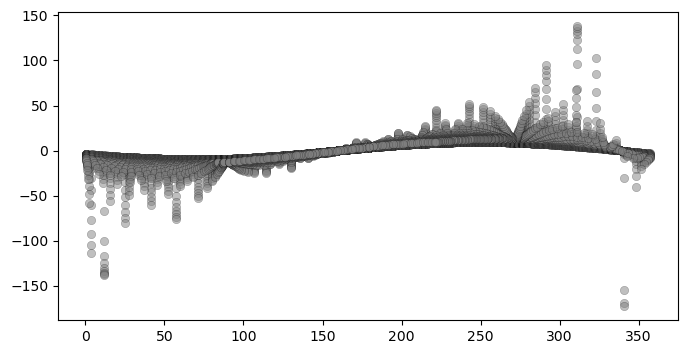

In [200]:
fig, ax = plt.subplots(figsize = (8,4))

#sc = ax.scatter(baz, np.array(deflection_backazimuth), c = np.array(slow_theor), cmap = 'seismic', edgecolors = 'black',linewidths =0.25, vmin = -0.2,vmax= 0.2)
ax.scatter(baz, np.array(deflection_backazimuth), color = 'gray',  edgecolors = 'black',linewidths =0.25,alpha = 0.5)
#sc = ax.scatter(temp_deflect[array+'_baz'], temp_deflect[array+'_baz_error_model'], c = temp_deflect[array+'_epicentral_distance'],s=80, cmap = 'plasma', edgecolors = 'black',linewidths =0.25,)

ax.plot(Z_fit, y_fit, color = 'skyblue', linewidth = 3) #niazi fit
#sc = ax.scatter(baz, np.array(deflection_backazimuth), c = depth_grid_df['depth'], cmap = 'plasma_r', edgecolors = 'black',linewidths =0.25)
#sc = ax.scatter(baz, np.array(deflection_backazimuth), c = depth_grid_df['station '+array+' slowness'], cmap = 'plasma_r', edgecolors = 'black',linewidths =0.25)
#ax.plot(bazs,cos,color = 'skyblue')
ax.text(45,50, "NE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(135,50, "SE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(225,50, "SW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(315,50, "NW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')

ax.axvline(x=90, color = 'black', linestyle = '--')
ax.axvline(x=180, color = 'black', linestyle = '--')
ax.axvline(x=270, color = 'black', linestyle = '--')
ax.axhline(y=0, color = 'red', linestyle = '--', alpha = 0.3)

ax.grid(alpha = 0.3)
ax.set_xlabel('catalog backazimuth')
ax.set_ylabel('backazimuth error (degrees)')
ax.set_xlim(0,360)
ax.set_ylim(-60,60)
#ax.set_title('Array '+array+' Theoretical Backazimuth Deflection')
plt.colorbar(sc, label = 'epicentral distance (km)')
ax.invert_xaxis()
#plt.savefig('./baz_error_modeled_2a', transparent=True, dpi = 720)
plt.show()

a = -0.37793607322341577
b = 13.491033544307507
phi (deg) = 69.92831181159085


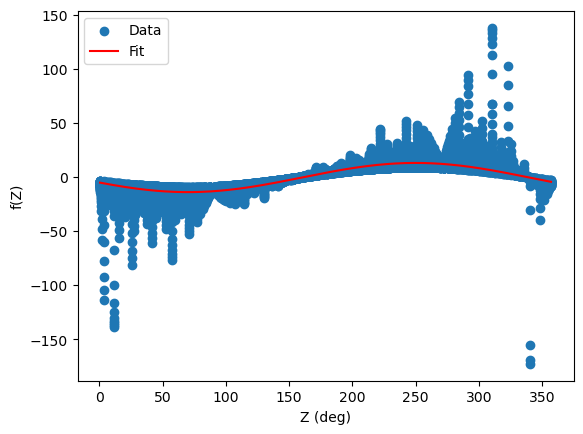

In [201]:
### Niazi style cosine fit--------------------------------
import numpy as np
from scipy.optimize import curve_fit

# Model: a - b*cos(Z - phi)
def cos_model(Z_deg, a, b, phi_deg):
    Z = np.radians(Z_deg)
    phi = np.radians(phi_deg)
    return a - b * np.cos(Z - phi)

# Example initial guesses
p0 = [1.0, 10.0, 180.0]   # a, b, phi guesses

Z_data = baz
y_data = np.array(deflection_backazimuth)

params, cov = curve_fit(cos_model, Z_data, y_data, p0=p0)

a_fit, b_fit, phi_fit = params
print("a =", a_fit)
print("b =", b_fit)
print("phi (deg) =", phi_fit)

Z_fit = np.linspace(min(Z_data), max(Z_data), 500)
y_fit = cos_model(Z_fit, *params)


import matplotlib.pyplot as plt

plt.scatter(Z_data, y_data, label='Data')
plt.plot(Z_fit, y_fit, 'r-', label='Fit')
plt.xlabel("Z (deg)")
plt.ylabel("f(Z)")
plt.legend()
plt.show()



In [420]:
temp_deflect.columns

Index(['POM_baz', 'POM_baz_error_model', 'POM_epicentral_distance',
       'POM_deflection_incident', 'POM_slowness_error',
       'POM_japan_1d_slowness', 'POM_japan_1d_incidence',
       'POM_japan_1d_trace_vel', 'event_id'],
      dtype='object')

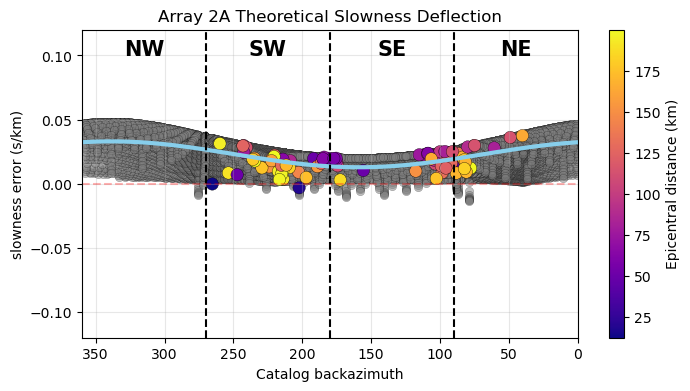

In [124]:
fig, ax = plt.subplots(figsize = (8,4))

#sc = ax.scatter(baz, np.array(deflection_slow), c = np.array(deflection_slow), cmap = 'seismic', edgecolors = 'black',linewidths =0.25, vmin = -0.1,vmax= 0.1)
sc = ax.scatter(baz, np.array(deflection_slow), color = 'gray', edgecolors = 'black',linewidths =0.25,alpha = 0.5)
ax.plot(Z_fit, y_fit, color = 'skyblue', linewidth = 3)
sc = ax.scatter(temp_deflect[array+'_baz'], temp_deflect[array+'_slowness_error'], c = temp_deflect[array+'_epicentral_distance'], s=80, cmap = 'plasma', edgecolors = 'black',linewidths =0.25,)
#sc = ax.scatter(baz, np.array(deflection_backazimuth), c = depth_grid_df['depth'], cmap = 'plasma_r', edgecolors = 'black',linewidths =0.25)
#sc = ax.scatter(baz, np.array(deflection_backazimuth), c = depth_grid_df['station '+array+' slowness'], cmap = 'plasma_r', edgecolors = 'black',linewidths =0.25)
#ax.plot(bazs,cos,color = 'skyblue')
ax.text(45,0.1, "NE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(135,0.1, "SE",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(225,0.1, "SW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')
ax.text(315,0.1, "NW",color = 'black', fontweight = 'bold',fontsize = 15, ha='center')

ax.axvline(x=90, color = 'black', linestyle = '--')
ax.axvline(x=180, color = 'black', linestyle = '--')
ax.axvline(x=270, color = 'black', linestyle = '--')
ax.axhline(y=0, color = 'red', linestyle = '--', alpha = 0.3)

ax.grid(alpha = 0.3)
ax.set_xlabel('Catalog backazimuth')
ax.set_ylabel('slowness error (s/km)')
ax.set_xlim(0,360)
ax.set_ylim(-0.12,0.12)
ax.set_title('Array '+array+' Theoretical Slowness Deflection')
plt.colorbar(sc, label = 'Epicentral distance (km)')
ax.invert_xaxis()
plt.show()

In [411]:
len(deflection_slow)

88

a = 0.022914812330194566
b = 0.010086289027177751
phi (deg) = 158.75833266460185


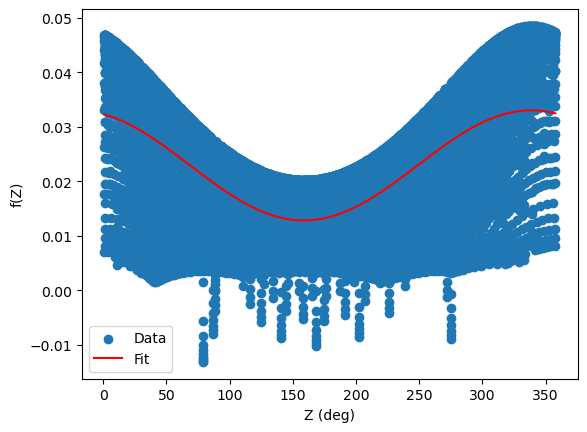

In [123]:
### Niazi style cosine fit--------------------------------
import numpy as np
from scipy.optimize import curve_fit

# Model: a - b*cos(Z - phi)
def cos_model(Z_deg, a, b, phi_deg):
    Z = np.radians(Z_deg)
    phi = np.radians(phi_deg)
    return a - b * np.cos(Z - phi)

# Example initial guesses
p0 = [1.0, 10.0, 180.0]   # a, b, phi guesses

Z_data = baz
y_data = np.array(deflection_slow)

params, cov = curve_fit(cos_model, Z_data, y_data, p0=p0)

a_fit, b_fit, phi_fit = params
print("a =", a_fit)
print("b =", b_fit)
print("phi (deg) =", phi_fit)

Z_fit = np.linspace(min(Z_data), max(Z_data), 500)
y_fit = cos_model(Z_fit, *params)


import matplotlib.pyplot as plt

plt.scatter(Z_data, y_data, label='Data')
plt.plot(Z_fit, y_fit, 'r-', label='Fit')
plt.xlabel("Z (deg)")
plt.ylabel("f(Z)")
plt.legend()
plt.show()



### Histograms

In [194]:
df_measured

Unnamed: 0.1  level_0  Unnamed: 0_x  index   sta chan net loc      lat  \
0              0        0             6     28  2A12  SHZ  9C  --  53.6930   
1              0        0            10    105  2A02  SHZ  9C  --  53.6960   
2              0        0             9     51  2A01  SHZ  9C  --  53.6933   
3              0        0            26    137  2A13  SHZ  9C  --  53.6935   
4              0        0             0     10  2A13  SHZ  9C  --  53.6935   
..           ...      ...           ...    ...   ...  ...  ..  ..      ...   
83             0        0            11     84  2A15  SHZ  9C  --  53.6952   
84             0        0            23    159  2A15  SHZ  9C  --  53.6952   
85             0        0            37    119  2A12  SHZ  9C  --  53.6930   
86             0        0             6     69  2A06  SHZ  9C  --  53.6981   
87             0        0             0      0  2A06  SHZ  9C  --  53.6981   

         lon  ...  trace_vel         baz     mdccm  baz_error  abs_baz_error  \
0  -166.7376  ...   8.336399  216.528520  0.513411  26.430372      26.430372   
1  -166.7298  ...   8.337372  112.627784  0.540236  -3.845770       3.845770   
2  -166.7271  ...   9.124636  118.714426  0.850769  -6.876305       6.876305   
3  -166.7320  ...  16.714373  222.341261  0.619186  43.027313      43.027313   
4  -166.7320  ...  15.324624  238.029110  0.566271   4.591895       4.591895   
..       ...  ...        ...         ...       ...        ...            ...   
83 -166.7277  ...   7.930169  113.902675  0.675715 -22.821611      22.821611   
84 -166.7277  ...   8.374637  115.506570  0.846742   2.161830       2.161830   
85 -166.7376  ...   7.052014  179.395260  0.609168  17.779169      17.779169   
86 -166.7307  ...  12.017465   77.046205  0.567140  -2.068605       2.068605   
87 -166.7307  ...  10.611861  103.887218  0.573274   2.499568       2.499568   

    new_time  conf_int_vel  conf_int_baz        time_y  elapsed_time  
0      0.250      1.282793      8.423300  16868.609626      0.017581  
1      0.250      0.639429      4.367958  16868.512040      0.018069  
2      0.240      0.739670      4.446324  16867.740676      0.018002  
3      0.250      8.921773     26.261391  16867.506417      0.001476  
4      0.250      8.559061     30.182837  16866.456825      0.019098  
..       ...           ...           ...           ...           ...  
83     0.250      0.534139      3.680761  16639.621268      0.017542  
84     0.250      0.435618      2.864738  16637.637373      0.017537  
85     0.250      0.512307      3.907487  16623.246218      0.018781  
86     0.250      1.696108      8.027695  16621.376555      0.018164  
87     0.255      1.566690      7.525595  16620.317908      0.018226  

[88 rows x 62 columns]

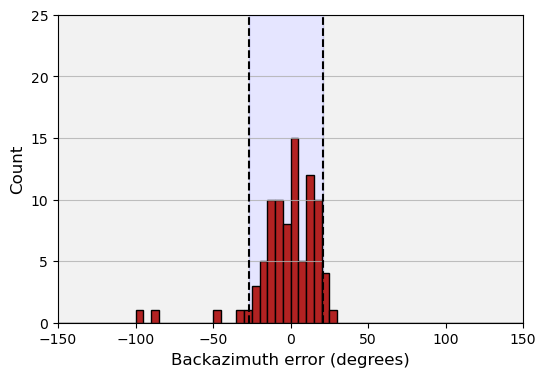

47.642234694934636


In [200]:
fig, ax = plt.subplots(figsize=(6, 4,))

#corrected = df_measured['baz_error'].to_numpy() #no correction
#corrected = df_measured['baz_error'].to_numpy() - temp_deflect['2A_baz_error'].to_numpy() #snells 3D
corrected = df_measured['baz_error'].to_numpy() - y_fit #niazi

hist_params = {
    'bins': 80, #5 degrees per bin
    'range': (-200, 200),
    'edgecolor': 'black'
    }
    
#corrected = corrected.dropna()
#b = baz_hist['baz_error']
c = corrected

ax.axvspan(-200,np.quantile(c, 0.05), color = 'gray',alpha = 0.1)

ax.axvspan(np.quantile(c, 0.95),200, color = 'gray',alpha = 0.1)
ax.axvspan(np.quantile(c, 0.05),np.quantile(c,0.95), color = 'blue',alpha = 0.1)

ax.hist(c, color = 'firebrick', **hist_params)

ax.set_xlabel('Backazimuth error (degrees)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.grid(axis='y', alpha=0.8)


ax.axvline(x=np.quantile(c, 0.95), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
ax.axvline(x=np.quantile(c, 0.05), ymin = 0, ymax = 1, color = 'black', linestyle = '--')
range1 = (np.abs(np.quantile(c, 0.05))+np.abs(np.quantile(c, 0.95)))

                                        


ax.set_xlim(-150, 150)
ax.set_ylim(0, 25)
#ax.set_title('Array '+array+' Theoretical Backazimuth Deflection')

#plt.tight_layout()  # To adjust space between subplots
#plt.savefig('/Users/cadequigley/Downloads/histogram_ess.png', transparent=True)
#plt.savefig('ls_histogram_timing_ssa.png', transparent=True, dpi = 720)
plt.show()
print(range1)

In [196]:
temp_deflect

2A_baz  2A_baz_error  2A_epicentral_distance
0   242.958893     25.392271              182.507457
1   108.782014    -16.598301               72.827051
2   111.838121    -15.217852               80.484126
3   265.368574     88.878360               12.076688
4   242.621005     27.500181               96.246113
..         ...           ...                     ...
83   91.081064    -20.616584              112.070059
84  117.668401    -11.613650              151.174541
85  197.174429     10.728100              173.761419
86   74.977600    -27.051808              113.765113
87  106.386786    -15.506065              164.382013

[88 rows x 3 columns]

In [199]:
y_fit

array([ 24.90096277, -20.12182149, -19.27315051,  24.4031699 ,
        24.87903276,  18.5142891 ,   4.8397976 , -23.48117661,
       -22.53724863,  12.74710073, -21.62882974, -21.45355695,
       -22.05310969, -22.00834991,  24.13055519,  21.14443704,
        19.98397364, -23.17396678, -23.45505601,   8.41970324,
        16.62505528,   6.29035875, -23.92674093, -24.09289197,
       -23.74279572,  11.68225449,  24.72923377,  22.38491251,
       -18.29062306, -24.92597364, -23.71041731, -23.14806158,
        21.94306768,  24.86902981, -25.1770186 ,  21.53460979,
        18.73906067,  10.58478387, -20.01748893,  23.34458064,
       -25.27560294,   5.62601384, -21.31868478, -24.25372243,
        16.50719901,  24.88073865,  25.14353164,  24.1144313 ,
        20.04009187,   7.41277576,  20.87491511, -21.22773432,
       -22.21094453,  24.91026962,  20.05771565,  20.30308937,
        21.61976632,  20.69637364,  22.02273654,   9.85958693,
       -22.92010246, -24.42212986, -21.75011522, -24.75

In [198]:
y_fit = cos_model(temp_deflect['2A_baz'].to_numpy(), *params)

In [ ]:
### Niazi style cosine fit--------------------------------
import numpy as np
from scipy.optimize import curve_fit

# Model: a - b*cos(Z - phi)
def cos_model(Z_deg, a, b, phi_deg):
    Z = np.radians(Z_deg)
    phi = np.radians(phi_deg)
    return a - b * np.cos(Z - phi)

# Example initial guesses
p0 = [1.0, 10.0, 180.0]   # a, b, phi guesses

Z_data = baz
y_data = np.array(deflection_backazimuth)

params, cov = curve_fit(cos_model, Z_data, y_data, p0=p0)

a_fit, b_fit, phi_fit = params
print("a =", a_fit)
print("b =", b_fit)
print("phi (deg) =", phi_fit)

Z_fit = np.linspace(min(Z_data), max(Z_data), 500)
y_fit = cos_model(Z_fit, *params)


import matplotlib.pyplot as plt

plt.scatter(Z_data, y_data, label='Data')
plt.plot(Z_fit, y_fit, 'r-', label='Fit')
plt.xlabel("Z (deg)")
plt.ylabel("f(Z)")
plt.legend()
plt.show()

